# Lab 3: A Conditional Generative Model for Images
Welcome to lab 3! In the previous lab, we studied *unconditional* generation, for toy, two-dimensional data distributions. In this lab, we will study *conditional* generation on *images* from the MNIST dataset of handwritten digits. Each such MNIST image is not two dimensions but $32\times 32 = 1024$ dimensions! The nature of our new, more challenging setting will require us to take special care:
1. To tackle *conditional* generation, we will employ *classifier-free guidance* (CFG) (see Part 2.1).
2. To parameterize our learned vector field for high-dimensional image-valued data, a simple MLP will not suffice. Instead, we will adopt the *U-Net* architecture (see part 2.2).

If you find any mistakes, or have any other feedback, please feel free to email us at `erives@mit.edu` and `phold@mit.edu`. Enjoy!

In [ ]:
from abc import ABC, abstractmethod
from typing import Optional, List, Type, Tuple, Dict
import math

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.axes._axes import Axes
import torch
import torch.nn as nn
import torch.distributions as D
from torch.func import vmap, jacrev
from tqdm import tqdm
import seaborn as sns
from sklearn.datasets import make_moons, make_circles
from torchvision import datasets, transforms
from torchvision.utils import make_grid

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Part 0: Recycling Components from Previous Labs
In this section, we'll re-import previous components from labs one and two. In doing so, we'll make some important updates. First, let's revisit our `Sampleable` class from labs one and two. Below, we have named it `OldSampleable`.

In [ ]:
class OldSampleable(ABC):
    """
    Distribution which can be sampled from
    """
    @abstractmethod
    def sample(self, num_samples: int) -> torch.Tensor:
        """
        Args:
            - num_samples: the desired number of samples
        Returns:
            - samples: shape (batch_size, ...)
        """
        pass

As we will see shortly, a dataset like MNIST contains both images (in this case handwritten digits), as well as class labels (a value from 0-9 indicating). We will therefore generalize our notion of `Sampleable` to accommodate these labels as well. Whereas the old, `OldSampleable.sample` method returned only `samples: torch.Tensor`, we will now have it return both `samples: torch.Tensor` *and* `labels: Optional[torch.Tensor]`. In this way, we are formally realizing every such `Sampleable` instance as sampling from a *joint distribution* over data and labels. We implement our new `Sampleable` below.

In [ ]:
class Sampleable(ABC):
    """
    Distribution which can be sampled from
    """
    @abstractmethod
    def sample(self, num_samples: int) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        """
        Args:
            - num_samples: the desired number of samples
        Returns:
            - samples: shape (batch_size, ...)
            - labels: shape (batch_size, label_dim)
        """
        pass

For certain distributions, such as a Gaussian, it doesn't really make sense to think about labels. For this reason we have made the labels return value Optional: a Gaussian can just return `None`. Below, we implement the class `IsotropicGaussian`.

In [ ]:
class IsotropicGaussian(nn.Module, Sampleable):
    """
    Sampleable wrapper around torch.randn
    """
    def __init__(self, shape: List[int], std: float = 1.0):
        """
        shape: shape of sampled data
        """
        super().__init__()
        self.shape = shape
        self.std = std
        self.dummy = nn.Buffer(torch.zeros(1)) # Will automatically be moved when self.to(...) is called...

    def sample(self, num_samples) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.std * torch.randn(num_samples, *self.shape).to(self.dummy.device), None

Next, we make two updates in adding `ConditionalProbabilityPath` (and `GaussianConditionalProbabilityPath`):
1. We adjust to handle the addition of labels to `Sampleable`. Recall earlier that our called our conditioning variable `z` with $z \sim p_{\text{data}}(z)$. Now, we sample both `z`, as well as a label `y`, with $(z,y) \sim p_{\text{data}}(z,y)$.
2. We ensure that the logic is compatible with shapes of size `(batch_size, c, h, w)`, rather than `(batch_size, dim)`. While the latter was sufficient for 2D data of shape `(batch_size, 2)`, we will now be working with images which, when batched, have shape `(batch_size, c, h, w)`. Here `c`, `h`, and `w`, denote the number of channels, the height, and the width, respectively.
3. To avoid any unfortunate broadcasting issues, we will maintain our time variable `t` in the shape `(batch_size, 1, 1, 1)`.

In [ ]:
class ConditionalProbabilityPath(nn.Module, ABC):
    """
    Abstract base class for conditional probability paths
    """
    def __init__(self, p_simple: Sampleable, p_data: Sampleable):
        super().__init__()
        self.p_simple = p_simple
        self.p_data = p_data

    def sample_marginal_path(self, t: torch.Tensor) -> torch.Tensor:
        """
        Samples from the marginal distribution p_t(x) = p_t(x|z) p(z)
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - x: samples from p_t(x), (num_samples, c, h, w)
        """
        num_samples = t.shape[0]
        # Sample conditioning variable z ~ p(z)
        z, _ = self.sample_conditioning_variable(num_samples) # (num_samples, c, h, w)
        # Sample conditional probability path x ~ p_t(x|z)
        x = self.sample_conditional_path(z, t) # (num_samples, c, h, w)
        return x

    @abstractmethod
    def sample_conditioning_variable(self, num_samples: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Samples the conditioning variable z and label y
        Args:
            - num_samples: the number of samples
        Returns:
            - z: (num_samples, c, h, w)
            - y: (num_samples, label_dim)
        """
        pass

    @abstractmethod
    def sample_conditional_path(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Samples from the conditional distribution p_t(x|z)
        Args:
            - z: conditioning variable (num_samples, c, h, w)
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - x: samples from p_t(x|z), (num_samples, c, h, w)
        """
        pass

    @abstractmethod
    def conditional_vector_field(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional vector field u_t(x|z)
        Args:
            - x: position variable (num_samples, c, h, w)
            - z: conditioning variable (num_samples, c, h, w)
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - conditional_vector_field: conditional vector field (num_samples, c, h, w)
        """
        pass

    @abstractmethod
    def conditional_score(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional score of p_t(x|z)
        Args:
            - x: position variable (num_samples, c, h, w)
            - z: conditioning variable (num_samples, c, h, w)
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - conditional_score: conditional score (num_samples, c, h, w)
        """
        pass

Finally, we add back in `GaussianConditionalProbabilityPath`, along with `LinearAlpha` and `LinearBeta`, defined similarly to the previous lab. Here, we must be careful to avoid irksome broadcasting issues: broadcasting e.g., `alpha(t)` of shape `(batch_size, 1)` together with `x` of shape `(batch_size, c, h, w)` will not work! We alleviate this issue by ensuring that `alpha(t)` and `beta(t)` are, similarly to `t` itself, also both of shape `(batch_size, 1, 1, 1)`.

In [ ]:
class Alpha(ABC):
    def __init__(self):
        # Check alpha_t(0) = 0
        assert torch.allclose(
            self(torch.zeros(1,1,1,1)), torch.zeros(1,1,1,1)
        )
        # Check alpha_1 = 1
        assert torch.allclose(
            self(torch.ones(1,1,1,1)), torch.ones(1,1,1,1)
        )

    @abstractmethod
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates alpha_t. Should satisfy: self(0.0) = 0.0, self(1.0) = 1.0.
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - alpha_t (num_samples, 1, 1, 1)
        """
        pass

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt alpha_t.
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - d/dt alpha_t (num_samples, 1, 1, 1)
        """
        t = t.unsqueeze(1)
        dt = vmap(jacrev(self))(t)
        return dt.view(-1, 1, 1, 1)

class Beta(ABC):
    def __init__(self):
        # Check beta_0 = 1
        assert torch.allclose(
            self(torch.zeros(1,1,1,1)), torch.ones(1,1,1,1)
        )
        # Check beta_1 = 0
        assert torch.allclose(
            self(torch.ones(1,1,1,1)), torch.zeros(1,1,1,1)
        )

    @abstractmethod
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates alpha_t. Should satisfy: self(0.0) = 1.0, self(1.0) = 0.0.
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - beta_t (num_samples, 1, 1, 1)
        """
        pass

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt beta_t.
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - d/dt beta_t (num_samples, 1, 1, 1)
        """
        t = t.unsqueeze(1)
        dt = vmap(jacrev(self))(t)
        return dt.view(-1, 1, 1, 1)

class LinearAlpha(Alpha):
    """
    Implements alpha_t = t
    """

    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - alpha_t (num_samples, 1, 1, 1)
        """
        return t

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt alpha_t.
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - d/dt alpha_t (num_samples, 1, 1, 1)
        """
        return torch.ones_like(t)

class LinearBeta(Beta):
    """
    Implements beta_t = 1-t
    """
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - t: time (num_samples, 1)
        Returns:
            - beta_t (num_samples, 1)
        """
        return 1-t

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt alpha_t.
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - d/dt alpha_t (num_samples, 1, 1, 1)
        """
        return - torch.ones_like(t)

class GaussianConditionalProbabilityPath(ConditionalProbabilityPath):
    def __init__(self, p_data: Sampleable, p_simple_shape: List[int], alpha: Alpha, beta: Beta):
        p_simple = IsotropicGaussian(shape = p_simple_shape, std = 1.0)
        super().__init__(p_simple, p_data)
        self.alpha = alpha
        self.beta = beta

    def sample_conditioning_variable(self, num_samples: int) -> torch.Tensor:
        """
        Samples the conditioning variable z and label y
        Args:
            - num_samples: the number of samples
        Returns:
            - z: (num_samples, c, h, w)
            - y: (num_samples, label_dim)
        """
        return self.p_data.sample(num_samples)

    def sample_conditional_path(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Samples from the conditional distribution p_t(x|z)
        Args:
            - z: conditioning variable (num_samples, c, h, w)
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - x: samples from p_t(x|z), (num_samples, c, h, w)
        """
        t = t.to(device=z.device, dtype=z.dtype)
        print("z:", z.device, z.dtype, "t:", t.device, t.dtype)

        return self.alpha(t) * z + self.beta(t) * torch.randn_like(z)

    def conditional_vector_field(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional vector field u_t(x|z)
        Args:
            - x: position variable (num_samples, c, h, w)
            - z: conditioning variable (num_samples, c, h, w)
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - conditional_vector_field: conditional vector field (num_samples, c, h, w)
        """
        alpha_t = self.alpha(t) # (num_samples, 1, 1, 1)
        beta_t = self.beta(t) # (num_samples, 1, 1, 1)
        dt_alpha_t = self.alpha.dt(t) # (num_samples, 1, 1, 1)
        dt_beta_t = self.beta.dt(t) # (num_samples, 1, 1, 1)

        return (dt_alpha_t - dt_beta_t / beta_t * alpha_t) * z + dt_beta_t / beta_t * x

    def conditional_score(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional score of p_t(x|z)
        Args:
            - x: position variable (num_samples, c, h, w)
            - z: conditioning variable (num_samples, c, h, w)
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - conditional_score: conditional score (num_samples, c, h, w)
        """
        alpha_t = self.alpha(t)
        beta_t = self.beta(t)
        return (z * alpha_t - x) / beta_t ** 2

Now, let us accordingly update our `ODE`, `SDE`, and `Simulator` classes. This is pretty much a matter of
1. Updating `t: (batch_size, 1)` to `t: (batch_size, 1, 1, 1)`, and `xt: (batch_size, dim)` to `(batch_size, c, h, w)`. For brevity, we will usually use `bs` as shorthand for `batch_size`.
2. Adding support for an optional *conditioning* input `y: Optional[torch.Tensor]`. We will opt to more simply add a generic `**kwargs` to the signatures of the relevant methods (`drift_coefficient`, `diffusion_coefficient`, `step`, `simulate`, etc.).

In [ ]:
class ODE(ABC):
    @abstractmethod
    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor, **kwargs) -> torch.Tensor:
        """
        Returns the drift coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs, c, h, w)
            - t: time, shape (bs, 1)
        Returns:
            - drift_coefficient: shape (bs, c, h, w)
        """
        pass

class SDE(ABC):
    @abstractmethod
    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor, **kwargs) -> torch.Tensor:
        """
        Returns the drift coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs, c, h, w)
            - t: time, shape (bs, 1, 1, 1)
        Returns:
            - drift_coefficient: shape (bs, c, h, w)
        """
        pass

    @abstractmethod
    def diffusion_coefficient(self, xt: torch.Tensor, t: torch.Tensor, **kwargs) -> torch.Tensor:
        """
        Returns the diffusion coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs, c, h, w)
            - t: time, shape (bs, 1, 1, 1)
        Returns:
            - diffusion_coefficient: shape (bs, c, h, w)
        """
        pass

In [ ]:
class Simulator(ABC):
    @abstractmethod
    def step(self, xt: torch.Tensor, t: torch.Tensor, dt: torch.Tensor, **kwargs):
        """
        Takes one simulation step
        Args:
            - xt: state at time t, shape (bs, c, h, w)
            - t: time, shape (bs, 1, 1, 1)
            - dt: time, shape (bs, 1, 1, 1)
        Returns:
            - nxt: state at time t + dt (bs, c, h, w)
        """
        pass

    @torch.no_grad()
    def simulate(self, x: torch.Tensor, ts: torch.Tensor, **kwargs):
        """
        Simulates using the discretization gives by ts
        Args:
            - x_init: initial state, shape (bs, c, h, w)
            - ts: timesteps, shape (bs, nts, 1, 1, 1)
        Returns:
            - x_final: final state at time ts[-1], shape (bs, c, h, w)
        """
        nts = ts.shape[1]
        for t_idx in tqdm(range(nts - 1)):
            t = ts[:, t_idx]
            h = ts[:, t_idx + 1] - ts[:, t_idx]
            x = self.step(x, t, h, **kwargs)
        return x

    @torch.no_grad()
    def simulate_with_trajectory(self, x: torch.Tensor, ts: torch.Tensor, **kwargs):
        """
        Simulates using the discretization gives by ts
        Args:
            - x: initial state, shape (bs, c, h, w)
            - ts: timesteps, shape (bs, nts, 1, 1, 1)
        Returns:
            - xs: trajectory of xts over ts, shape (batch_size, nts, c, h, w)
        """
        xs = [x.clone()]
        nts = ts.shape[1]
        for t_idx in tqdm(range(nts - 1)):
            t = ts[:,t_idx]
            h = ts[:, t_idx + 1] - ts[:, t_idx]
            x = self.step(x, t, h, **kwargs)
            xs.append(x.clone())
        return torch.stack(xs, dim=1)

class EulerSimulator(Simulator):
    def __init__(self, ode: ODE):
        self.ode = ode

    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor, **kwargs):
        return xt + self.ode.drift_coefficient(xt,t, **kwargs) * h

class EulerMaruyamaSimulator(Simulator):
    def __init__(self, sde: SDE):
        self.sde = sde

    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor, **kwargs):
        return xt + self.sde.drift_coefficient(xt,t, **kwargs) * h + self.sde.diffusion_coefficient(xt,t, **kwargs) * torch.sqrt(h) * torch.randn_like(xt)

def record_every(num_timesteps: int, record_every: int) -> torch.Tensor:
    """
    Compute the indices to record in the trajectory given a record_every parameter
    """
    if record_every == 1:
        return torch.arange(num_timesteps)
    return torch.cat(
        [
            torch.arange(0, num_timesteps - 1, record_every),
            torch.tensor([num_timesteps - 1]),
        ]
    )

Finally, let's add back in our definition of `Trainer`.

In [ ]:
MiB = 1024 ** 2

def model_size_b(model: nn.Module) -> int:
    """
    Returns model size in bytes. Based on https://discuss.pytorch.org/t/finding-model-size/130275/2
    Args:
    - model: self-explanatory
    Returns:
    - size: model size in bytes
    """
    size = 0
    for param in model.parameters():
        size += param.nelement() * param.element_size()
    for buf in model.buffers():
        size += buf.nelement() * buf.element_size()
    return size

class Trainer(ABC):
    def __init__(self, model: nn.Module):
        super().__init__()
        self.model = model

    @abstractmethod
    def get_train_loss(self, **kwargs) -> torch.Tensor:
        pass

    def get_optimizer(self, lr: float):
        return torch.optim.Adam(self.model.parameters(), lr=lr)

    def train(self, num_epochs: int, device: torch.device, lr: float = 1e-3, **kwargs) -> torch.Tensor:
        # Report model size
        size_b = model_size_b(self.model)
        print(f'Training model with size: {size_b / MiB:.3f} MiB')

        # Start
        self.model = self.model.to(device)
        opt = self.get_optimizer(lr)
        self.model.train()

        # Train loop
        pbar = tqdm(enumerate(range(num_epochs)))
        for idx, epoch in pbar:
            opt.zero_grad()
            loss = self.get_train_loss(**kwargs)
            loss.backward()
            opt.step()
            pbar.set_description(f'Epoch {idx}, loss: {loss.item():.3f}')

        # Finish
        self.model.eval()

# Part 1: Getting a Feel for MNIST
In this section, we'll get a feel for MNIST. We'll then experiment with adding noise to MNIST with `ConditionalGaussianProbabilityPath`.

In [ ]:
class MNISTSampler(nn.Module, Sampleable):
    """
    Sampleable wrapper for the MNIST dataset
    """
    def __init__(self):
        super().__init__()
        self.dataset = datasets.MNIST(
            root='./data',
            train=True,
            download=True,
            transform=transforms.Compose([
                transforms.Resize((32, 32)),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
            ])
        )
        self.dummy = nn.Buffer(torch.zeros(1)) # Will automatically be moved when self.to(...) is called...

    def sample(self, num_samples: int) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        """
        Args:
            - num_samples: the desired number of samples
        Returns:
            - samples: shape (batch_size, c, h, w)
            - labels: shape (batch_size, label_dim)
        """
        if num_samples > len(self.dataset):
            raise ValueError(f"num_samples exceeds dataset size: {len(self.dataset)}")

        indices = torch.randperm(len(self.dataset))[:num_samples]
        samples, labels = zip(*[self.dataset[i] for i in indices])
        samples = torch.stack(samples).to(self.dummy)
        labels = torch.tensor(labels, dtype=torch.int64).to(self.dummy.device)
        return samples, labels

Now let's view some samples under the conditional probability path.

z: cuda:0 torch.float32 t: cuda:0 torch.float32
z: cuda:0 torch.float32 t: cuda:0 torch.float32
z: cuda:0 torch.float32 t: cuda:0 torch.float32
z: cuda:0 torch.float32 t: cuda:0 torch.float32
z: cuda:0 torch.float32 t: cuda:0 torch.float32


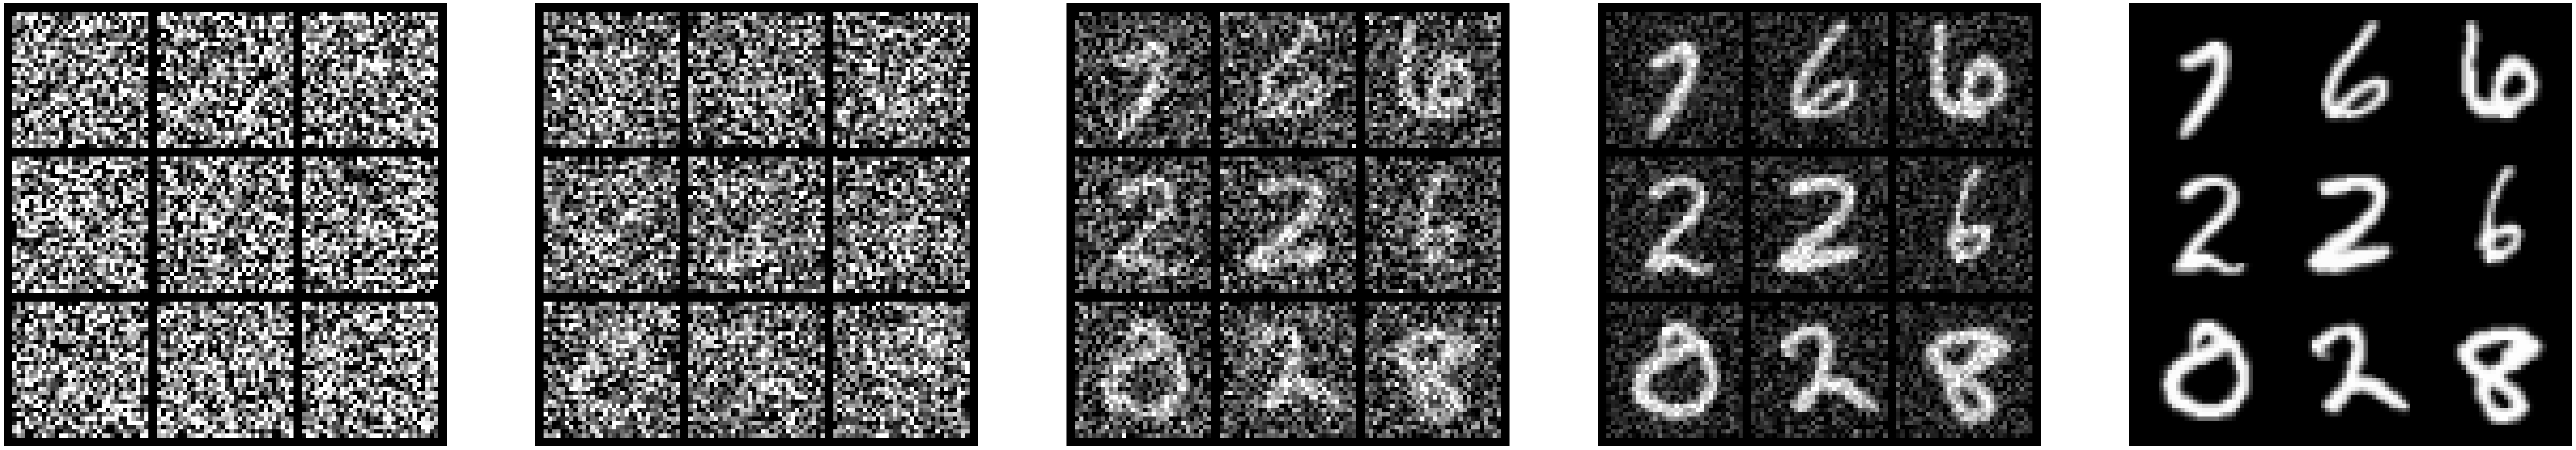

In [ ]:
# Change these!
num_rows = 3
num_cols = 3
num_timesteps = 5

# Initialize our sampler
sampler = MNISTSampler().to(device)

# Initialize probability path
path = GaussianConditionalProbabilityPath(
    p_data = MNISTSampler(),
    p_simple_shape = [1, 32, 32],
    alpha = LinearAlpha(),
    beta = LinearBeta()
).to(device)

# Sample
num_samples = num_rows * num_cols
z, _ = path.p_data.sample(num_samples)
z = z.view(-1, 1, 32, 32)

# Setup plot
fig, axes = plt.subplots(1, num_timesteps, figsize=(6 * num_cols * num_timesteps, 6 * num_rows))

# Sample from conditional probability paths and graph
ts = torch.linspace(0, 1, num_timesteps).to(device)
for tidx, t in enumerate(ts):
    tt = t.view(1,1,1,1).expand(num_samples, 1, 1, 1) # (num_samples, 1, 1, 1)
    xt = path.sample_conditional_path(z, tt) # (num_samples, 1, 32, 32)
    grid = make_grid(xt, nrow=num_cols, normalize=True, value_range=(-1,1))
    axes[tidx].imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
    axes[tidx].axis("off")
plt.show()

# Part 2: Classifier Free Guidance

### Problem 2.1: Classifier Free Guidance

**Guidance**: Whereas for unconditional generation, we simply wanted to generate *any* digit, we would now like to be able to specify, or *condition*, on the identity of the digit we would like to generate. That is, we would like to be able to say "generate an image of the digit 8", rather than just "generate an image of a digit". We will henceforth refer to the digit we would like to generate as $x \in \mathbb{R}^{1 \times 32 \times 32}$, and the conditioning variable (in this case, a label), as $y \in \{0, 1, \dots, 9\}$. If we imagine fixing our choice of $y$, and take our data distribution as $p_{\text{simple}}(x|y)$, then we have recovered the unconditional generative problem, and we can construct a generative model using e.g., a conditional flow matching objective via $$\begin{align*}\mathcal{L}_{\text{CFM}}^{\text{guided}}(\theta;y) &= \,\,\mathbb{E}_{\square} \lVert u_t^{\theta}(x|y) - u_t^{\text{ref}}(x|z)\rVert^2\\ \square &= z \sim p_{\text{data}}(z|y), x \sim p_t(x|z)\end{align*}$$
We may now then allow $y$ to vary by simply taking our conditional flow matching expectation to be over $y$ as well (rather than fixing $y$), and explicitly conditioning our learned approximation on $u_t^{\theta}(x|y)$ on the choice of $y$. We therefore obtain the the *guided* conditional flow matching objective $$\begin{align*}\mathcal{L}_{\text{CFM}}(\theta) &= \,\,\mathbb{E}_{\square} \lVert u_t^{\theta}(x|y) - u_t^{\text{ref}}(x|z)\rVert^2\\ \square &= z,y \sim p_{\text{data}}(z,y), x \sim p_t(x|z)\end{align*}$$
Note that $(z,y) \sim p_{\text{simple}}(z,y)$ is obtained in practice by sampling an image $z$, and a label $y$, from our labelled (MNIST) dataset. This is all well and good, and we emphasize that if our goal was simply to sample from $p_{\text{data}}(x|y)$, our job would be done (at least in theory). In practice, one might argue that we care more about the *perceptual quality* of our images. To this end, we will a derive a procedure known as *classifier-free guidance*.

**Classifier-Free Guidance**: For the sake of intuition, we will develop guidance through the lense of Gaussian probability paths, although the final result might reasonably be applied to any probability path. Recall from the lecture that for $(a_t, b_t) = \left(\frac{\dot{\alpha}_t}{\alpha_t}, -\frac{\dot{\beta}_t \beta_t \alpha_t - \dot{\alpha}_t \beta_t^2}{\alpha_t}\right)$, we have $$u_t(x|y) = a_tx + b_t\nabla \log p_t(x|y).$$
This identity allows us to relate the *conditional marginal velocity* $u_t(x|y)$ to the *conditional score* $\nabla \log p_t(x|y)$. However, notice that $$\nabla \log p_t(x|y) = \nabla \log \left(\frac{p_t(x)p_t(y|x)}{p_t(y)}\right) = \nabla \log p_t(x) + \nabla \log p_t(y|x),$$
so that we may rewrite $$u_t(x|y) = a_tx + b_t(\nabla \log p_t(x) + \nabla \log p_t(y|x)) = u_t(x) + b_t \nabla \log p_t(y|x).$$
An approximation of the term $\nabla \log p_t(y|x)$ could be considered as a sort of noisy classifier (and in fact this is the origin of *classifier guidance*, which we do not consider here). In practice, people have noticed that the conditioning seems to work better when we scale the contribution of this classifier term, yielding
$$\tilde{u}_t(x|y) = u_t(x) + w b_t \nabla \log p_t(y|x)$$
where $w > 1$ is known as the *guidance scale*. We may then plug in $b_t\log p_t(y|x) = u^{\text{target}}_t(x|y) - u^{\text{target}}_t(x)$ to obtain $$\begin{align}\tilde{u}_t(x|y) &= u_t(x) + w b_t \nabla \log p_t(y|x)\\
&= u_t(x) + w (u^{\text{target}}_t(x|y) - u^{\text{target}}_t(x))\\
&= (1-w) u_t(x) + w u_t(x|y). \end{align}$$
The idea is thus to train both $u_t(x)$ as well as the conditional model $u_t(x|y)$, and then combine them *at inference time* to obtain $\tilde{u}_t(x|y)$. Our recipe will thus be:
1. Train $u_t^{\theta} \approx u_t(x)$ as well as the conditional model $u_t^{\theta}(x|y) \approx u_t(x|y)$ using conditional flow matching.
2. At inference time, sample using $\tilde{u}_t^{\theta}(x|y)$.

"But wait!", you say, "why must we train two models?". Indeed, we can instead treat $u_t(x)$ as $u_t(x|y)$, where $y=\varnothing$ denotes *the absence of conditioning*. We may thus augment our label set with a new, additional $\varnothing$ label, so that $y \in \{0,1,\dots, 9, \varnothing\}$. This technique is known as **classifier-free guidance** (CFG). We thus arrive at
$$\boxed{\tilde{u}_t(x|y) = (1-w) u_t(x|\varnothing) + w u_t(x|y)}.$$

**Training and CFG**: We must now amend our conditional flow matching objective to account for the possibility of $y = \varnothing$. Of course, when we sample $(z,y)$ from MNIST, we will never obtain $y = \varnothing$, so we must introduce the possibliity of this artificially. To do so, we will define some hyperparameter $\eta$ to be the *probability* that we discard the original label $y$, and replace it with $\varnothing$. In practice, we might set $\varnothing = 10$, for example, as it is sufficient to distinguish it from the other digit identities. When we go and implement our model, we need ony be able to index into some embedding, such as via `torch.nn.Embedding`. We thus arrive at our CFG conditional flow matching training objective:
$$\begin{align*}\mathcal{L}_{\text{CFM}}(\theta) &= \,\,\mathbb{E}_{\square} \lVert u_t^{\theta}(x|y) - u_t^{\text{ref}}(x|z)\rVert^2\\
\square &= z,y \sim p_{\text{data}}(z,y), x \sim p_t(x|z),\,\text{replace $y$ with $\varnothing$ with probability $\eta$}\end{align*}$$
In plain English, this objective reads:
1. Sample an image $z$ and a label $y$ from $p_{\text{data}}$ (here, MNIST).
2. With probability $\eta$, replace the label $y$ with the null label $\varnothing \triangleq 10$.
3. Sample $t$ from $\mathcal{U}[0,1]$.
4. Sample $x$ from the conditional probability path $p_t(x|z)$.
5. Regress $u_t^{\theta}(x|y)$ against $u_t^{\text{ref}}(x|z)$.


### Question 2.2: Training for Classifier-Free Guidance
In this section, you'll the training objective $\mathcal{L}_{\text{CFM}}(\theta)$ in which $u_t^{\theta}(x|y)$ is an instance of the class `ConditionalVectorField` described below.

In [ ]:
class ConditionalVectorField(nn.Module, ABC):
    """
    MLP-parameterization of the learned vector field u_t^theta(x)
    """

    @abstractmethod
    def forward(self, x: torch.Tensor, t: torch.Tensor, y: torch.Tensor):
        """
        Args:
        - x: (bs, c, h, w)
        - t: (bs, 1, 1, 1)
        - y: (bs,)
        Returns:
        - u_t^theta(x|y): (bs, c, h, w)
        """
        pass

class CFGVectorFieldODE(ODE):
    def __init__(self, net: ConditionalVectorField, guidance_scale: float = 1.0):
        self.net = net
        self.guidance_scale = guidance_scale

    def drift_coefficient(self, x: torch.Tensor, t: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - x: (bs, c, h, w)
        - t: (bs, 1, 1, 1)
        - y: (bs,)
        """
        guided_vector_field = self.net(x, t, y)
        unguided_y = torch.ones_like(y) * 10
        unguided_vector_field = self.net(x, t, unguided_y)
        return (1 - self.guidance_scale) * unguided_vector_field + self.guidance_scale * guided_vector_field


**Your job**: Fill in `CFGFlowTrainer.get_train_loss`, so that it implements $\mathcal{L}_{\text{CFM}}(\theta)$ described above. In doing so, feel free to "hardcode" $\varnothing = 10$. A more general implementation would not make this MNIST-specific assumption, but for the sake of this assignment you may do so.

**Hints**:
1. To sample an image $(z,y) \sim p_{\text{data}}$, use `self.path.p_data.sample`
2. You can generate a mask corresponding to "probability $\eta$" via `mask = torch.rand(batch_size) < self.eta`.
3. You can sample $t \sim \mathcal{U}[0,1]$ using `torch.rand(batch_size, 1, 1, 1)`. Don't mix up `torch.rand` with `torch.randn`!
4. You can sample $x \sim p_t(x|z)$ using `self.path.sample_conditional_path`.

In [ ]:
class CFGTrainer(Trainer):
    def __init__(self, path: GaussianConditionalProbabilityPath, model: ConditionalVectorField, eta: float, **kwargs):
        assert eta > 0 and eta < 1
        super().__init__(model, **kwargs)
        self.eta = eta
        self.path = path

    def get_train_loss(self, batch_size: int) -> torch.Tensor:
        # Step 1: Sample z,y from p_data
        z, y = self.path.p_data.sample(batch_size)


        # Step 2: Set each label to 10 (i.e., null) with probability eta
        mask = torch.rand(batch_size) < self.eta
        y[mask] = 10


        # Step 3: Sample t and x
        t = torch.rand(batch_size, 1, 1, 1)
        x = self.path.sample_conditional_path(z, t)


        # Step 4: Regress and output loss
        #print('###########')
        #print("x:", x.device, z.dtype, "t:", t.device, t.dtype, "y: ", y.device, y.dtype)
        t = t.to(device=x.device, dtype=x.dtype)

        u_t_theta = self.model(x, t, y)
        u_t_ref = self.path.conditional_vector_field(x, z, t)
        loss = torch.mean((u_t_theta - u_t_ref) ** 2)
        return loss

# Part 3: An Architecture for Images
At this point, we have discussed classifier free guidance, and the necessary considerations that must be made on the part of our model and in training our model. What remains is to actually discuss the choice of model. In particular, our usual choice of an MLP, while fine for the simple distributions of the previous lab, will no longer suffice. To this end, we will a new convolutional architecture - the **U-Net** - which is specifically tailored toward images. A diagram of the U-Net we'll be using is shown below. ![image.png](attachment:bd703834-9239-4ed3-b8c1-9639fc971575.png)

### Question 3.1: Building a U-Net

Below, we implement the U-Net shown in the diagram above.

In [ ]:
class FourierEncoder(nn.Module):
    """
    Based on https://github.com/lucidrains/denoising-diffusion-pytorch/blob/main/denoising_diffusion_pytorch/karras_unet.py#L183
    """
    def __init__(self, dim: int):
        super().__init__()
        assert dim % 2 == 0
        self.half_dim = dim // 2
        self.weights = nn.Parameter(torch.randn(1, self.half_dim))

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - t: (bs, 1, 1, 1)
        Returns:
        - embeddings: (bs, dim)
        """
        t = t.view(-1, 1) # (bs, 1)
        freqs = t * self.weights * 2 * math.pi # (bs, half_dim)
        sin_embed = torch.sin(freqs) # (bs, half_dim)
        cos_embed = torch.cos(freqs) # (bs, half_dim)
        return torch.cat([sin_embed, cos_embed], dim=-1) * math.sqrt(2) # (bs, dim)

class ResidualLayer(nn.Module):
    def __init__(self, channels: int, time_embed_dim: int, y_embed_dim: int):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.SiLU(),
            nn.BatchNorm2d(channels),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        )
        self.block2 = nn.Sequential(
            nn.SiLU(),
            nn.BatchNorm2d(channels),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        )
        # Converts (bs, time_embed_dim) -> (bs, channels)
        self.time_adapter = nn.Sequential(
            nn.Linear(time_embed_dim, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, channels)
        )
        # Converts (bs, y_embed_dim) -> (bs, channels)
        self.y_adapter = nn.Sequential(
            nn.Linear(y_embed_dim, y_embed_dim),
            nn.SiLU(),
            nn.Linear(y_embed_dim, channels)
        )

    def forward(self, x: torch.Tensor, t_embed: torch.Tensor, y_embed: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - x: (bs, c, h, w)
        - t_embed: (bs, t_embed_dim)
        - y_embed: (bs, y_embed_dim)
        """
        res = x.clone() # (bs, c, h, w)

        # Initial conv block
        x = self.block1(x) # (bs, c, h, w)

        # Add time embedding
        t_embed = self.time_adapter(t_embed).unsqueeze(-1).unsqueeze(-1) # (bs, c, 1, 1)
        x = x + t_embed

        # Add y embedding (conditional embedding)
        y_embed = self.y_adapter(y_embed).unsqueeze(-1).unsqueeze(-1) # (bs, c, 1, 1)
        x = x + y_embed

        # Second conv block
        x = self.block2(x) # (bs, c, h, w)

        # Add back residual
        x = x + res # (bs, c, h, w)

        return x

class Encoder(nn.Module):
    def __init__(self, channels_in: int, channels_out: int, num_residual_layers: int, t_embed_dim: int, y_embed_dim: int):
        super().__init__()
        self.res_blocks = nn.ModuleList([
            ResidualLayer(channels_in, t_embed_dim, y_embed_dim) for _ in range(num_residual_layers)
        ])
        self.downsample = nn.Conv2d(channels_in, channels_out, kernel_size=3, stride=2, padding=1)

    def forward(self, x: torch.Tensor, t_embed: torch.Tensor, y_embed: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - x: (bs, c_in, h, w)
        - t_embed: (bs, t_embed_dim)
        - y_embed: (bs, y_embed_dim)
        """
        # Pass through residual blocks: (bs, c_in, h, w) -> (bs, c_in, h, w)
        for block in self.res_blocks:
            x = block(x, t_embed, y_embed)

        # Downsample: (bs, c_in, h, w) -> (bs, c_out, h // 2, w // 2)
        x = self.downsample(x)

        return x

class Midcoder(nn.Module):
    def __init__(self, channels: int, num_residual_layers: int, t_embed_dim: int, y_embed_dim: int):
        super().__init__()
        self.res_blocks = nn.ModuleList([
            ResidualLayer(channels, t_embed_dim, y_embed_dim) for _ in range(num_residual_layers)
        ])

    def forward(self, x: torch.Tensor, t_embed: torch.Tensor, y_embed: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - x: (bs, c, h, w)
        - t_embed: (bs, t_embed_dim)
        - y_embed: (bs, y_embed_dim)
        """
        # Pass through residual blocks: (bs, c, h, w) -> (bs, c, h, w)
        for block in self.res_blocks:
            x = block(x, t_embed, y_embed)

        return x

class Decoder(nn.Module):
    def __init__(self, channels_in: int, channels_out: int, num_residual_layers: int, t_embed_dim: int, y_embed_dim: int):
        super().__init__()
        self.upsample = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear'), nn.Conv2d(channels_in, channels_out, kernel_size=3, padding=1))
        self.res_blocks = nn.ModuleList([
            ResidualLayer(channels_out, t_embed_dim, y_embed_dim) for _ in range(num_residual_layers)
        ])

    def forward(self, x: torch.Tensor, t_embed: torch.Tensor, y_embed: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - x: (bs, c, h, w)
        - t_embed: (bs, t_embed_dim)
        - y_embed: (bs, y_embed_dim)
        """
        # Upsample: (bs, c_in, h, w) -> (bs, c_out, 2 * h, 2 * w)
        x = self.upsample(x)

        # Pass through residual blocks: (bs, c_out, h, w) -> (bs, c_out, 2 * h, 2 * w)
        for block in self.res_blocks:
            x = block(x, t_embed, y_embed)

        return x

class MNISTUNet(ConditionalVectorField):
    def __init__(self, channels: List[int], num_residual_layers: int, t_embed_dim: int, y_embed_dim: int):
        super().__init__()
        # Initial convolution: (bs, 1, 32, 32) -> (bs, c_0, 32, 32)
        self.init_conv = nn.Sequential(nn.Conv2d(1, channels[0], kernel_size=3, padding=1), nn.BatchNorm2d(channels[0]), nn.SiLU())

        # Initialize time embedder
        self.time_embedder = FourierEncoder(t_embed_dim)

        # Initialize y embedder
        self.y_embedder = nn.Embedding(num_embeddings = 11, embedding_dim = y_embed_dim)

        # Encoders, Midcoders, and Decoders
        encoders = []
        decoders = []
        for (curr_c, next_c) in zip(channels[:-1], channels[1:]):
            encoders.append(Encoder(curr_c, next_c, num_residual_layers, t_embed_dim, y_embed_dim))
            decoders.append(Decoder(next_c, curr_c, num_residual_layers, t_embed_dim, y_embed_dim))
        self.encoders = nn.ModuleList(encoders)
        self.decoders = nn.ModuleList(reversed(decoders))

        self.midcoder = Midcoder(channels[-1], num_residual_layers, t_embed_dim, y_embed_dim)

        # Final convolution
        self.final_conv = nn.Conv2d(channels[0], 1, kernel_size=3, padding=1)

    def forward(self, x: torch.Tensor, t: torch.Tensor, y: torch.Tensor):
        """
        Args:
        - x: (bs, 1, 32, 32)
        - t: (bs, 1, 1, 1)
        - y: (bs,)
        Returns:
        - u_t^theta(x|y): (bs, 1, 32, 32)
        """
        # Embed t and y
        t_embed = self.time_embedder(t) # (bs, time_embed_dim)
        y_embed = self.y_embedder(y) # (bs, y_embed_dim)

        # Initial convolution
        x = self.init_conv(x) # (bs, c_0, 32, 32)

        residuals = []

        # Encoders
        for encoder in self.encoders:
            x = encoder(x, t_embed, y_embed) # (bs, c_i, h, w) -> (bs, c_{i+1}, h // 2, w //2)
            residuals.append(x.clone())

        # Midcoder
        x = self.midcoder(x, t_embed, y_embed)

        # Decoders
        for decoder in self.decoders:
            res = residuals.pop() # (bs, c_i, h, w)
            x = x + res
            x = decoder(x, t_embed, y_embed) # (bs, c_i, h, w) -> (bs, c_{i-1}, 2 * h, 2 * w)

        # Final convolution
        x = self.final_conv(x) # (bs, 1, 32, 32)

        return x

**Your job**: Pick *two* components of the architecture above (each one of `FourierEncoder`, `ResidualLayer`, `Encoder`, `Decoder`, or `Midcoder`), and explain, in your own words, (1) their role in the U-Net, (2) their inputs and outputs, and (3) a brief description of how the inputs turn into outputs.

**Your answer**:
The FourierEncoder is used to encode the diffusion time step (and sometimes other scalar conditions) into a higher-dimensional representation that the U-Net can use. Since time is a continuous scalar, this encoder helps the network understand where in the diffusion process it is and adjust its behavior accordingly.
The input time t is multiplied by a set of fixed frequencies and passed through sine and cosine functions. These sinusoidal features are then concatenated to form a rich embedding. This allows the network to represent time in a smooth but expressive way, making it easier to condition the U-Net on different noise levels.
The ResidualLayer is the main building block used throughout the encoder, decoder, and midcoder. Its role is to transform feature maps while preserving information through skip (residual) connections, which makes training deep networks more stable and effective.

### Question 3.2: Training a U-Net for Classifier-Free Guidance

Now let's train!

In [ ]:
# Initialize probability path
path = GaussianConditionalProbabilityPath(
    p_data = MNISTSampler(),
    p_simple_shape = [1, 32, 32],
    alpha = LinearAlpha(),
    beta = LinearBeta()
).to(device)

# Initialize model
unet = MNISTUNet(
    channels = [32, 64, 128],
    num_residual_layers = 2,
    t_embed_dim = 40,
    y_embed_dim = 40,
)

# Initialize trainer
trainer = CFGTrainer(path = path, model = unet, eta=0.1)

# Train!
trainer.train(num_epochs = 5000, device=device, lr=1e-3, batch_size=250)

Training model with size: 4.715 MiB


0it [00:00, ?it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 0, loss: 2.151: : 1it [00:02,  2.02s/it]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1, loss: 1.639: : 2it [00:02,  1.00s/it]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2, loss: 2.202: : 3it [00:02,  1.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3, loss: 1.682: : 4it [00:02,  1.94it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4, loss: 1.461: : 5it [00:03,  2.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 5, loss: 1.699: : 6it [00:03,  2.66it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 6, loss: 1.371: : 7it [00:03,  2.85it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 7, loss: 1.310: : 8it [00:04,  3.01it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 8, loss: 1.314: : 9it [00:04,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 9, loss: 1.320: : 10it [00:04,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 10, loss: 1.684: : 11it [00:04,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 11, loss: 2.010: : 12it [00:05,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 12, loss: 1.429: : 13it [00:05,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 13, loss: 1.294: : 14it [00:05,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 14, loss: 1.315: : 15it [00:06,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 15, loss: 1.175: : 16it [00:06,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 16, loss: 1.181: : 17it [00:06,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 17, loss: 1.185: : 18it [00:06,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 18, loss: 1.148: : 19it [00:07,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 19, loss: 1.124: : 20it [00:07,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 20, loss: 1.138: : 21it [00:07,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 21, loss: 1.100: : 22it [00:08,  3.59it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 22, loss: 1.101: : 23it [00:08,  3.59it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 23, loss: 1.089: : 24it [00:08,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 24, loss: 1.065: : 25it [00:08,  3.61it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 25, loss: 1.060: : 26it [00:09,  3.62it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 26, loss: 1.051: : 27it [00:09,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 27, loss: 1.023: : 28it [00:09,  3.61it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 28, loss: 1.025: : 29it [00:09,  3.61it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 29, loss: 1.005: : 30it [00:10,  3.63it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 30, loss: 0.998: : 31it [00:10,  3.64it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 31, loss: 0.983: : 32it [00:10,  3.64it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 32, loss: 0.976: : 33it [00:11,  3.63it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 33, loss: 0.979: : 34it [00:11,  3.62it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 34, loss: 0.968: : 35it [00:11,  3.63it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 35, loss: 0.956: : 36it [00:11,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 36, loss: 0.943: : 37it [00:12,  3.59it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 37, loss: 0.938: : 38it [00:12,  3.61it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 38, loss: 0.923: : 39it [00:12,  3.63it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 39, loss: 0.919: : 40it [00:12,  3.63it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 40, loss: 0.921: : 41it [00:13,  3.64it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 41, loss: 0.908: : 42it [00:13,  3.65it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 42, loss: 0.913: : 43it [00:13,  3.65it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 43, loss: 0.902: : 44it [00:14,  3.64it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 44, loss: 0.907: : 45it [00:14,  3.63it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 45, loss: 0.890: : 46it [00:14,  3.63it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 46, loss: 0.894: : 47it [00:14,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 47, loss: 0.890: : 48it [00:15,  3.62it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 48, loss: 0.879: : 49it [00:15,  3.61it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 49, loss: 0.868: : 50it [00:15,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 50, loss: 0.855: : 51it [00:16,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 51, loss: 0.859: : 52it [00:16,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 52, loss: 0.852: : 53it [00:16,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 53, loss: 0.861: : 54it [00:16,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 54, loss: 0.841: : 55it [00:17,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 55, loss: 0.839: : 56it [00:17,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 56, loss: 0.834: : 57it [00:17,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 57, loss: 0.850: : 58it [00:18,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 58, loss: 0.832: : 59it [00:18,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 59, loss: 0.825: : 60it [00:18,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 60, loss: 0.816: : 61it [00:18,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 61, loss: 0.827: : 62it [00:19,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 62, loss: 0.813: : 63it [00:19,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 63, loss: 0.801: : 64it [00:19,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 64, loss: 0.811: : 65it [00:20,  3.59it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 65, loss: 0.806: : 66it [00:20,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 66, loss: 0.797: : 67it [00:20,  3.59it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 67, loss: 0.785: : 68it [00:20,  3.59it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 68, loss: 0.795: : 69it [00:21,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 69, loss: 0.790: : 70it [00:21,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 70, loss: 0.782: : 71it [00:21,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 71, loss: 0.780: : 72it [00:22,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 72, loss: 0.778: : 73it [00:22,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 73, loss: 0.789: : 74it [00:22,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 74, loss: 0.773: : 75it [00:22,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 75, loss: 0.765: : 76it [00:23,  3.59it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 76, loss: 0.776: : 77it [00:23,  3.59it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 77, loss: 0.759: : 78it [00:23,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 78, loss: 0.757: : 79it [00:23,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 79, loss: 0.754: : 80it [00:24,  3.61it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 80, loss: 0.755: : 81it [00:24,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 81, loss: 0.744: : 82it [00:24,  3.59it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 82, loss: 0.744: : 83it [00:25,  3.59it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 83, loss: 0.736: : 84it [00:25,  3.59it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 84, loss: 0.728: : 85it [00:25,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 85, loss: 0.724: : 86it [00:25,  3.59it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 86, loss: 0.736: : 87it [00:26,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 87, loss: 0.716: : 88it [00:26,  3.61it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 88, loss: 0.726: : 89it [00:26,  3.62it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 89, loss: 0.714: : 90it [00:27,  3.61it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 90, loss: 0.714: : 91it [00:27,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 91, loss: 0.715: : 92it [00:27,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 92, loss: 0.711: : 93it [00:27,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 93, loss: 0.701: : 94it [00:28,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 94, loss: 0.700: : 95it [00:28,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 95, loss: 0.700: : 96it [00:28,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 96, loss: 0.706: : 97it [00:29,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 97, loss: 0.687: : 98it [00:29,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 98, loss: 0.690: : 99it [00:29,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 99, loss: 0.695: : 100it [00:30,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 100, loss: 0.687: : 101it [00:30,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 101, loss: 0.679: : 102it [00:30,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 102, loss: 0.690: : 103it [00:30,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 103, loss: 0.678: : 104it [00:31,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 104, loss: 0.686: : 105it [00:31,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 105, loss: 0.667: : 106it [00:31,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 106, loss: 0.682: : 107it [00:31,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 107, loss: 0.656: : 108it [00:32,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 108, loss: 0.658: : 109it [00:32,  3.59it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 109, loss: 0.659: : 110it [00:32,  3.61it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 110, loss: 0.646: : 111it [00:33,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 111, loss: 0.651: : 112it [00:33,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 112, loss: 0.646: : 113it [00:33,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 113, loss: 0.632: : 114it [00:33,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 114, loss: 0.648: : 115it [00:34,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 115, loss: 0.641: : 116it [00:34,  3.59it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 116, loss: 0.628: : 117it [00:34,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 117, loss: 0.627: : 118it [00:35,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 118, loss: 0.644: : 119it [00:35,  3.61it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 119, loss: 0.634: : 120it [00:35,  3.61it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 120, loss: 0.637: : 121it [00:35,  3.61it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 121, loss: 0.626: : 122it [00:36,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 122, loss: 0.611: : 123it [00:36,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 123, loss: 0.619: : 124it [00:36,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 124, loss: 0.614: : 125it [00:36,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 125, loss: 0.613: : 126it [00:37,  3.59it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 126, loss: 0.605: : 127it [00:37,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 127, loss: 0.595: : 128it [00:37,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 128, loss: 0.605: : 129it [00:38,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 129, loss: 0.592: : 130it [00:38,  3.59it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 130, loss: 0.595: : 131it [00:38,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 131, loss: 0.593: : 132it [00:38,  3.59it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 132, loss: 0.594: : 133it [00:39,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 133, loss: 0.585: : 134it [00:39,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 134, loss: 0.593: : 135it [00:39,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 135, loss: 0.579: : 136it [00:40,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 136, loss: 0.584: : 137it [00:40,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 137, loss: 0.563: : 138it [00:40,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 138, loss: 0.574: : 139it [00:40,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 139, loss: 0.581: : 140it [00:41,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 140, loss: 0.577: : 141it [00:41,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 141, loss: 0.572: : 142it [00:41,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 142, loss: 0.566: : 143it [00:42,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 143, loss: 0.557: : 144it [00:42,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 144, loss: 0.558: : 145it [00:42,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 145, loss: 0.553: : 146it [00:42,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 146, loss: 0.555: : 147it [00:43,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 147, loss: 0.554: : 148it [00:43,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 148, loss: 0.562: : 149it [00:43,  3.59it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 149, loss: 0.554: : 150it [00:44,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 150, loss: 0.549: : 151it [00:44,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 151, loss: 0.555: : 152it [00:44,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 152, loss: 0.540: : 153it [00:44,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 153, loss: 0.543: : 154it [00:45,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 154, loss: 0.542: : 155it [00:45,  3.61it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 155, loss: 0.546: : 156it [00:45,  3.62it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 156, loss: 0.536: : 157it [00:46,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 157, loss: 0.538: : 158it [00:46,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 158, loss: 0.542: : 159it [00:46,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 159, loss: 0.527: : 160it [00:46,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 160, loss: 0.521: : 161it [00:47,  3.62it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 161, loss: 0.515: : 162it [00:47,  3.62it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 162, loss: 0.531: : 163it [00:47,  3.62it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 163, loss: 0.510: : 164it [00:47,  3.63it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 164, loss: 0.515: : 165it [00:48,  3.64it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 165, loss: 0.525: : 166it [00:48,  3.63it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 166, loss: 0.515: : 167it [00:48,  3.63it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 167, loss: 0.510: : 168it [00:49,  3.63it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 168, loss: 0.509: : 169it [00:49,  3.62it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 169, loss: 0.487: : 170it [00:49,  3.62it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 170, loss: 0.498: : 171it [00:49,  3.59it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 171, loss: 0.496: : 172it [00:50,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 172, loss: 0.498: : 173it [00:50,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 173, loss: 0.503: : 174it [00:50,  3.59it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 174, loss: 0.507: : 175it [00:51,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 175, loss: 0.488: : 176it [00:51,  3.61it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 176, loss: 0.498: : 177it [00:51,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 177, loss: 0.496: : 178it [00:51,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 178, loss: 0.485: : 179it [00:52,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 179, loss: 0.504: : 180it [00:52,  2.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 180, loss: 0.491: : 181it [00:53,  2.67it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 181, loss: 0.492: : 182it [00:53,  2.83it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 182, loss: 0.480: : 183it [00:53,  3.03it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 183, loss: 0.480: : 184it [00:54,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 184, loss: 0.480: : 185it [00:54,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 185, loss: 0.480: : 186it [00:54,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 186, loss: 0.487: : 187it [00:54,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 187, loss: 0.474: : 188it [00:55,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 188, loss: 0.481: : 189it [00:55,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 189, loss: 0.498: : 190it [00:55,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 190, loss: 0.481: : 191it [00:56,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 191, loss: 0.508: : 192it [00:56,  3.59it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 192, loss: 0.498: : 193it [00:56,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 193, loss: 0.487: : 194it [00:56,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 194, loss: 0.473: : 195it [00:57,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 195, loss: 0.487: : 196it [00:57,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 196, loss: 0.489: : 197it [00:57,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 197, loss: 0.476: : 198it [00:57,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 198, loss: 0.469: : 199it [00:58,  3.61it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 199, loss: 0.472: : 200it [00:58,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 200, loss: 0.472: : 201it [00:58,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 201, loss: 0.456: : 202it [00:59,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 202, loss: 0.462: : 203it [00:59,  3.59it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 203, loss: 0.465: : 204it [00:59,  3.61it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 204, loss: 0.458: : 205it [00:59,  3.61it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 205, loss: 0.468: : 206it [01:00,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 206, loss: 0.454: : 207it [01:00,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 207, loss: 0.445: : 208it [01:00,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 208, loss: 0.460: : 209it [01:01,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 209, loss: 0.449: : 210it [01:01,  3.61it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 210, loss: 0.454: : 211it [01:01,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 211, loss: 0.451: : 212it [01:01,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 212, loss: 0.451: : 213it [01:02,  3.59it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 213, loss: 0.443: : 214it [01:02,  3.59it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 214, loss: 0.444: : 215it [01:02,  3.61it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 215, loss: 0.437: : 216it [01:02,  3.61it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 216, loss: 0.446: : 217it [01:03,  3.63it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 217, loss: 0.431: : 218it [01:03,  3.62it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 218, loss: 0.425: : 219it [01:03,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 219, loss: 0.441: : 220it [01:04,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 220, loss: 0.444: : 221it [01:04,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 221, loss: 0.433: : 222it [01:04,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 222, loss: 0.435: : 223it [01:05,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 223, loss: 0.437: : 224it [01:05,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 224, loss: 0.441: : 225it [01:05,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 225, loss: 0.432: : 226it [01:05,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 226, loss: 0.430: : 227it [01:06,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 227, loss: 0.439: : 228it [01:06,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 228, loss: 0.417: : 229it [01:06,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 229, loss: 0.415: : 230it [01:07,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 230, loss: 0.421: : 231it [01:07,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 231, loss: 0.422: : 232it [01:07,  3.59it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 232, loss: 0.425: : 233it [01:07,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 233, loss: 0.410: : 234it [01:08,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 234, loss: 0.425: : 235it [01:08,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 235, loss: 0.409: : 236it [01:08,  3.59it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 236, loss: 0.422: : 237it [01:08,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 237, loss: 0.419: : 238it [01:09,  3.61it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 238, loss: 0.414: : 239it [01:09,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 239, loss: 0.416: : 240it [01:09,  3.10it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 240, loss: 0.414: : 241it [01:10,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 241, loss: 0.394: : 242it [01:10,  3.03it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 242, loss: 0.424: : 243it [01:10,  3.05it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 243, loss: 0.414: : 244it [01:11,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 244, loss: 0.398: : 245it [01:11,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 245, loss: 0.401: : 246it [01:11,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 246, loss: 0.409: : 247it [01:12,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 247, loss: 0.398: : 248it [01:12,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 248, loss: 0.398: : 249it [01:12,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 249, loss: 0.395: : 250it [01:12,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 250, loss: 0.396: : 251it [01:13,  3.59it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 251, loss: 0.405: : 252it [01:13,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 252, loss: 0.409: : 253it [01:13,  3.61it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 253, loss: 0.408: : 254it [01:13,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 254, loss: 0.388: : 255it [01:14,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 255, loss: 0.403: : 256it [01:14,  3.61it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 256, loss: 0.395: : 257it [01:14,  3.61it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 257, loss: 0.379: : 258it [01:15,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 258, loss: 0.387: : 259it [01:15,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 259, loss: 0.390: : 260it [01:15,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 260, loss: 0.399: : 261it [01:15,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 261, loss: 0.379: : 262it [01:16,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 262, loss: 0.395: : 263it [01:16,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 263, loss: 0.371: : 264it [01:16,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 264, loss: 0.376: : 265it [01:17,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 265, loss: 0.367: : 266it [01:17,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 266, loss: 0.378: : 267it [01:17,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 267, loss: 0.374: : 268it [01:18,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 268, loss: 0.394: : 269it [01:18,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 269, loss: 0.377: : 270it [01:18,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 270, loss: 0.378: : 271it [01:18,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 271, loss: 0.358: : 272it [01:19,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 272, loss: 0.371: : 273it [01:19,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 273, loss: 0.380: : 274it [01:19,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 274, loss: 0.369: : 275it [01:20,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 275, loss: 0.382: : 276it [01:20,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 276, loss: 0.368: : 277it [01:20,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 277, loss: 0.376: : 278it [01:20,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 278, loss: 0.370: : 279it [01:21,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 279, loss: 0.367: : 280it [01:21,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 280, loss: 0.361: : 281it [01:21,  3.61it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 281, loss: 0.362: : 282it [01:21,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 282, loss: 0.374: : 283it [01:22,  3.62it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 283, loss: 0.355: : 284it [01:22,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 284, loss: 0.368: : 285it [01:22,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 285, loss: 0.359: : 286it [01:23,  3.61it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 286, loss: 0.366: : 287it [01:23,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 287, loss: 0.350: : 288it [01:23,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 288, loss: 0.362: : 289it [01:23,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 289, loss: 0.350: : 290it [01:24,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 290, loss: 0.362: : 291it [01:24,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 291, loss: 0.353: : 292it [01:24,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 292, loss: 0.356: : 293it [01:25,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 293, loss: 0.356: : 294it [01:25,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 294, loss: 0.346: : 295it [01:25,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 295, loss: 0.353: : 296it [01:25,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 296, loss: 0.356: : 297it [01:26,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 297, loss: 0.339: : 298it [01:26,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 298, loss: 0.358: : 299it [01:26,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 299, loss: 0.346: : 300it [01:27,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 300, loss: 0.354: : 301it [01:27,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 301, loss: 0.348: : 302it [01:27,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 302, loss: 0.360: : 303it [01:27,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 303, loss: 0.349: : 304it [01:28,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 304, loss: 0.356: : 305it [01:28,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 305, loss: 0.351: : 306it [01:28,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 306, loss: 0.353: : 307it [01:29,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 307, loss: 0.354: : 308it [01:29,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 308, loss: 0.357: : 309it [01:29,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 309, loss: 0.340: : 310it [01:30,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 310, loss: 0.353: : 311it [01:30,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 311, loss: 0.335: : 312it [01:30,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 312, loss: 0.342: : 313it [01:30,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 313, loss: 0.335: : 314it [01:31,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 314, loss: 0.343: : 315it [01:31,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 315, loss: 0.342: : 316it [01:31,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 316, loss: 0.334: : 317it [01:31,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 317, loss: 0.350: : 318it [01:32,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 318, loss: 0.335: : 319it [01:32,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 319, loss: 0.336: : 320it [01:32,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 320, loss: 0.331: : 321it [01:33,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 321, loss: 0.329: : 322it [01:33,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 322, loss: 0.345: : 323it [01:33,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 323, loss: 0.332: : 324it [01:33,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 324, loss: 0.337: : 325it [01:34,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 325, loss: 0.340: : 326it [01:34,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 326, loss: 0.342: : 327it [01:34,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 327, loss: 0.332: : 328it [01:35,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 328, loss: 0.335: : 329it [01:35,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 329, loss: 0.323: : 330it [01:35,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 330, loss: 0.331: : 331it [01:35,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 331, loss: 0.337: : 332it [01:36,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 332, loss: 0.340: : 333it [01:36,  3.59it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 333, loss: 0.331: : 334it [01:36,  3.59it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 334, loss: 0.333: : 335it [01:37,  3.59it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 335, loss: 0.316: : 336it [01:37,  3.59it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 336, loss: 0.333: : 337it [01:37,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 337, loss: 0.329: : 338it [01:37,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 338, loss: 0.325: : 339it [01:38,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 339, loss: 0.319: : 340it [01:38,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 340, loss: 0.315: : 341it [01:38,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 341, loss: 0.320: : 342it [01:39,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 342, loss: 0.316: : 343it [01:39,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 343, loss: 0.326: : 344it [01:39,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 344, loss: 0.317: : 345it [01:39,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 345, loss: 0.312: : 346it [01:40,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 346, loss: 0.321: : 347it [01:40,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 347, loss: 0.320: : 348it [01:40,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 348, loss: 0.317: : 349it [01:41,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 349, loss: 0.334: : 350it [01:41,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 350, loss: 0.319: : 351it [01:41,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 351, loss: 0.320: : 352it [01:42,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 352, loss: 0.318: : 353it [01:42,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 353, loss: 0.306: : 354it [01:42,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 354, loss: 0.327: : 355it [01:42,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 355, loss: 0.320: : 356it [01:43,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 356, loss: 0.308: : 357it [01:43,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 357, loss: 0.316: : 358it [01:43,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 358, loss: 0.304: : 359it [01:43,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 359, loss: 0.309: : 360it [01:44,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 360, loss: 0.303: : 361it [01:44,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 361, loss: 0.318: : 362it [01:44,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 362, loss: 0.312: : 363it [01:45,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 363, loss: 0.306: : 364it [01:45,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 364, loss: 0.310: : 365it [01:45,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 365, loss: 0.317: : 366it [01:45,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 366, loss: 0.296: : 367it [01:46,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 367, loss: 0.317: : 368it [01:46,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 368, loss: 0.310: : 369it [01:46,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 369, loss: 0.311: : 370it [01:47,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 370, loss: 0.306: : 371it [01:47,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 371, loss: 0.301: : 372it [01:47,  3.59it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 372, loss: 0.304: : 373it [01:47,  3.59it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 373, loss: 0.306: : 374it [01:48,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 374, loss: 0.308: : 375it [01:48,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 375, loss: 0.304: : 376it [01:48,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 376, loss: 0.311: : 377it [01:48,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 377, loss: 0.296: : 378it [01:49,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 378, loss: 0.291: : 379it [01:49,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 379, loss: 0.306: : 380it [01:49,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 380, loss: 0.299: : 381it [01:50,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 381, loss: 0.289: : 382it [01:50,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 382, loss: 0.285: : 383it [01:50,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 383, loss: 0.296: : 384it [01:50,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 384, loss: 0.303: : 385it [01:51,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 385, loss: 0.306: : 386it [01:51,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 386, loss: 0.294: : 387it [01:51,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 387, loss: 0.302: : 388it [01:52,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 388, loss: 0.288: : 389it [01:52,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 389, loss: 0.298: : 390it [01:52,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 390, loss: 0.291: : 391it [01:53,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 391, loss: 0.299: : 392it [01:53,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 392, loss: 0.293: : 393it [01:53,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 393, loss: 0.285: : 394it [01:53,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 394, loss: 0.286: : 395it [01:54,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 395, loss: 0.293: : 396it [01:54,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 396, loss: 0.298: : 397it [01:54,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 397, loss: 0.286: : 398it [01:55,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 398, loss: 0.286: : 399it [01:55,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 399, loss: 0.299: : 400it [01:55,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 400, loss: 0.278: : 401it [01:55,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 401, loss: 0.288: : 402it [01:56,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 402, loss: 0.297: : 403it [01:56,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 403, loss: 0.277: : 404it [01:56,  3.59it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 404, loss: 0.284: : 405it [01:57,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 405, loss: 0.286: : 406it [01:57,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 406, loss: 0.287: : 407it [01:57,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 407, loss: 0.301: : 408it [01:57,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 408, loss: 0.290: : 409it [01:58,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 409, loss: 0.281: : 410it [01:58,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 410, loss: 0.296: : 411it [01:58,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 411, loss: 0.280: : 412it [01:59,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 412, loss: 0.281: : 413it [01:59,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 413, loss: 0.293: : 414it [01:59,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 414, loss: 0.285: : 415it [01:59,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 415, loss: 0.281: : 416it [02:00,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 416, loss: 0.279: : 417it [02:00,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 417, loss: 0.291: : 418it [02:00,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 418, loss: 0.285: : 419it [02:01,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 419, loss: 0.274: : 420it [02:01,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 420, loss: 0.272: : 421it [02:01,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 421, loss: 0.288: : 422it [02:01,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 422, loss: 0.278: : 423it [02:02,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 423, loss: 0.283: : 424it [02:02,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 424, loss: 0.274: : 425it [02:02,  3.59it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 425, loss: 0.267: : 426it [02:02,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 426, loss: 0.279: : 427it [02:03,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 427, loss: 0.289: : 428it [02:03,  3.61it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 428, loss: 0.273: : 429it [02:03,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 429, loss: 0.273: : 430it [02:04,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 430, loss: 0.288: : 431it [02:04,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 431, loss: 0.268: : 432it [02:04,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 432, loss: 0.272: : 433it [02:05,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 433, loss: 0.272: : 434it [02:05,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 434, loss: 0.282: : 435it [02:05,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 435, loss: 0.271: : 436it [02:05,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 436, loss: 0.281: : 437it [02:06,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 437, loss: 0.271: : 438it [02:06,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 438, loss: 0.286: : 439it [02:06,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 439, loss: 0.268: : 440it [02:07,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 440, loss: 0.270: : 441it [02:07,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 441, loss: 0.264: : 442it [02:07,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 442, loss: 0.273: : 443it [02:07,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 443, loss: 0.272: : 444it [02:08,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 444, loss: 0.266: : 445it [02:08,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 445, loss: 0.265: : 446it [02:08,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 446, loss: 0.267: : 447it [02:09,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 447, loss: 0.272: : 448it [02:09,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 448, loss: 0.270: : 449it [02:09,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 449, loss: 0.268: : 450it [02:09,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 450, loss: 0.265: : 451it [02:10,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 451, loss: 0.267: : 452it [02:10,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 452, loss: 0.271: : 453it [02:10,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 453, loss: 0.262: : 454it [02:11,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 454, loss: 0.256: : 455it [02:11,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 455, loss: 0.274: : 456it [02:11,  3.59it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 456, loss: 0.263: : 457it [02:11,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 457, loss: 0.254: : 458it [02:12,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 458, loss: 0.259: : 459it [02:12,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 459, loss: 0.253: : 460it [02:12,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 460, loss: 0.266: : 461it [02:12,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 461, loss: 0.268: : 462it [02:13,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 462, loss: 0.280: : 463it [02:13,  3.59it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 463, loss: 0.263: : 464it [02:13,  3.60it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 464, loss: 0.261: : 465it [02:14,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 465, loss: 0.275: : 466it [02:14,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 466, loss: 0.262: : 467it [02:14,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 467, loss: 0.254: : 468it [02:14,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 468, loss: 0.265: : 469it [02:15,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 469, loss: 0.263: : 470it [02:15,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 470, loss: 0.272: : 471it [02:15,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 471, loss: 0.261: : 472it [02:16,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 472, loss: 0.261: : 473it [02:16,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 473, loss: 0.265: : 474it [02:16,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 474, loss: 0.282: : 475it [02:16,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 475, loss: 0.259: : 476it [02:17,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 476, loss: 0.252: : 477it [02:17,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 477, loss: 0.270: : 478it [02:17,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 478, loss: 0.259: : 479it [02:18,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 479, loss: 0.262: : 480it [02:18,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 480, loss: 0.267: : 481it [02:18,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 481, loss: 0.256: : 482it [02:19,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 482, loss: 0.257: : 483it [02:19,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 483, loss: 0.252: : 484it [02:19,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 484, loss: 0.260: : 485it [02:19,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 485, loss: 0.264: : 486it [02:20,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 486, loss: 0.258: : 487it [02:20,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 487, loss: 0.249: : 488it [02:20,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 488, loss: 0.260: : 489it [02:21,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 489, loss: 0.261: : 490it [02:21,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 490, loss: 0.254: : 491it [02:21,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 491, loss: 0.260: : 492it [02:21,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 492, loss: 0.250: : 493it [02:22,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 493, loss: 0.251: : 494it [02:22,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 494, loss: 0.243: : 495it [02:22,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 495, loss: 0.244: : 496it [02:23,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 496, loss: 0.253: : 497it [02:23,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 497, loss: 0.247: : 498it [02:23,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 498, loss: 0.250: : 499it [02:23,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 499, loss: 0.256: : 500it [02:24,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 500, loss: 0.252: : 501it [02:24,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 501, loss: 0.240: : 502it [02:24,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 502, loss: 0.247: : 503it [02:25,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 503, loss: 0.252: : 504it [02:25,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 504, loss: 0.254: : 505it [02:25,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 505, loss: 0.235: : 506it [02:25,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 506, loss: 0.243: : 507it [02:26,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 507, loss: 0.254: : 508it [02:26,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 508, loss: 0.246: : 509it [02:26,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 509, loss: 0.246: : 510it [02:27,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 510, loss: 0.238: : 511it [02:27,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 511, loss: 0.261: : 512it [02:27,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 512, loss: 0.252: : 513it [02:27,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 513, loss: 0.246: : 514it [02:28,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 514, loss: 0.257: : 515it [02:28,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 515, loss: 0.255: : 516it [02:28,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 516, loss: 0.251: : 517it [02:29,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 517, loss: 0.245: : 518it [02:29,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 518, loss: 0.244: : 519it [02:29,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 519, loss: 0.251: : 520it [02:30,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 520, loss: 0.229: : 521it [02:30,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 521, loss: 0.246: : 522it [02:30,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 522, loss: 0.242: : 523it [02:30,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 523, loss: 0.245: : 524it [02:31,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 524, loss: 0.238: : 525it [02:31,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 525, loss: 0.236: : 526it [02:31,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 526, loss: 0.249: : 527it [02:32,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 527, loss: 0.236: : 528it [02:32,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 528, loss: 0.253: : 529it [02:32,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 529, loss: 0.238: : 530it [02:32,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 530, loss: 0.236: : 531it [02:33,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 531, loss: 0.245: : 532it [02:33,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 532, loss: 0.239: : 533it [02:33,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 533, loss: 0.250: : 534it [02:33,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 534, loss: 0.240: : 535it [02:34,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 535, loss: 0.247: : 536it [02:34,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 536, loss: 0.245: : 537it [02:34,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 537, loss: 0.236: : 538it [02:35,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 538, loss: 0.226: : 539it [02:35,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 539, loss: 0.236: : 540it [02:35,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 540, loss: 0.249: : 541it [02:35,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 541, loss: 0.235: : 542it [02:36,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 542, loss: 0.238: : 543it [02:36,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 543, loss: 0.242: : 544it [02:36,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 544, loss: 0.235: : 545it [02:37,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 545, loss: 0.241: : 546it [02:37,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 546, loss: 0.233: : 547it [02:37,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 547, loss: 0.231: : 548it [02:37,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 548, loss: 0.232: : 549it [02:38,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 549, loss: 0.230: : 550it [02:38,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 550, loss: 0.240: : 551it [02:38,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 551, loss: 0.240: : 552it [02:39,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 552, loss: 0.237: : 553it [02:39,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 553, loss: 0.234: : 554it [02:39,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 554, loss: 0.234: : 555it [02:39,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 555, loss: 0.236: : 556it [02:40,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 556, loss: 0.228: : 557it [02:40,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 557, loss: 0.225: : 558it [02:40,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 558, loss: 0.235: : 559it [02:41,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 559, loss: 0.242: : 560it [02:41,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 560, loss: 0.233: : 561it [02:41,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 561, loss: 0.240: : 562it [02:41,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 562, loss: 0.238: : 563it [02:42,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 563, loss: 0.232: : 564it [02:42,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 564, loss: 0.235: : 565it [02:42,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 565, loss: 0.228: : 566it [02:43,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 566, loss: 0.242: : 567it [02:43,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 567, loss: 0.235: : 568it [02:43,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 568, loss: 0.235: : 569it [02:43,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 569, loss: 0.232: : 570it [02:44,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 570, loss: 0.223: : 571it [02:44,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 571, loss: 0.240: : 572it [02:44,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 572, loss: 0.236: : 573it [02:45,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 573, loss: 0.230: : 574it [02:45,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 574, loss: 0.223: : 575it [02:45,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 575, loss: 0.226: : 576it [02:45,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 576, loss: 0.239: : 577it [02:46,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 577, loss: 0.245: : 578it [02:46,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 578, loss: 0.225: : 579it [02:46,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 579, loss: 0.238: : 580it [02:47,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 580, loss: 0.227: : 581it [02:47,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 581, loss: 0.229: : 582it [02:47,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 582, loss: 0.235: : 583it [02:47,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 583, loss: 0.233: : 584it [02:48,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 584, loss: 0.232: : 585it [02:48,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 585, loss: 0.223: : 586it [02:48,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 586, loss: 0.229: : 587it [02:49,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 587, loss: 0.238: : 588it [02:49,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 588, loss: 0.221: : 589it [02:49,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 589, loss: 0.240: : 590it [02:49,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 590, loss: 0.229: : 591it [02:50,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 591, loss: 0.226: : 592it [02:50,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 592, loss: 0.242: : 593it [02:50,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 593, loss: 0.228: : 594it [02:51,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 594, loss: 0.240: : 595it [02:51,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 595, loss: 0.235: : 596it [02:51,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 596, loss: 0.230: : 597it [02:51,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 597, loss: 0.226: : 598it [02:52,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 598, loss: 0.227: : 599it [02:52,  3.58it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 599, loss: 0.225: : 600it [02:52,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 600, loss: 0.233: : 601it [02:53,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 601, loss: 0.233: : 602it [02:53,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 602, loss: 0.223: : 603it [02:53,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 603, loss: 0.225: : 604it [02:53,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 604, loss: 0.226: : 605it [02:54,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 605, loss: 0.241: : 606it [02:54,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 606, loss: 0.229: : 607it [02:54,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 607, loss: 0.222: : 608it [02:55,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 608, loss: 0.257: : 609it [02:55,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 609, loss: 0.230: : 610it [02:55,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 610, loss: 0.238: : 611it [02:56,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 611, loss: 0.224: : 612it [02:56,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 612, loss: 0.237: : 613it [02:56,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 613, loss: 0.220: : 614it [02:56,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 614, loss: 0.223: : 615it [02:57,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 615, loss: 0.224: : 616it [02:57,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 616, loss: 0.229: : 617it [02:57,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 617, loss: 0.218: : 618it [02:57,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 618, loss: 0.228: : 619it [02:58,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 619, loss: 0.224: : 620it [02:58,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 620, loss: 0.223: : 621it [02:58,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 621, loss: 0.219: : 622it [02:59,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 622, loss: 0.233: : 623it [02:59,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 623, loss: 0.222: : 624it [02:59,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 624, loss: 0.216: : 625it [02:59,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 625, loss: 0.218: : 626it [03:00,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 626, loss: 0.227: : 627it [03:00,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 627, loss: 0.218: : 628it [03:00,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 628, loss: 0.222: : 629it [03:01,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 629, loss: 0.223: : 630it [03:01,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 630, loss: 0.217: : 631it [03:01,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 631, loss: 0.228: : 632it [03:01,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 632, loss: 0.228: : 633it [03:02,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 633, loss: 0.221: : 634it [03:02,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 634, loss: 0.229: : 635it [03:02,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 635, loss: 0.211: : 636it [03:03,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 636, loss: 0.224: : 637it [03:03,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 637, loss: 0.218: : 638it [03:03,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 638, loss: 0.217: : 639it [03:03,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 639, loss: 0.228: : 640it [03:04,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 640, loss: 0.219: : 641it [03:04,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 641, loss: 0.212: : 642it [03:04,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 642, loss: 0.223: : 643it [03:05,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 643, loss: 0.227: : 644it [03:05,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 644, loss: 0.222: : 645it [03:05,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 645, loss: 0.217: : 646it [03:06,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 646, loss: 0.220: : 647it [03:06,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 647, loss: 0.210: : 648it [03:06,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 648, loss: 0.218: : 649it [03:06,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 649, loss: 0.224: : 650it [03:07,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 650, loss: 0.220: : 651it [03:07,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 651, loss: 0.222: : 652it [03:07,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 652, loss: 0.215: : 653it [03:08,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 653, loss: 0.214: : 654it [03:08,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 654, loss: 0.216: : 655it [03:08,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 655, loss: 0.201: : 656it [03:08,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 656, loss: 0.214: : 657it [03:09,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 657, loss: 0.214: : 658it [03:09,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 658, loss: 0.210: : 659it [03:09,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 659, loss: 0.209: : 660it [03:10,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 660, loss: 0.216: : 661it [03:10,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 661, loss: 0.212: : 662it [03:10,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 662, loss: 0.216: : 663it [03:10,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 663, loss: 0.211: : 664it [03:11,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 664, loss: 0.204: : 665it [03:11,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 665, loss: 0.215: : 666it [03:11,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 666, loss: 0.221: : 667it [03:11,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 667, loss: 0.212: : 668it [03:12,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 668, loss: 0.216: : 669it [03:12,  3.57it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 669, loss: 0.206: : 670it [03:12,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 670, loss: 0.218: : 671it [03:13,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 671, loss: 0.221: : 672it [03:13,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 672, loss: 0.212: : 673it [03:13,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 673, loss: 0.208: : 674it [03:13,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 674, loss: 0.222: : 675it [03:14,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 675, loss: 0.220: : 676it [03:14,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 676, loss: 0.204: : 677it [03:14,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 677, loss: 0.221: : 678it [03:15,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 678, loss: 0.205: : 679it [03:15,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 679, loss: 0.202: : 680it [03:15,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 680, loss: 0.208: : 681it [03:15,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 681, loss: 0.217: : 682it [03:16,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 682, loss: 0.214: : 683it [03:16,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 683, loss: 0.202: : 684it [03:16,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 684, loss: 0.209: : 685it [03:17,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 685, loss: 0.220: : 686it [03:17,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 686, loss: 0.207: : 687it [03:17,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 687, loss: 0.217: : 688it [03:18,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 688, loss: 0.212: : 689it [03:18,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 689, loss: 0.209: : 690it [03:18,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 690, loss: 0.211: : 691it [03:18,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 691, loss: 0.221: : 692it [03:19,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 692, loss: 0.216: : 693it [03:19,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 693, loss: 0.205: : 694it [03:19,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 694, loss: 0.215: : 695it [03:20,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 695, loss: 0.214: : 696it [03:20,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 696, loss: 0.218: : 697it [03:20,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 697, loss: 0.214: : 698it [03:20,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 698, loss: 0.215: : 699it [03:21,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 699, loss: 0.213: : 700it [03:21,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 700, loss: 0.204: : 701it [03:21,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 701, loss: 0.206: : 702it [03:22,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 702, loss: 0.206: : 703it [03:22,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 703, loss: 0.204: : 704it [03:22,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 704, loss: 0.206: : 705it [03:22,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 705, loss: 0.220: : 706it [03:23,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 706, loss: 0.208: : 707it [03:23,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 707, loss: 0.200: : 708it [03:23,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 708, loss: 0.199: : 709it [03:24,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 709, loss: 0.218: : 710it [03:24,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 710, loss: 0.199: : 711it [03:24,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 711, loss: 0.206: : 712it [03:24,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 712, loss: 0.204: : 713it [03:25,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 713, loss: 0.216: : 714it [03:25,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 714, loss: 0.204: : 715it [03:25,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 715, loss: 0.197: : 716it [03:26,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 716, loss: 0.215: : 717it [03:26,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 717, loss: 0.224: : 718it [03:26,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 718, loss: 0.204: : 719it [03:26,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 719, loss: 0.212: : 720it [03:27,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 720, loss: 0.204: : 721it [03:27,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 721, loss: 0.194: : 722it [03:27,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 722, loss: 0.207: : 723it [03:28,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 723, loss: 0.213: : 724it [03:28,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 724, loss: 0.212: : 725it [03:28,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 725, loss: 0.204: : 726it [03:28,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 726, loss: 0.205: : 727it [03:29,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 727, loss: 0.210: : 728it [03:29,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 728, loss: 0.202: : 729it [03:29,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 729, loss: 0.213: : 730it [03:30,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 730, loss: 0.208: : 731it [03:30,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 731, loss: 0.197: : 732it [03:30,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 732, loss: 0.202: : 733it [03:31,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 733, loss: 0.196: : 734it [03:31,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 734, loss: 0.208: : 735it [03:31,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 735, loss: 0.201: : 736it [03:31,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 736, loss: 0.201: : 737it [03:32,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 737, loss: 0.210: : 738it [03:32,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 738, loss: 0.195: : 739it [03:32,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 739, loss: 0.202: : 740it [03:33,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 740, loss: 0.197: : 741it [03:33,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 741, loss: 0.198: : 742it [03:33,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 742, loss: 0.195: : 743it [03:33,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 743, loss: 0.198: : 744it [03:34,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 744, loss: 0.208: : 745it [03:34,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 745, loss: 0.189: : 746it [03:34,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 746, loss: 0.204: : 747it [03:35,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 747, loss: 0.191: : 748it [03:35,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 748, loss: 0.197: : 749it [03:35,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 749, loss: 0.199: : 750it [03:35,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 750, loss: 0.202: : 751it [03:36,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 751, loss: 0.197: : 752it [03:36,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 752, loss: 0.206: : 753it [03:36,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 753, loss: 0.204: : 754it [03:36,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 754, loss: 0.200: : 755it [03:37,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 755, loss: 0.203: : 756it [03:37,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 756, loss: 0.200: : 757it [03:37,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 757, loss: 0.196: : 758it [03:38,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 758, loss: 0.193: : 759it [03:38,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 759, loss: 0.191: : 760it [03:38,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 760, loss: 0.195: : 761it [03:38,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 761, loss: 0.216: : 762it [03:39,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 762, loss: 0.193: : 763it [03:39,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 763, loss: 0.199: : 764it [03:39,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 764, loss: 0.191: : 765it [03:40,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 765, loss: 0.185: : 766it [03:40,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 766, loss: 0.215: : 767it [03:40,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 767, loss: 0.200: : 768it [03:40,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 768, loss: 0.189: : 769it [03:41,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 769, loss: 0.205: : 770it [03:41,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 770, loss: 0.202: : 771it [03:41,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 771, loss: 0.211: : 772it [03:42,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 772, loss: 0.208: : 773it [03:42,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 773, loss: 0.201: : 774it [03:42,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 774, loss: 0.209: : 775it [03:43,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 775, loss: 0.194: : 776it [03:43,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 776, loss: 0.207: : 777it [03:43,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 777, loss: 0.199: : 778it [03:43,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 778, loss: 0.197: : 779it [03:44,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 779, loss: 0.208: : 780it [03:44,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 780, loss: 0.194: : 781it [03:44,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 781, loss: 0.200: : 782it [03:45,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 782, loss: 0.205: : 783it [03:45,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 783, loss: 0.196: : 784it [03:45,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 784, loss: 0.206: : 785it [03:45,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 785, loss: 0.212: : 786it [03:46,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 786, loss: 0.202: : 787it [03:46,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 787, loss: 0.196: : 788it [03:46,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 788, loss: 0.191: : 789it [03:47,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 789, loss: 0.197: : 790it [03:47,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 790, loss: 0.203: : 791it [03:47,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 791, loss: 0.192: : 792it [03:47,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 792, loss: 0.182: : 793it [03:48,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 793, loss: 0.196: : 794it [03:48,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 794, loss: 0.199: : 795it [03:48,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 795, loss: 0.199: : 796it [03:49,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 796, loss: 0.193: : 797it [03:49,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 797, loss: 0.191: : 798it [03:49,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 798, loss: 0.199: : 799it [03:49,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 799, loss: 0.196: : 800it [03:50,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 800, loss: 0.200: : 801it [03:50,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 801, loss: 0.192: : 802it [03:50,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 802, loss: 0.195: : 803it [03:51,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 803, loss: 0.181: : 804it [03:51,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 804, loss: 0.193: : 805it [03:51,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 805, loss: 0.189: : 806it [03:51,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 806, loss: 0.204: : 807it [03:52,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 807, loss: 0.189: : 808it [03:52,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 808, loss: 0.200: : 809it [03:52,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 809, loss: 0.199: : 810it [03:53,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 810, loss: 0.191: : 811it [03:53,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 811, loss: 0.184: : 812it [03:53,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 812, loss: 0.197: : 813it [03:53,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 813, loss: 0.205: : 814it [03:54,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 814, loss: 0.195: : 815it [03:54,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 815, loss: 0.196: : 816it [03:54,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 816, loss: 0.195: : 817it [03:55,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 817, loss: 0.193: : 818it [03:55,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 818, loss: 0.198: : 819it [03:55,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 819, loss: 0.189: : 820it [03:56,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 820, loss: 0.201: : 821it [03:56,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 821, loss: 0.202: : 822it [03:56,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 822, loss: 0.180: : 823it [03:56,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 823, loss: 0.201: : 824it [03:57,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 824, loss: 0.205: : 825it [03:57,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 825, loss: 0.195: : 826it [03:57,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 826, loss: 0.192: : 827it [03:58,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 827, loss: 0.189: : 828it [03:58,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 828, loss: 0.190: : 829it [03:58,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 829, loss: 0.183: : 830it [03:58,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 830, loss: 0.190: : 831it [03:59,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 831, loss: 0.197: : 832it [03:59,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 832, loss: 0.194: : 833it [03:59,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 833, loss: 0.194: : 834it [04:00,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 834, loss: 0.197: : 835it [04:00,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 835, loss: 0.186: : 836it [04:00,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 836, loss: 0.204: : 837it [04:00,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 837, loss: 0.184: : 838it [04:01,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 838, loss: 0.190: : 839it [04:01,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 839, loss: 0.190: : 840it [04:01,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 840, loss: 0.195: : 841it [04:01,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 841, loss: 0.188: : 842it [04:02,  3.56it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 842, loss: 0.208: : 843it [04:02,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 843, loss: 0.187: : 844it [04:02,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 844, loss: 0.195: : 845it [04:03,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 845, loss: 0.190: : 846it [04:03,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 846, loss: 0.193: : 847it [04:03,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 847, loss: 0.194: : 848it [04:03,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 848, loss: 0.207: : 849it [04:04,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 849, loss: 0.190: : 850it [04:04,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 850, loss: 0.190: : 851it [04:04,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 851, loss: 0.189: : 852it [04:05,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 852, loss: 0.182: : 853it [04:05,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 853, loss: 0.183: : 854it [04:05,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 854, loss: 0.185: : 855it [04:06,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 855, loss: 0.193: : 856it [04:06,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 856, loss: 0.186: : 857it [04:06,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 857, loss: 0.189: : 858it [04:06,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 858, loss: 0.188: : 859it [04:07,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 859, loss: 0.192: : 860it [04:07,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 860, loss: 0.196: : 861it [04:07,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 861, loss: 0.190: : 862it [04:08,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 862, loss: 0.185: : 863it [04:08,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 863, loss: 0.189: : 864it [04:08,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 864, loss: 0.187: : 865it [04:09,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 865, loss: 0.185: : 866it [04:09,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 866, loss: 0.181: : 867it [04:09,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 867, loss: 0.200: : 868it [04:09,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 868, loss: 0.194: : 869it [04:10,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 869, loss: 0.181: : 870it [04:10,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 870, loss: 0.192: : 871it [04:10,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 871, loss: 0.188: : 872it [04:10,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 872, loss: 0.194: : 873it [04:11,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 873, loss: 0.192: : 874it [04:11,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 874, loss: 0.185: : 875it [04:11,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 875, loss: 0.188: : 876it [04:12,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 876, loss: 0.182: : 877it [04:12,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 877, loss: 0.189: : 878it [04:12,  3.55it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 878, loss: 0.192: : 879it [04:12,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 879, loss: 0.181: : 880it [04:13,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 880, loss: 0.188: : 881it [04:13,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 881, loss: 0.184: : 882it [04:13,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 882, loss: 0.190: : 883it [04:14,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 883, loss: 0.182: : 884it [04:14,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 884, loss: 0.194: : 885it [04:14,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 885, loss: 0.188: : 886it [04:14,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 886, loss: 0.184: : 887it [04:15,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 887, loss: 0.204: : 888it [04:15,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 888, loss: 0.182: : 889it [04:15,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 889, loss: 0.189: : 890it [04:16,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 890, loss: 0.195: : 891it [04:16,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 891, loss: 0.188: : 892it [04:16,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 892, loss: 0.188: : 893it [04:16,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 893, loss: 0.185: : 894it [04:17,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 894, loss: 0.189: : 895it [04:17,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 895, loss: 0.183: : 896it [04:17,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 896, loss: 0.185: : 897it [04:18,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 897, loss: 0.192: : 898it [04:18,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 898, loss: 0.194: : 899it [04:18,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 899, loss: 0.193: : 900it [04:19,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 900, loss: 0.179: : 901it [04:19,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 901, loss: 0.176: : 902it [04:19,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 902, loss: 0.183: : 903it [04:19,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 903, loss: 0.189: : 904it [04:20,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 904, loss: 0.196: : 905it [04:20,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 905, loss: 0.188: : 906it [04:20,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 906, loss: 0.182: : 907it [04:21,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 907, loss: 0.176: : 908it [04:21,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 908, loss: 0.207: : 909it [04:21,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 909, loss: 0.185: : 910it [04:21,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 910, loss: 0.184: : 911it [04:22,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 911, loss: 0.183: : 912it [04:22,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 912, loss: 0.193: : 913it [04:22,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 913, loss: 0.178: : 914it [04:23,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 914, loss: 0.189: : 915it [04:23,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 915, loss: 0.194: : 916it [04:23,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 916, loss: 0.181: : 917it [04:23,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 917, loss: 0.183: : 918it [04:24,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 918, loss: 0.183: : 919it [04:24,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 919, loss: 0.191: : 920it [04:24,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 920, loss: 0.180: : 921it [04:25,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 921, loss: 0.188: : 922it [04:25,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 922, loss: 0.178: : 923it [04:25,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 923, loss: 0.181: : 924it [04:25,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 924, loss: 0.173: : 925it [04:26,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 925, loss: 0.178: : 926it [04:26,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 926, loss: 0.187: : 927it [04:26,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 927, loss: 0.191: : 928it [04:27,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 928, loss: 0.175: : 929it [04:27,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 929, loss: 0.182: : 930it [04:27,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 930, loss: 0.180: : 931it [04:27,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 931, loss: 0.184: : 932it [04:28,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 932, loss: 0.179: : 933it [04:28,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 933, loss: 0.180: : 934it [04:28,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 934, loss: 0.181: : 935it [04:29,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 935, loss: 0.194: : 936it [04:29,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 936, loss: 0.179: : 937it [04:29,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 937, loss: 0.181: : 938it [04:29,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 938, loss: 0.179: : 939it [04:30,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 939, loss: 0.184: : 940it [04:30,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 940, loss: 0.175: : 941it [04:30,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 941, loss: 0.193: : 942it [04:31,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 942, loss: 0.193: : 943it [04:31,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 943, loss: 0.178: : 944it [04:31,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 944, loss: 0.184: : 945it [04:32,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 945, loss: 0.179: : 946it [04:32,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 946, loss: 0.183: : 947it [04:32,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 947, loss: 0.186: : 948it [04:32,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 948, loss: 0.182: : 949it [04:33,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 949, loss: 0.180: : 950it [04:33,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 950, loss: 0.174: : 951it [04:33,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 951, loss: 0.191: : 952it [04:34,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 952, loss: 0.179: : 953it [04:34,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 953, loss: 0.180: : 954it [04:34,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 954, loss: 0.180: : 955it [04:34,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 955, loss: 0.178: : 956it [04:35,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 956, loss: 0.180: : 957it [04:35,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 957, loss: 0.189: : 958it [04:35,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 958, loss: 0.175: : 959it [04:36,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 959, loss: 0.188: : 960it [04:36,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 960, loss: 0.184: : 961it [04:36,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 961, loss: 0.179: : 962it [04:36,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 962, loss: 0.191: : 963it [04:37,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 963, loss: 0.169: : 964it [04:37,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 964, loss: 0.185: : 965it [04:37,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 965, loss: 0.197: : 966it [04:38,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 966, loss: 0.183: : 967it [04:38,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 967, loss: 0.181: : 968it [04:38,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 968, loss: 0.179: : 969it [04:38,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 969, loss: 0.186: : 970it [04:39,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 970, loss: 0.175: : 971it [04:39,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 971, loss: 0.178: : 972it [04:39,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 972, loss: 0.176: : 973it [04:40,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 973, loss: 0.176: : 974it [04:40,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 974, loss: 0.178: : 975it [04:40,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 975, loss: 0.167: : 976it [04:40,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 976, loss: 0.173: : 977it [04:41,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 977, loss: 0.190: : 978it [04:41,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 978, loss: 0.179: : 979it [04:41,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 979, loss: 0.181: : 980it [04:42,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 980, loss: 0.178: : 981it [04:42,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 981, loss: 0.178: : 982it [04:42,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 982, loss: 0.181: : 983it [04:43,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 983, loss: 0.176: : 984it [04:43,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 984, loss: 0.197: : 985it [04:43,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 985, loss: 0.183: : 986it [04:44,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 986, loss: 0.192: : 987it [04:44,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 987, loss: 0.193: : 988it [04:44,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 988, loss: 0.166: : 989it [04:44,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 989, loss: 0.172: : 990it [04:45,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 990, loss: 0.181: : 991it [04:45,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 991, loss: 0.186: : 992it [04:45,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 992, loss: 0.194: : 993it [04:46,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 993, loss: 0.188: : 994it [04:46,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 994, loss: 0.177: : 995it [04:46,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 995, loss: 0.189: : 996it [04:46,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 996, loss: 0.190: : 997it [04:47,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 997, loss: 0.178: : 998it [04:47,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 998, loss: 0.175: : 999it [04:47,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 999, loss: 0.180: : 1000it [04:48,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1000, loss: 0.184: : 1001it [04:48,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1001, loss: 0.171: : 1002it [04:48,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1002, loss: 0.174: : 1003it [04:48,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1003, loss: 0.171: : 1004it [04:49,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1004, loss: 0.178: : 1005it [04:49,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1005, loss: 0.180: : 1006it [04:49,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1006, loss: 0.188: : 1007it [04:50,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1007, loss: 0.178: : 1008it [04:50,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1008, loss: 0.176: : 1009it [04:50,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1009, loss: 0.187: : 1010it [04:50,  3.54it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1010, loss: 0.174: : 1011it [04:51,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1011, loss: 0.175: : 1012it [04:51,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1012, loss: 0.175: : 1013it [04:51,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1013, loss: 0.169: : 1014it [04:52,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1014, loss: 0.173: : 1015it [04:52,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1015, loss: 0.170: : 1016it [04:52,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1016, loss: 0.185: : 1017it [04:52,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1017, loss: 0.194: : 1018it [04:53,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1018, loss: 0.184: : 1019it [04:53,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1019, loss: 0.183: : 1020it [04:53,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1020, loss: 0.171: : 1021it [04:53,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1021, loss: 0.172: : 1022it [04:54,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1022, loss: 0.182: : 1023it [04:54,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1023, loss: 0.180: : 1024it [04:54,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1024, loss: 0.190: : 1025it [04:55,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1025, loss: 0.183: : 1026it [04:55,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1026, loss: 0.171: : 1027it [04:55,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1027, loss: 0.169: : 1028it [04:56,  3.15it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1028, loss: 0.180: : 1029it [04:56,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1029, loss: 0.188: : 1030it [04:56,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1030, loss: 0.176: : 1031it [04:57,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1031, loss: 0.186: : 1032it [04:57,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1032, loss: 0.170: : 1033it [04:57,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1033, loss: 0.180: : 1034it [04:57,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1034, loss: 0.176: : 1035it [04:58,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1035, loss: 0.173: : 1036it [04:58,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1036, loss: 0.179: : 1037it [04:58,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1037, loss: 0.180: : 1038it [04:59,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1038, loss: 0.179: : 1039it [04:59,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1039, loss: 0.171: : 1040it [04:59,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1040, loss: 0.181: : 1041it [04:59,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1041, loss: 0.181: : 1042it [05:00,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1042, loss: 0.169: : 1043it [05:00,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1043, loss: 0.183: : 1044it [05:00,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1044, loss: 0.173: : 1045it [05:01,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1045, loss: 0.172: : 1046it [05:01,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1046, loss: 0.173: : 1047it [05:01,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1047, loss: 0.189: : 1048it [05:01,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1048, loss: 0.191: : 1049it [05:02,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1049, loss: 0.192: : 1050it [05:02,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1050, loss: 0.178: : 1051it [05:02,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1051, loss: 0.190: : 1052it [05:03,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1052, loss: 0.174: : 1053it [05:03,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1053, loss: 0.175: : 1054it [05:03,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1054, loss: 0.182: : 1055it [05:03,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1055, loss: 0.177: : 1056it [05:04,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1056, loss: 0.176: : 1057it [05:04,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1057, loss: 0.177: : 1058it [05:04,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1058, loss: 0.168: : 1059it [05:05,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1059, loss: 0.190: : 1060it [05:05,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1060, loss: 0.171: : 1061it [05:05,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1061, loss: 0.188: : 1062it [05:05,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1062, loss: 0.175: : 1063it [05:06,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1063, loss: 0.174: : 1064it [05:06,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1064, loss: 0.176: : 1065it [05:06,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1065, loss: 0.178: : 1066it [05:07,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1066, loss: 0.165: : 1067it [05:07,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1067, loss: 0.181: : 1068it [05:07,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1068, loss: 0.178: : 1069it [05:08,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1069, loss: 0.176: : 1070it [05:08,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1070, loss: 0.171: : 1071it [05:08,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1071, loss: 0.182: : 1072it [05:08,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1072, loss: 0.158: : 1073it [05:09,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1073, loss: 0.183: : 1074it [05:09,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1074, loss: 0.177: : 1075it [05:09,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1075, loss: 0.177: : 1076it [05:10,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1076, loss: 0.174: : 1077it [05:10,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1077, loss: 0.172: : 1078it [05:10,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1078, loss: 0.168: : 1079it [05:10,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1079, loss: 0.171: : 1080it [05:11,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1080, loss: 0.170: : 1081it [05:11,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1081, loss: 0.177: : 1082it [05:11,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1082, loss: 0.176: : 1083it [05:12,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1083, loss: 0.178: : 1084it [05:12,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1084, loss: 0.172: : 1085it [05:12,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1085, loss: 0.173: : 1086it [05:12,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1086, loss: 0.178: : 1087it [05:13,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1087, loss: 0.180: : 1088it [05:13,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1088, loss: 0.178: : 1089it [05:13,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1089, loss: 0.178: : 1090it [05:14,  3.53it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1090, loss: 0.174: : 1091it [05:14,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1091, loss: 0.174: : 1092it [05:14,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1092, loss: 0.178: : 1093it [05:14,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1093, loss: 0.162: : 1094it [05:15,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1094, loss: 0.179: : 1095it [05:15,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1095, loss: 0.171: : 1096it [05:15,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1096, loss: 0.176: : 1097it [05:16,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1097, loss: 0.173: : 1098it [05:16,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1098, loss: 0.176: : 1099it [05:16,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1099, loss: 0.167: : 1100it [05:16,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1100, loss: 0.177: : 1101it [05:17,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1101, loss: 0.184: : 1102it [05:17,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1102, loss: 0.166: : 1103it [05:17,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1103, loss: 0.180: : 1104it [05:18,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1104, loss: 0.172: : 1105it [05:18,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1105, loss: 0.170: : 1106it [05:18,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1106, loss: 0.173: : 1107it [05:18,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1107, loss: 0.179: : 1108it [05:19,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1108, loss: 0.171: : 1109it [05:19,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1109, loss: 0.175: : 1110it [05:19,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1110, loss: 0.172: : 1111it [05:20,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1111, loss: 0.168: : 1112it [05:20,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1112, loss: 0.185: : 1113it [05:20,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1113, loss: 0.180: : 1114it [05:21,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1114, loss: 0.171: : 1115it [05:21,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1115, loss: 0.168: : 1116it [05:21,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1116, loss: 0.172: : 1117it [05:21,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1117, loss: 0.170: : 1118it [05:22,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1118, loss: 0.178: : 1119it [05:22,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1119, loss: 0.170: : 1120it [05:22,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1120, loss: 0.174: : 1121it [05:23,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1121, loss: 0.175: : 1122it [05:23,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1122, loss: 0.178: : 1123it [05:23,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1123, loss: 0.164: : 1124it [05:23,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1124, loss: 0.166: : 1125it [05:24,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1125, loss: 0.176: : 1126it [05:24,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1126, loss: 0.181: : 1127it [05:24,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1127, loss: 0.168: : 1128it [05:25,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1128, loss: 0.171: : 1129it [05:25,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1129, loss: 0.172: : 1130it [05:25,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1130, loss: 0.181: : 1131it [05:25,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1131, loss: 0.175: : 1132it [05:26,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1132, loss: 0.174: : 1133it [05:26,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1133, loss: 0.173: : 1134it [05:26,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1134, loss: 0.170: : 1135it [05:27,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1135, loss: 0.171: : 1136it [05:27,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1136, loss: 0.174: : 1137it [05:27,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1137, loss: 0.182: : 1138it [05:27,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1138, loss: 0.171: : 1139it [05:28,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1139, loss: 0.172: : 1140it [05:28,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1140, loss: 0.169: : 1141it [05:28,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1141, loss: 0.169: : 1142it [05:29,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1142, loss: 0.172: : 1143it [05:29,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1143, loss: 0.167: : 1144it [05:29,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1144, loss: 0.173: : 1145it [05:29,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1145, loss: 0.175: : 1146it [05:30,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1146, loss: 0.171: : 1147it [05:30,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1147, loss: 0.173: : 1148it [05:30,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1148, loss: 0.169: : 1149it [05:31,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1149, loss: 0.181: : 1150it [05:31,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1150, loss: 0.169: : 1151it [05:31,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1151, loss: 0.171: : 1152it [05:32,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1152, loss: 0.169: : 1153it [05:32,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1153, loss: 0.168: : 1154it [05:32,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1154, loss: 0.165: : 1155it [05:33,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1155, loss: 0.173: : 1156it [05:33,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1156, loss: 0.175: : 1157it [05:33,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1157, loss: 0.168: : 1158it [05:33,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1158, loss: 0.163: : 1159it [05:34,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1159, loss: 0.168: : 1160it [05:34,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1160, loss: 0.174: : 1161it [05:34,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1161, loss: 0.171: : 1162it [05:35,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1162, loss: 0.180: : 1163it [05:35,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1163, loss: 0.163: : 1164it [05:35,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1164, loss: 0.171: : 1165it [05:35,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1165, loss: 0.166: : 1166it [05:36,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1166, loss: 0.168: : 1167it [05:36,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1167, loss: 0.161: : 1168it [05:36,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1168, loss: 0.176: : 1169it [05:37,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1169, loss: 0.182: : 1170it [05:37,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1170, loss: 0.168: : 1171it [05:37,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1171, loss: 0.180: : 1172it [05:37,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1172, loss: 0.169: : 1173it [05:38,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1173, loss: 0.166: : 1174it [05:38,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1174, loss: 0.184: : 1175it [05:38,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1175, loss: 0.173: : 1176it [05:39,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1176, loss: 0.171: : 1177it [05:39,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1177, loss: 0.170: : 1178it [05:39,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1178, loss: 0.168: : 1179it [05:39,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1179, loss: 0.174: : 1180it [05:40,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1180, loss: 0.167: : 1181it [05:40,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1181, loss: 0.168: : 1182it [05:40,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1182, loss: 0.167: : 1183it [05:41,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1183, loss: 0.172: : 1184it [05:41,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1184, loss: 0.166: : 1185it [05:41,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1185, loss: 0.175: : 1186it [05:41,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1186, loss: 0.171: : 1187it [05:42,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1187, loss: 0.171: : 1188it [05:42,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1188, loss: 0.172: : 1189it [05:42,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1189, loss: 0.170: : 1190it [05:43,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1190, loss: 0.163: : 1191it [05:43,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1191, loss: 0.176: : 1192it [05:43,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1192, loss: 0.173: : 1193it [05:44,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1193, loss: 0.167: : 1194it [05:44,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1194, loss: 0.165: : 1195it [05:44,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1195, loss: 0.162: : 1196it [05:44,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1196, loss: 0.166: : 1197it [05:45,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1197, loss: 0.168: : 1198it [05:45,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1198, loss: 0.164: : 1199it [05:45,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1199, loss: 0.175: : 1200it [05:46,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1200, loss: 0.162: : 1201it [05:46,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1201, loss: 0.161: : 1202it [05:46,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1202, loss: 0.164: : 1203it [05:47,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1203, loss: 0.166: : 1204it [05:47,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1204, loss: 0.166: : 1205it [05:47,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1205, loss: 0.160: : 1206it [05:47,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1206, loss: 0.166: : 1207it [05:48,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1207, loss: 0.161: : 1208it [05:48,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1208, loss: 0.160: : 1209it [05:48,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1209, loss: 0.175: : 1210it [05:49,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1210, loss: 0.171: : 1211it [05:49,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1211, loss: 0.175: : 1212it [05:49,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1212, loss: 0.169: : 1213it [05:49,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1213, loss: 0.172: : 1214it [05:50,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1214, loss: 0.173: : 1215it [05:50,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1215, loss: 0.173: : 1216it [05:50,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1216, loss: 0.170: : 1217it [05:51,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1217, loss: 0.172: : 1218it [05:51,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1218, loss: 0.155: : 1219it [05:51,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1219, loss: 0.175: : 1220it [05:51,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1220, loss: 0.167: : 1221it [05:52,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1221, loss: 0.170: : 1222it [05:52,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1222, loss: 0.166: : 1223it [05:52,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1223, loss: 0.172: : 1224it [05:53,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1224, loss: 0.166: : 1225it [05:53,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1225, loss: 0.167: : 1226it [05:53,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1226, loss: 0.160: : 1227it [05:53,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1227, loss: 0.172: : 1228it [05:54,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1228, loss: 0.176: : 1229it [05:54,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1229, loss: 0.166: : 1230it [05:54,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1230, loss: 0.174: : 1231it [05:55,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1231, loss: 0.170: : 1232it [05:55,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1232, loss: 0.174: : 1233it [05:55,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1233, loss: 0.161: : 1234it [05:56,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1234, loss: 0.164: : 1235it [05:56,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1235, loss: 0.171: : 1236it [05:56,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1236, loss: 0.169: : 1237it [05:56,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1237, loss: 0.173: : 1238it [05:57,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1238, loss: 0.179: : 1239it [05:57,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1239, loss: 0.160: : 1240it [05:57,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1240, loss: 0.157: : 1241it [05:58,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1241, loss: 0.166: : 1242it [05:58,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1242, loss: 0.187: : 1243it [05:58,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1243, loss: 0.167: : 1244it [05:59,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1244, loss: 0.166: : 1245it [05:59,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1245, loss: 0.169: : 1246it [05:59,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1246, loss: 0.153: : 1247it [05:59,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1247, loss: 0.166: : 1248it [06:00,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1248, loss: 0.160: : 1249it [06:00,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1249, loss: 0.172: : 1250it [06:00,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1250, loss: 0.166: : 1251it [06:01,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1251, loss: 0.172: : 1252it [06:01,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1252, loss: 0.172: : 1253it [06:01,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1253, loss: 0.163: : 1254it [06:01,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1254, loss: 0.163: : 1255it [06:02,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1255, loss: 0.172: : 1256it [06:02,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1256, loss: 0.164: : 1257it [06:02,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1257, loss: 0.173: : 1258it [06:03,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1258, loss: 0.164: : 1259it [06:03,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1259, loss: 0.162: : 1260it [06:03,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1260, loss: 0.159: : 1261it [06:03,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1261, loss: 0.168: : 1262it [06:04,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1262, loss: 0.176: : 1263it [06:04,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1263, loss: 0.160: : 1264it [06:04,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1264, loss: 0.160: : 1265it [06:05,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1265, loss: 0.165: : 1266it [06:05,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1266, loss: 0.155: : 1267it [06:05,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1267, loss: 0.172: : 1268it [06:05,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1268, loss: 0.161: : 1269it [06:06,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1269, loss: 0.160: : 1270it [06:06,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1270, loss: 0.164: : 1271it [06:06,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1271, loss: 0.175: : 1272it [06:07,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1272, loss: 0.165: : 1273it [06:07,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1273, loss: 0.166: : 1274it [06:07,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1274, loss: 0.174: : 1275it [06:08,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1275, loss: 0.168: : 1276it [06:08,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1276, loss: 0.168: : 1277it [06:08,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1277, loss: 0.178: : 1278it [06:09,  3.14it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1278, loss: 0.170: : 1279it [06:09,  3.15it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1279, loss: 0.172: : 1280it [06:09,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1280, loss: 0.175: : 1281it [06:09,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1281, loss: 0.165: : 1282it [06:10,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1282, loss: 0.170: : 1283it [06:10,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1283, loss: 0.163: : 1284it [06:10,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1284, loss: 0.166: : 1285it [06:11,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1285, loss: 0.165: : 1286it [06:11,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1286, loss: 0.168: : 1287it [06:11,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1287, loss: 0.165: : 1288it [06:11,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1288, loss: 0.159: : 1289it [06:12,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1289, loss: 0.159: : 1290it [06:12,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1290, loss: 0.162: : 1291it [06:12,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1291, loss: 0.166: : 1292it [06:13,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1292, loss: 0.166: : 1293it [06:13,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1293, loss: 0.163: : 1294it [06:13,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1294, loss: 0.165: : 1295it [06:13,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1295, loss: 0.166: : 1296it [06:14,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1296, loss: 0.153: : 1297it [06:14,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1297, loss: 0.163: : 1298it [06:14,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1298, loss: 0.177: : 1299it [06:15,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1299, loss: 0.159: : 1300it [06:15,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1300, loss: 0.160: : 1301it [06:15,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1301, loss: 0.157: : 1302it [06:15,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1302, loss: 0.162: : 1303it [06:16,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1303, loss: 0.166: : 1304it [06:16,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1304, loss: 0.156: : 1305it [06:16,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1305, loss: 0.158: : 1306it [06:17,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1306, loss: 0.156: : 1307it [06:17,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1307, loss: 0.174: : 1308it [06:17,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1308, loss: 0.159: : 1309it [06:17,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1309, loss: 0.178: : 1310it [06:18,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1310, loss: 0.163: : 1311it [06:18,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1311, loss: 0.166: : 1312it [06:18,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1312, loss: 0.167: : 1313it [06:19,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1313, loss: 0.175: : 1314it [06:19,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1314, loss: 0.167: : 1315it [06:19,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1315, loss: 0.169: : 1316it [06:20,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1316, loss: 0.162: : 1317it [06:20,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1317, loss: 0.177: : 1318it [06:20,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1318, loss: 0.181: : 1319it [06:20,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1319, loss: 0.167: : 1320it [06:21,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1320, loss: 0.162: : 1321it [06:21,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1321, loss: 0.163: : 1322it [06:21,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1322, loss: 0.158: : 1323it [06:22,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1323, loss: 0.159: : 1324it [06:22,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1324, loss: 0.156: : 1325it [06:22,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1325, loss: 0.153: : 1326it [06:23,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1326, loss: 0.156: : 1327it [06:23,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1327, loss: 0.169: : 1328it [06:23,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1328, loss: 0.165: : 1329it [06:23,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1329, loss: 0.167: : 1330it [06:24,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1330, loss: 0.155: : 1331it [06:24,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1331, loss: 0.160: : 1332it [06:24,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1332, loss: 0.166: : 1333it [06:25,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1333, loss: 0.173: : 1334it [06:25,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1334, loss: 0.164: : 1335it [06:25,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1335, loss: 0.164: : 1336it [06:25,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1336, loss: 0.158: : 1337it [06:26,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1337, loss: 0.165: : 1338it [06:26,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1338, loss: 0.168: : 1339it [06:26,  3.52it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1339, loss: 0.162: : 1340it [06:27,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1340, loss: 0.165: : 1341it [06:27,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1341, loss: 0.173: : 1342it [06:27,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1342, loss: 0.172: : 1343it [06:27,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1343, loss: 0.159: : 1344it [06:28,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1344, loss: 0.159: : 1345it [06:28,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1345, loss: 0.165: : 1346it [06:28,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1346, loss: 0.170: : 1347it [06:29,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1347, loss: 0.162: : 1348it [06:29,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1348, loss: 0.166: : 1349it [06:29,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1349, loss: 0.172: : 1350it [06:29,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1350, loss: 0.166: : 1351it [06:30,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1351, loss: 0.172: : 1352it [06:30,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1352, loss: 0.156: : 1353it [06:30,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1353, loss: 0.156: : 1354it [06:31,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1354, loss: 0.166: : 1355it [06:31,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1355, loss: 0.167: : 1356it [06:31,  3.51it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1356, loss: 0.161: : 1357it [06:31,  3.50it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1357, loss: 0.167: : 1358it [06:32,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1358, loss: 0.161: : 1359it [06:32,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1359, loss: 0.151: : 1360it [06:32,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1360, loss: 0.157: : 1361it [06:33,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1361, loss: 0.158: : 1362it [06:33,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1362, loss: 0.159: : 1363it [06:33,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1363, loss: 0.162: : 1364it [06:34,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1364, loss: 0.159: : 1365it [06:34,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1365, loss: 0.168: : 1366it [06:34,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1366, loss: 0.159: : 1367it [06:34,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1367, loss: 0.159: : 1368it [06:35,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1368, loss: 0.162: : 1369it [06:35,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1369, loss: 0.156: : 1370it [06:35,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1370, loss: 0.168: : 1371it [06:36,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1371, loss: 0.155: : 1372it [06:36,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1372, loss: 0.155: : 1373it [06:36,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1373, loss: 0.158: : 1374it [06:37,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1374, loss: 0.156: : 1375it [06:37,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1375, loss: 0.147: : 1376it [06:37,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1376, loss: 0.158: : 1377it [06:37,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1377, loss: 0.157: : 1378it [06:38,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1378, loss: 0.154: : 1379it [06:38,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1379, loss: 0.176: : 1380it [06:38,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1380, loss: 0.169: : 1381it [06:39,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1381, loss: 0.161: : 1382it [06:39,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1382, loss: 0.160: : 1383it [06:39,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1383, loss: 0.160: : 1384it [06:39,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1384, loss: 0.168: : 1385it [06:40,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1385, loss: 0.169: : 1386it [06:40,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1386, loss: 0.156: : 1387it [06:40,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1387, loss: 0.159: : 1388it [06:41,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1388, loss: 0.167: : 1389it [06:41,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1389, loss: 0.164: : 1390it [06:41,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1390, loss: 0.166: : 1391it [06:41,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1391, loss: 0.161: : 1392it [06:42,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1392, loss: 0.158: : 1393it [06:42,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1393, loss: 0.157: : 1394it [06:42,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1394, loss: 0.151: : 1395it [06:43,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1395, loss: 0.159: : 1396it [06:43,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1396, loss: 0.162: : 1397it [06:43,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1397, loss: 0.155: : 1398it [06:43,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1398, loss: 0.158: : 1399it [06:44,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1399, loss: 0.164: : 1400it [06:44,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1400, loss: 0.164: : 1401it [06:44,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1401, loss: 0.161: : 1402it [06:45,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1402, loss: 0.156: : 1403it [06:45,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1403, loss: 0.158: : 1404it [06:45,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1404, loss: 0.156: : 1405it [06:46,  3.09it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1405, loss: 0.157: : 1406it [06:46,  3.06it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1406, loss: 0.161: : 1407it [06:46,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1407, loss: 0.153: : 1408it [06:47,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1408, loss: 0.154: : 1409it [06:47,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1409, loss: 0.153: : 1410it [06:47,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1410, loss: 0.176: : 1411it [06:47,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1411, loss: 0.165: : 1412it [06:48,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1412, loss: 0.153: : 1413it [06:48,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1413, loss: 0.157: : 1414it [06:48,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1414, loss: 0.155: : 1415it [06:49,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1415, loss: 0.152: : 1416it [06:49,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1416, loss: 0.158: : 1417it [06:49,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1417, loss: 0.157: : 1418it [06:49,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1418, loss: 0.149: : 1419it [06:50,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1419, loss: 0.170: : 1420it [06:50,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1420, loss: 0.165: : 1421it [06:50,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1421, loss: 0.155: : 1422it [06:51,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1422, loss: 0.161: : 1423it [06:51,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1423, loss: 0.165: : 1424it [06:51,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1424, loss: 0.167: : 1425it [06:51,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1425, loss: 0.164: : 1426it [06:52,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1426, loss: 0.162: : 1427it [06:52,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1427, loss: 0.160: : 1428it [06:52,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1428, loss: 0.153: : 1429it [06:53,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1429, loss: 0.157: : 1430it [06:53,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1430, loss: 0.165: : 1431it [06:53,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1431, loss: 0.157: : 1432it [06:54,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1432, loss: 0.169: : 1433it [06:54,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1433, loss: 0.163: : 1434it [06:54,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1434, loss: 0.161: : 1435it [06:54,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1435, loss: 0.162: : 1436it [06:55,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1436, loss: 0.148: : 1437it [06:55,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1437, loss: 0.165: : 1438it [06:55,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1438, loss: 0.150: : 1439it [06:56,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1439, loss: 0.164: : 1440it [06:56,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1440, loss: 0.161: : 1441it [06:56,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1441, loss: 0.169: : 1442it [06:56,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1442, loss: 0.153: : 1443it [06:57,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1443, loss: 0.155: : 1444it [06:57,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1444, loss: 0.157: : 1445it [06:57,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1445, loss: 0.158: : 1446it [06:58,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1446, loss: 0.153: : 1447it [06:58,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1447, loss: 0.169: : 1448it [06:58,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1448, loss: 0.158: : 1449it [06:59,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1449, loss: 0.169: : 1450it [06:59,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1450, loss: 0.162: : 1451it [06:59,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1451, loss: 0.168: : 1452it [07:00,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1452, loss: 0.152: : 1453it [07:00,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1453, loss: 0.155: : 1454it [07:00,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1454, loss: 0.150: : 1455it [07:00,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1455, loss: 0.171: : 1456it [07:01,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1456, loss: 0.159: : 1457it [07:01,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1457, loss: 0.159: : 1458it [07:01,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1458, loss: 0.158: : 1459it [07:02,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1459, loss: 0.155: : 1460it [07:02,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1460, loss: 0.163: : 1461it [07:02,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1461, loss: 0.158: : 1462it [07:02,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1462, loss: 0.154: : 1463it [07:03,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1463, loss: 0.165: : 1464it [07:03,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1464, loss: 0.159: : 1465it [07:03,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1465, loss: 0.153: : 1466it [07:04,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1466, loss: 0.159: : 1467it [07:04,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1467, loss: 0.159: : 1468it [07:04,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1468, loss: 0.156: : 1469it [07:04,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1469, loss: 0.155: : 1470it [07:05,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1470, loss: 0.157: : 1471it [07:05,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1471, loss: 0.170: : 1472it [07:05,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1472, loss: 0.153: : 1473it [07:06,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1473, loss: 0.155: : 1474it [07:06,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1474, loss: 0.150: : 1475it [07:06,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1475, loss: 0.155: : 1476it [07:06,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1476, loss: 0.165: : 1477it [07:07,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1477, loss: 0.170: : 1478it [07:07,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1478, loss: 0.159: : 1479it [07:07,  3.49it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1479, loss: 0.166: : 1480it [07:08,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1480, loss: 0.154: : 1481it [07:08,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1481, loss: 0.163: : 1482it [07:08,  3.48it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1482, loss: 0.160: : 1483it [07:09,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1483, loss: 0.167: : 1484it [07:09,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1484, loss: 0.170: : 1485it [07:09,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1485, loss: 0.156: : 1486it [07:09,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1486, loss: 0.162: : 1487it [07:10,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1487, loss: 0.156: : 1488it [07:10,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1488, loss: 0.163: : 1489it [07:10,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1489, loss: 0.147: : 1490it [07:11,  3.15it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1490, loss: 0.156: : 1491it [07:11,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1491, loss: 0.160: : 1492it [07:11,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1492, loss: 0.158: : 1493it [07:12,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1493, loss: 0.153: : 1494it [07:12,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1494, loss: 0.160: : 1495it [07:12,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1495, loss: 0.157: : 1496it [07:12,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1496, loss: 0.151: : 1497it [07:13,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1497, loss: 0.164: : 1498it [07:13,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1498, loss: 0.158: : 1499it [07:13,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1499, loss: 0.163: : 1500it [07:14,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1500, loss: 0.158: : 1501it [07:14,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1501, loss: 0.158: : 1502it [07:14,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1502, loss: 0.156: : 1503it [07:15,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1503, loss: 0.164: : 1504it [07:15,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1504, loss: 0.155: : 1505it [07:15,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1505, loss: 0.158: : 1506it [07:15,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1506, loss: 0.151: : 1507it [07:16,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1507, loss: 0.156: : 1508it [07:16,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1508, loss: 0.153: : 1509it [07:16,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1509, loss: 0.162: : 1510it [07:17,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1510, loss: 0.165: : 1511it [07:17,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1511, loss: 0.161: : 1512it [07:17,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1512, loss: 0.168: : 1513it [07:17,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1513, loss: 0.166: : 1514it [07:18,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1514, loss: 0.166: : 1515it [07:18,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1515, loss: 0.152: : 1516it [07:18,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1516, loss: 0.158: : 1517it [07:19,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1517, loss: 0.160: : 1518it [07:19,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1518, loss: 0.167: : 1519it [07:19,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1519, loss: 0.162: : 1520it [07:19,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1520, loss: 0.165: : 1521it [07:20,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1521, loss: 0.166: : 1522it [07:20,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1522, loss: 0.173: : 1523it [07:20,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1523, loss: 0.165: : 1524it [07:21,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1524, loss: 0.154: : 1525it [07:21,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1525, loss: 0.160: : 1526it [07:21,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1526, loss: 0.146: : 1527it [07:22,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1527, loss: 0.155: : 1528it [07:22,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1528, loss: 0.158: : 1529it [07:22,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1529, loss: 0.159: : 1530it [07:22,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1530, loss: 0.163: : 1531it [07:23,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1531, loss: 0.157: : 1532it [07:23,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1532, loss: 0.165: : 1533it [07:23,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1533, loss: 0.160: : 1534it [07:24,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1534, loss: 0.149: : 1535it [07:24,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1535, loss: 0.168: : 1536it [07:24,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1536, loss: 0.163: : 1537it [07:25,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1537, loss: 0.159: : 1538it [07:25,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1538, loss: 0.162: : 1539it [07:25,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1539, loss: 0.160: : 1540it [07:25,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1540, loss: 0.152: : 1541it [07:26,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1541, loss: 0.154: : 1542it [07:26,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1542, loss: 0.157: : 1543it [07:26,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1543, loss: 0.175: : 1544it [07:27,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1544, loss: 0.159: : 1545it [07:27,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1545, loss: 0.154: : 1546it [07:27,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1546, loss: 0.152: : 1547it [07:27,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1547, loss: 0.158: : 1548it [07:28,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1548, loss: 0.162: : 1549it [07:28,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1549, loss: 0.150: : 1550it [07:28,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1550, loss: 0.161: : 1551it [07:29,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1551, loss: 0.156: : 1552it [07:29,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1552, loss: 0.152: : 1553it [07:29,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1553, loss: 0.152: : 1554it [07:29,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1554, loss: 0.169: : 1555it [07:30,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1555, loss: 0.160: : 1556it [07:30,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1556, loss: 0.157: : 1557it [07:30,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1557, loss: 0.162: : 1558it [07:31,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1558, loss: 0.158: : 1559it [07:31,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1559, loss: 0.170: : 1560it [07:31,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1560, loss: 0.163: : 1561it [07:32,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1561, loss: 0.157: : 1562it [07:32,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1562, loss: 0.161: : 1563it [07:32,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1563, loss: 0.158: : 1564it [07:32,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1564, loss: 0.151: : 1565it [07:33,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1565, loss: 0.160: : 1566it [07:33,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1566, loss: 0.154: : 1567it [07:33,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1567, loss: 0.159: : 1568it [07:34,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1568, loss: 0.147: : 1569it [07:34,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1569, loss: 0.163: : 1570it [07:34,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1570, loss: 0.167: : 1571it [07:35,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1571, loss: 0.162: : 1572it [07:35,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1572, loss: 0.152: : 1573it [07:35,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1573, loss: 0.161: : 1574it [07:35,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1574, loss: 0.166: : 1575it [07:36,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1575, loss: 0.153: : 1576it [07:36,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1576, loss: 0.153: : 1577it [07:36,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1577, loss: 0.148: : 1578it [07:37,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1578, loss: 0.152: : 1579it [07:37,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1579, loss: 0.162: : 1580it [07:37,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1580, loss: 0.155: : 1581it [07:37,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1581, loss: 0.158: : 1582it [07:38,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1582, loss: 0.158: : 1583it [07:38,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1583, loss: 0.153: : 1584it [07:38,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1584, loss: 0.160: : 1585it [07:39,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1585, loss: 0.153: : 1586it [07:39,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1586, loss: 0.159: : 1587it [07:39,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1587, loss: 0.154: : 1588it [07:39,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1588, loss: 0.157: : 1589it [07:40,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1589, loss: 0.155: : 1590it [07:40,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1590, loss: 0.163: : 1591it [07:40,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1591, loss: 0.159: : 1592it [07:41,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1592, loss: 0.150: : 1593it [07:41,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1593, loss: 0.150: : 1594it [07:41,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1594, loss: 0.155: : 1595it [07:42,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1595, loss: 0.155: : 1596it [07:42,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1596, loss: 0.154: : 1597it [07:42,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1597, loss: 0.144: : 1598it [07:42,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1598, loss: 0.151: : 1599it [07:43,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1599, loss: 0.154: : 1600it [07:43,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1600, loss: 0.157: : 1601it [07:43,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1601, loss: 0.145: : 1602it [07:44,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1602, loss: 0.159: : 1603it [07:44,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1603, loss: 0.147: : 1604it [07:44,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1604, loss: 0.160: : 1605it [07:44,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1605, loss: 0.164: : 1606it [07:45,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1606, loss: 0.163: : 1607it [07:45,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1607, loss: 0.154: : 1608it [07:45,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1608, loss: 0.148: : 1609it [07:46,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1609, loss: 0.157: : 1610it [07:46,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1610, loss: 0.163: : 1611it [07:46,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1611, loss: 0.166: : 1612it [07:47,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1612, loss: 0.152: : 1613it [07:47,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1613, loss: 0.151: : 1614it [07:47,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1614, loss: 0.156: : 1615it [07:47,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1615, loss: 0.157: : 1616it [07:48,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1616, loss: 0.155: : 1617it [07:48,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1617, loss: 0.146: : 1618it [07:48,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1618, loss: 0.162: : 1619it [07:49,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1619, loss: 0.150: : 1620it [07:49,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1620, loss: 0.155: : 1621it [07:49,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1621, loss: 0.155: : 1622it [07:50,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1622, loss: 0.142: : 1623it [07:50,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1623, loss: 0.162: : 1624it [07:50,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1624, loss: 0.148: : 1625it [07:50,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1625, loss: 0.152: : 1626it [07:51,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1626, loss: 0.149: : 1627it [07:51,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1627, loss: 0.157: : 1628it [07:51,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1628, loss: 0.149: : 1629it [07:52,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1629, loss: 0.158: : 1630it [07:52,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1630, loss: 0.152: : 1631it [07:52,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1631, loss: 0.157: : 1632it [07:52,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1632, loss: 0.160: : 1633it [07:53,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1633, loss: 0.149: : 1634it [07:53,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1634, loss: 0.157: : 1635it [07:53,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1635, loss: 0.162: : 1636it [07:54,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1636, loss: 0.158: : 1637it [07:54,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1637, loss: 0.151: : 1638it [07:54,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1638, loss: 0.160: : 1639it [07:55,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1639, loss: 0.150: : 1640it [07:55,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1640, loss: 0.151: : 1641it [07:55,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1641, loss: 0.149: : 1642it [07:55,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1642, loss: 0.155: : 1643it [07:56,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1643, loss: 0.151: : 1644it [07:56,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1644, loss: 0.160: : 1645it [07:56,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1645, loss: 0.151: : 1646it [07:57,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1646, loss: 0.150: : 1647it [07:57,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1647, loss: 0.156: : 1648it [07:57,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1648, loss: 0.152: : 1649it [07:57,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1649, loss: 0.156: : 1650it [07:58,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1650, loss: 0.152: : 1651it [07:58,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1651, loss: 0.143: : 1652it [07:58,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1652, loss: 0.149: : 1653it [07:59,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1653, loss: 0.150: : 1654it [07:59,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1654, loss: 0.167: : 1655it [07:59,  3.15it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1655, loss: 0.144: : 1656it [08:00,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1656, loss: 0.146: : 1657it [08:00,  3.14it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1657, loss: 0.161: : 1658it [08:00,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1658, loss: 0.152: : 1659it [08:01,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1659, loss: 0.154: : 1660it [08:01,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1660, loss: 0.149: : 1661it [08:01,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1661, loss: 0.156: : 1662it [08:01,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1662, loss: 0.152: : 1663it [08:02,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1663, loss: 0.152: : 1664it [08:02,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1664, loss: 0.151: : 1665it [08:02,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1665, loss: 0.172: : 1666it [08:03,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1666, loss: 0.158: : 1667it [08:03,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1667, loss: 0.157: : 1668it [08:03,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1668, loss: 0.156: : 1669it [08:04,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1669, loss: 0.167: : 1670it [08:04,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1670, loss: 0.165: : 1671it [08:04,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1671, loss: 0.164: : 1672it [08:04,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1672, loss: 0.148: : 1673it [08:05,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1673, loss: 0.162: : 1674it [08:05,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1674, loss: 0.166: : 1675it [08:05,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1675, loss: 0.158: : 1676it [08:06,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1676, loss: 0.157: : 1677it [08:06,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1677, loss: 0.150: : 1678it [08:06,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1678, loss: 0.159: : 1679it [08:06,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1679, loss: 0.150: : 1680it [08:07,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1680, loss: 0.151: : 1681it [08:07,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1681, loss: 0.159: : 1682it [08:07,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1682, loss: 0.160: : 1683it [08:08,  3.47it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1683, loss: 0.156: : 1684it [08:08,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1684, loss: 0.154: : 1685it [08:08,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1685, loss: 0.156: : 1686it [08:08,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1686, loss: 0.153: : 1687it [08:09,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1687, loss: 0.145: : 1688it [08:09,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1688, loss: 0.153: : 1689it [08:09,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1689, loss: 0.150: : 1690it [08:10,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1690, loss: 0.160: : 1691it [08:10,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1691, loss: 0.148: : 1692it [08:10,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1692, loss: 0.160: : 1693it [08:11,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1693, loss: 0.154: : 1694it [08:11,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1694, loss: 0.143: : 1695it [08:11,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1695, loss: 0.157: : 1696it [08:11,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1696, loss: 0.154: : 1697it [08:12,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1697, loss: 0.149: : 1698it [08:12,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1698, loss: 0.150: : 1699it [08:12,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1699, loss: 0.145: : 1700it [08:13,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1700, loss: 0.161: : 1701it [08:13,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1701, loss: 0.154: : 1702it [08:13,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1702, loss: 0.154: : 1703it [08:14,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1703, loss: 0.147: : 1704it [08:14,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1704, loss: 0.143: : 1705it [08:14,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1705, loss: 0.144: : 1706it [08:14,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1706, loss: 0.147: : 1707it [08:15,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1707, loss: 0.151: : 1708it [08:15,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1708, loss: 0.148: : 1709it [08:15,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1709, loss: 0.158: : 1710it [08:16,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1710, loss: 0.154: : 1711it [08:16,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1711, loss: 0.157: : 1712it [08:16,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1712, loss: 0.142: : 1713it [08:17,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1713, loss: 0.148: : 1714it [08:17,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1714, loss: 0.162: : 1715it [08:17,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1715, loss: 0.147: : 1716it [08:17,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1716, loss: 0.149: : 1717it [08:18,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1717, loss: 0.145: : 1718it [08:18,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1718, loss: 0.156: : 1719it [08:18,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1719, loss: 0.161: : 1720it [08:19,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1720, loss: 0.146: : 1721it [08:19,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1721, loss: 0.149: : 1722it [08:19,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1722, loss: 0.148: : 1723it [08:19,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1723, loss: 0.161: : 1724it [08:20,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1724, loss: 0.155: : 1725it [08:20,  3.46it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1725, loss: 0.148: : 1726it [08:20,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1726, loss: 0.162: : 1727it [08:21,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1727, loss: 0.151: : 1728it [08:21,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1728, loss: 0.148: : 1729it [08:21,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1729, loss: 0.149: : 1730it [08:21,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1730, loss: 0.156: : 1731it [08:22,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1731, loss: 0.150: : 1732it [08:22,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1732, loss: 0.153: : 1733it [08:22,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1733, loss: 0.143: : 1734it [08:23,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1734, loss: 0.148: : 1735it [08:23,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1735, loss: 0.155: : 1736it [08:23,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1736, loss: 0.154: : 1737it [08:24,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1737, loss: 0.152: : 1738it [08:24,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1738, loss: 0.145: : 1739it [08:24,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1739, loss: 0.157: : 1740it [08:25,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1740, loss: 0.155: : 1741it [08:25,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1741, loss: 0.148: : 1742it [08:25,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1742, loss: 0.150: : 1743it [08:25,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1743, loss: 0.150: : 1744it [08:26,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1744, loss: 0.154: : 1745it [08:26,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1745, loss: 0.161: : 1746it [08:26,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1746, loss: 0.150: : 1747it [08:27,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1747, loss: 0.152: : 1748it [08:27,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1748, loss: 0.150: : 1749it [08:27,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1749, loss: 0.145: : 1750it [08:27,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1750, loss: 0.148: : 1751it [08:28,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1751, loss: 0.149: : 1752it [08:28,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1752, loss: 0.145: : 1753it [08:28,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1753, loss: 0.153: : 1754it [08:29,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1754, loss: 0.151: : 1755it [08:29,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1755, loss: 0.153: : 1756it [08:29,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1756, loss: 0.144: : 1757it [08:29,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1757, loss: 0.151: : 1758it [08:30,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1758, loss: 0.166: : 1759it [08:30,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1759, loss: 0.152: : 1760it [08:30,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1760, loss: 0.157: : 1761it [08:31,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1761, loss: 0.153: : 1762it [08:31,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1762, loss: 0.155: : 1763it [08:31,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1763, loss: 0.150: : 1764it [08:32,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1764, loss: 0.157: : 1765it [08:32,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1765, loss: 0.147: : 1766it [08:32,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1766, loss: 0.158: : 1767it [08:32,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1767, loss: 0.154: : 1768it [08:33,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1768, loss: 0.152: : 1769it [08:33,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1769, loss: 0.165: : 1770it [08:33,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1770, loss: 0.156: : 1771it [08:34,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1771, loss: 0.142: : 1772it [08:34,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1772, loss: 0.152: : 1773it [08:34,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1773, loss: 0.150: : 1774it [08:34,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1774, loss: 0.150: : 1775it [08:35,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1775, loss: 0.156: : 1776it [08:35,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1776, loss: 0.148: : 1777it [08:35,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1777, loss: 0.147: : 1778it [08:36,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1778, loss: 0.161: : 1779it [08:36,  3.14it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1779, loss: 0.149: : 1780it [08:36,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1780, loss: 0.162: : 1781it [08:37,  3.08it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1781, loss: 0.163: : 1782it [08:37,  3.11it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1782, loss: 0.152: : 1783it [08:37,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1783, loss: 0.165: : 1784it [08:38,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1784, loss: 0.155: : 1785it [08:38,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1785, loss: 0.153: : 1786it [08:38,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1786, loss: 0.161: : 1787it [08:39,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1787, loss: 0.159: : 1788it [08:39,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1788, loss: 0.158: : 1789it [08:39,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1789, loss: 0.157: : 1790it [08:39,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1790, loss: 0.147: : 1791it [08:40,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1791, loss: 0.155: : 1792it [08:40,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1792, loss: 0.151: : 1793it [08:40,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1793, loss: 0.152: : 1794it [08:41,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1794, loss: 0.138: : 1795it [08:41,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1795, loss: 0.157: : 1796it [08:41,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1796, loss: 0.149: : 1797it [08:41,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1797, loss: 0.147: : 1798it [08:42,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1798, loss: 0.148: : 1799it [08:42,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1799, loss: 0.145: : 1800it [08:42,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1800, loss: 0.149: : 1801it [08:43,  3.45it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1801, loss: 0.152: : 1802it [08:43,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1802, loss: 0.160: : 1803it [08:43,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1803, loss: 0.145: : 1804it [08:43,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1804, loss: 0.148: : 1805it [08:44,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1805, loss: 0.163: : 1806it [08:44,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1806, loss: 0.142: : 1807it [08:44,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1807, loss: 0.154: : 1808it [08:45,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1808, loss: 0.147: : 1809it [08:45,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1809, loss: 0.147: : 1810it [08:45,  3.44it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1810, loss: 0.152: : 1811it [08:46,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1811, loss: 0.153: : 1812it [08:46,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1812, loss: 0.144: : 1813it [08:46,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1813, loss: 0.159: : 1814it [08:46,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1814, loss: 0.145: : 1815it [08:47,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1815, loss: 0.151: : 1816it [08:47,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1816, loss: 0.148: : 1817it [08:47,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1817, loss: 0.150: : 1818it [08:48,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1818, loss: 0.154: : 1819it [08:48,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1819, loss: 0.138: : 1820it [08:48,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1820, loss: 0.150: : 1821it [08:49,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1821, loss: 0.151: : 1822it [08:49,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1822, loss: 0.147: : 1823it [08:49,  3.11it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1823, loss: 0.154: : 1824it [08:50,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1824, loss: 0.146: : 1825it [08:50,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1825, loss: 0.152: : 1826it [08:50,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1826, loss: 0.151: : 1827it [08:50,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1827, loss: 0.145: : 1828it [08:51,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1828, loss: 0.151: : 1829it [08:51,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1829, loss: 0.141: : 1830it [08:51,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1830, loss: 0.141: : 1831it [08:52,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1831, loss: 0.155: : 1832it [08:52,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1832, loss: 0.145: : 1833it [08:52,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1833, loss: 0.148: : 1834it [08:52,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1834, loss: 0.155: : 1835it [08:53,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1835, loss: 0.149: : 1836it [08:53,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1836, loss: 0.142: : 1837it [08:53,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1837, loss: 0.143: : 1838it [08:54,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1838, loss: 0.151: : 1839it [08:54,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1839, loss: 0.151: : 1840it [08:54,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1840, loss: 0.147: : 1841it [08:55,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1841, loss: 0.159: : 1842it [08:55,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1842, loss: 0.152: : 1843it [08:55,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1843, loss: 0.145: : 1844it [08:55,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1844, loss: 0.151: : 1845it [08:56,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1845, loss: 0.144: : 1846it [08:56,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1846, loss: 0.158: : 1847it [08:56,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1847, loss: 0.140: : 1848it [08:57,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1848, loss: 0.156: : 1849it [08:57,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1849, loss: 0.140: : 1850it [08:57,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1850, loss: 0.148: : 1851it [08:57,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1851, loss: 0.154: : 1852it [08:58,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1852, loss: 0.150: : 1853it [08:58,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1853, loss: 0.149: : 1854it [08:58,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1854, loss: 0.144: : 1855it [08:59,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1855, loss: 0.139: : 1856it [08:59,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1856, loss: 0.149: : 1857it [08:59,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1857, loss: 0.144: : 1858it [09:00,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1858, loss: 0.153: : 1859it [09:00,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1859, loss: 0.159: : 1860it [09:00,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1860, loss: 0.152: : 1861it [09:01,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1861, loss: 0.149: : 1862it [09:01,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1862, loss: 0.151: : 1863it [09:01,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1863, loss: 0.147: : 1864it [09:01,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1864, loss: 0.154: : 1865it [09:02,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1865, loss: 0.146: : 1866it [09:02,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1866, loss: 0.155: : 1867it [09:02,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1867, loss: 0.145: : 1868it [09:03,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1868, loss: 0.152: : 1869it [09:03,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1869, loss: 0.149: : 1870it [09:03,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1870, loss: 0.150: : 1871it [09:04,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1871, loss: 0.151: : 1872it [09:04,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1872, loss: 0.143: : 1873it [09:04,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1873, loss: 0.155: : 1874it [09:04,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1874, loss: 0.149: : 1875it [09:05,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1875, loss: 0.143: : 1876it [09:05,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1876, loss: 0.149: : 1877it [09:05,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1877, loss: 0.156: : 1878it [09:06,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1878, loss: 0.149: : 1879it [09:06,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1879, loss: 0.154: : 1880it [09:06,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1880, loss: 0.154: : 1881it [09:06,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1881, loss: 0.154: : 1882it [09:07,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1882, loss: 0.150: : 1883it [09:07,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1883, loss: 0.162: : 1884it [09:07,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1884, loss: 0.144: : 1885it [09:08,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1885, loss: 0.149: : 1886it [09:08,  3.43it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1886, loss: 0.150: : 1887it [09:08,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1887, loss: 0.148: : 1888it [09:09,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1888, loss: 0.151: : 1889it [09:09,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1889, loss: 0.153: : 1890it [09:09,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1890, loss: 0.149: : 1891it [09:09,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1891, loss: 0.143: : 1892it [09:10,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1892, loss: 0.144: : 1893it [09:10,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1893, loss: 0.151: : 1894it [09:10,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1894, loss: 0.149: : 1895it [09:11,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1895, loss: 0.149: : 1896it [09:11,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1896, loss: 0.154: : 1897it [09:11,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1897, loss: 0.146: : 1898it [09:11,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1898, loss: 0.149: : 1899it [09:12,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1899, loss: 0.149: : 1900it [09:12,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1900, loss: 0.148: : 1901it [09:12,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1901, loss: 0.143: : 1902it [09:13,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1902, loss: 0.164: : 1903it [09:13,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1903, loss: 0.155: : 1904it [09:13,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1904, loss: 0.147: : 1905it [09:14,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1905, loss: 0.145: : 1906it [09:14,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1906, loss: 0.147: : 1907it [09:14,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1907, loss: 0.155: : 1908it [09:15,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1908, loss: 0.142: : 1909it [09:15,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1909, loss: 0.145: : 1910it [09:15,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1910, loss: 0.146: : 1911it [09:15,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1911, loss: 0.148: : 1912it [09:16,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1912, loss: 0.146: : 1913it [09:16,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1913, loss: 0.160: : 1914it [09:16,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1914, loss: 0.152: : 1915it [09:17,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1915, loss: 0.148: : 1916it [09:17,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1916, loss: 0.149: : 1917it [09:17,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1917, loss: 0.153: : 1918it [09:18,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1918, loss: 0.144: : 1919it [09:18,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1919, loss: 0.147: : 1920it [09:18,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1920, loss: 0.154: : 1921it [09:18,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1921, loss: 0.147: : 1922it [09:19,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1922, loss: 0.149: : 1923it [09:19,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1923, loss: 0.155: : 1924it [09:19,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1924, loss: 0.142: : 1925it [09:20,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1925, loss: 0.147: : 1926it [09:20,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1926, loss: 0.153: : 1927it [09:20,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1927, loss: 0.148: : 1928it [09:21,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1928, loss: 0.144: : 1929it [09:21,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1929, loss: 0.146: : 1930it [09:21,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1930, loss: 0.139: : 1931it [09:21,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1931, loss: 0.152: : 1932it [09:22,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1932, loss: 0.146: : 1933it [09:22,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1933, loss: 0.140: : 1934it [09:22,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1934, loss: 0.150: : 1935it [09:23,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1935, loss: 0.146: : 1936it [09:23,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1936, loss: 0.135: : 1937it [09:23,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1937, loss: 0.145: : 1938it [09:23,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1938, loss: 0.149: : 1939it [09:24,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1939, loss: 0.158: : 1940it [09:24,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1940, loss: 0.147: : 1941it [09:24,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1941, loss: 0.152: : 1942it [09:25,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1942, loss: 0.143: : 1943it [09:25,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1943, loss: 0.143: : 1944it [09:25,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1944, loss: 0.150: : 1945it [09:26,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1945, loss: 0.146: : 1946it [09:26,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1946, loss: 0.150: : 1947it [09:26,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1947, loss: 0.144: : 1948it [09:27,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1948, loss: 0.150: : 1949it [09:27,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1949, loss: 0.146: : 1950it [09:27,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1950, loss: 0.138: : 1951it [09:28,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1951, loss: 0.153: : 1952it [09:28,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1952, loss: 0.146: : 1953it [09:28,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1953, loss: 0.150: : 1954it [09:28,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1954, loss: 0.145: : 1955it [09:29,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1955, loss: 0.146: : 1956it [09:29,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1956, loss: 0.149: : 1957it [09:29,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1957, loss: 0.145: : 1958it [09:30,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1958, loss: 0.149: : 1959it [09:30,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1959, loss: 0.139: : 1960it [09:30,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1960, loss: 0.148: : 1961it [09:30,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1961, loss: 0.150: : 1962it [09:31,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1962, loss: 0.146: : 1963it [09:31,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1963, loss: 0.138: : 1964it [09:31,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1964, loss: 0.154: : 1965it [09:32,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1965, loss: 0.151: : 1966it [09:32,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1966, loss: 0.147: : 1967it [09:32,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1967, loss: 0.149: : 1968it [09:33,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1968, loss: 0.144: : 1969it [09:33,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1969, loss: 0.144: : 1970it [09:33,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1970, loss: 0.146: : 1971it [09:33,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1971, loss: 0.151: : 1972it [09:34,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1972, loss: 0.144: : 1973it [09:34,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1973, loss: 0.147: : 1974it [09:34,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1974, loss: 0.153: : 1975it [09:35,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1975, loss: 0.145: : 1976it [09:35,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1976, loss: 0.138: : 1977it [09:35,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1977, loss: 0.143: : 1978it [09:35,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1978, loss: 0.140: : 1979it [09:36,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1979, loss: 0.142: : 1980it [09:36,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1980, loss: 0.143: : 1981it [09:36,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1981, loss: 0.142: : 1982it [09:37,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1982, loss: 0.147: : 1983it [09:37,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1983, loss: 0.149: : 1984it [09:37,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1984, loss: 0.148: : 1985it [09:38,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1985, loss: 0.137: : 1986it [09:38,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1986, loss: 0.152: : 1987it [09:38,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1987, loss: 0.135: : 1988it [09:39,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1988, loss: 0.141: : 1989it [09:39,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1989, loss: 0.151: : 1990it [09:39,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1990, loss: 0.141: : 1991it [09:40,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1991, loss: 0.149: : 1992it [09:40,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1992, loss: 0.143: : 1993it [09:40,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1993, loss: 0.145: : 1994it [09:40,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1994, loss: 0.169: : 1995it [09:41,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1995, loss: 0.142: : 1996it [09:41,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1996, loss: 0.148: : 1997it [09:41,  3.42it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1997, loss: 0.147: : 1998it [09:42,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1998, loss: 0.142: : 1999it [09:42,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 1999, loss: 0.143: : 2000it [09:42,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2000, loss: 0.141: : 2001it [09:42,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2001, loss: 0.136: : 2002it [09:43,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2002, loss: 0.141: : 2003it [09:43,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2003, loss: 0.137: : 2004it [09:43,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2004, loss: 0.143: : 2005it [09:44,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2005, loss: 0.138: : 2006it [09:44,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2006, loss: 0.149: : 2007it [09:44,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2007, loss: 0.149: : 2008it [09:45,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2008, loss: 0.143: : 2009it [09:45,  3.41it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2009, loss: 0.157: : 2010it [09:45,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2010, loss: 0.149: : 2011it [09:45,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2011, loss: 0.142: : 2012it [09:46,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2012, loss: 0.152: : 2013it [09:46,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2013, loss: 0.141: : 2014it [09:46,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2014, loss: 0.143: : 2015it [09:47,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2015, loss: 0.147: : 2016it [09:47,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2016, loss: 0.147: : 2017it [09:47,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2017, loss: 0.143: : 2018it [09:47,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2018, loss: 0.148: : 2019it [09:48,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2019, loss: 0.139: : 2020it [09:48,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2020, loss: 0.150: : 2021it [09:48,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2021, loss: 0.152: : 2022it [09:49,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2022, loss: 0.143: : 2023it [09:49,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2023, loss: 0.142: : 2024it [09:49,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2024, loss: 0.144: : 2025it [09:50,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2025, loss: 0.142: : 2026it [09:50,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2026, loss: 0.138: : 2027it [09:50,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2027, loss: 0.146: : 2028it [09:51,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2028, loss: 0.142: : 2029it [09:51,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2029, loss: 0.140: : 2030it [09:51,  3.15it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2030, loss: 0.146: : 2031it [09:52,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2031, loss: 0.144: : 2032it [09:52,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2032, loss: 0.151: : 2033it [09:52,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2033, loss: 0.152: : 2034it [09:52,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2034, loss: 0.144: : 2035it [09:53,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2035, loss: 0.138: : 2036it [09:53,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2036, loss: 0.150: : 2037it [09:53,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2037, loss: 0.141: : 2038it [09:54,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2038, loss: 0.155: : 2039it [09:54,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2039, loss: 0.140: : 2040it [09:54,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2040, loss: 0.144: : 2041it [09:55,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2041, loss: 0.139: : 2042it [09:55,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2042, loss: 0.144: : 2043it [09:55,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2043, loss: 0.137: : 2044it [09:55,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2044, loss: 0.154: : 2045it [09:56,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2045, loss: 0.149: : 2046it [09:56,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2046, loss: 0.154: : 2047it [09:56,  3.40it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2047, loss: 0.146: : 2048it [09:57,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2048, loss: 0.141: : 2049it [09:57,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2049, loss: 0.147: : 2050it [09:57,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2050, loss: 0.148: : 2051it [09:58,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2051, loss: 0.154: : 2052it [09:58,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2052, loss: 0.141: : 2053it [09:58,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2053, loss: 0.145: : 2054it [09:58,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2054, loss: 0.144: : 2055it [09:59,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2055, loss: 0.145: : 2056it [09:59,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2056, loss: 0.144: : 2057it [09:59,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2057, loss: 0.151: : 2058it [10:00,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2058, loss: 0.150: : 2059it [10:00,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2059, loss: 0.150: : 2060it [10:00,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2060, loss: 0.147: : 2061it [10:01,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2061, loss: 0.148: : 2062it [10:01,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2062, loss: 0.153: : 2063it [10:01,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2063, loss: 0.142: : 2064it [10:01,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2064, loss: 0.146: : 2065it [10:02,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2065, loss: 0.143: : 2066it [10:02,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2066, loss: 0.146: : 2067it [10:02,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2067, loss: 0.145: : 2068it [10:03,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2068, loss: 0.148: : 2069it [10:03,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2069, loss: 0.143: : 2070it [10:03,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2070, loss: 0.147: : 2071it [10:04,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2071, loss: 0.141: : 2072it [10:04,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2072, loss: 0.145: : 2073it [10:04,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2073, loss: 0.150: : 2074it [10:04,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2074, loss: 0.139: : 2075it [10:05,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2075, loss: 0.142: : 2076it [10:05,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2076, loss: 0.144: : 2077it [10:05,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2077, loss: 0.142: : 2078it [10:06,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2078, loss: 0.144: : 2079it [10:06,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2079, loss: 0.137: : 2080it [10:06,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2080, loss: 0.151: : 2081it [10:07,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2081, loss: 0.149: : 2082it [10:07,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2082, loss: 0.145: : 2083it [10:07,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2083, loss: 0.142: : 2084it [10:07,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2084, loss: 0.148: : 2085it [10:08,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2085, loss: 0.161: : 2086it [10:08,  3.39it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2086, loss: 0.142: : 2087it [10:08,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2087, loss: 0.144: : 2088it [10:09,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2088, loss: 0.148: : 2089it [10:09,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2089, loss: 0.147: : 2090it [10:09,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2090, loss: 0.149: : 2091it [10:10,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2091, loss: 0.153: : 2092it [10:10,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2092, loss: 0.146: : 2093it [10:10,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2093, loss: 0.144: : 2094it [10:10,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2094, loss: 0.141: : 2095it [10:11,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2095, loss: 0.146: : 2096it [10:11,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2096, loss: 0.145: : 2097it [10:11,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2097, loss: 0.143: : 2098it [10:12,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2098, loss: 0.149: : 2099it [10:12,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2099, loss: 0.147: : 2100it [10:12,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2100, loss: 0.136: : 2101it [10:13,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2101, loss: 0.147: : 2102it [10:13,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2102, loss: 0.141: : 2103it [10:13,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2103, loss: 0.143: : 2104it [10:13,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2104, loss: 0.143: : 2105it [10:14,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2105, loss: 0.144: : 2106it [10:14,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2106, loss: 0.140: : 2107it [10:14,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2107, loss: 0.149: : 2108it [10:15,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2108, loss: 0.145: : 2109it [10:15,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2109, loss: 0.144: : 2110it [10:15,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2110, loss: 0.142: : 2111it [10:16,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2111, loss: 0.145: : 2112it [10:16,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2112, loss: 0.138: : 2113it [10:16,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2113, loss: 0.132: : 2114it [10:17,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2114, loss: 0.134: : 2115it [10:17,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2115, loss: 0.141: : 2116it [10:17,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2116, loss: 0.140: : 2117it [10:17,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2117, loss: 0.146: : 2118it [10:18,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2118, loss: 0.144: : 2119it [10:18,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2119, loss: 0.141: : 2120it [10:18,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2120, loss: 0.151: : 2121it [10:19,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2121, loss: 0.151: : 2122it [10:19,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2122, loss: 0.150: : 2123it [10:19,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2123, loss: 0.146: : 2124it [10:20,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2124, loss: 0.149: : 2125it [10:20,  3.38it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2125, loss: 0.148: : 2126it [10:20,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2126, loss: 0.143: : 2127it [10:20,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2127, loss: 0.143: : 2128it [10:21,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2128, loss: 0.147: : 2129it [10:21,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2129, loss: 0.149: : 2130it [10:21,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2130, loss: 0.142: : 2131it [10:22,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2131, loss: 0.139: : 2132it [10:22,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2132, loss: 0.146: : 2133it [10:22,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2133, loss: 0.143: : 2134it [10:23,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2134, loss: 0.140: : 2135it [10:23,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2135, loss: 0.137: : 2136it [10:23,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2136, loss: 0.147: : 2137it [10:23,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2137, loss: 0.142: : 2138it [10:24,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2138, loss: 0.143: : 2139it [10:24,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2139, loss: 0.136: : 2140it [10:24,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2140, loss: 0.144: : 2141it [10:25,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2141, loss: 0.145: : 2142it [10:25,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2142, loss: 0.139: : 2143it [10:25,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2143, loss: 0.139: : 2144it [10:26,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2144, loss: 0.142: : 2145it [10:26,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2145, loss: 0.139: : 2146it [10:26,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2146, loss: 0.140: : 2147it [10:26,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2147, loss: 0.151: : 2148it [10:27,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2148, loss: 0.153: : 2149it [10:27,  3.14it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2149, loss: 0.135: : 2150it [10:27,  3.08it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2150, loss: 0.136: : 2151it [10:28,  3.04it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2151, loss: 0.142: : 2152it [10:28,  3.14it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2152, loss: 0.153: : 2153it [10:28,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2153, loss: 0.138: : 2154it [10:29,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2154, loss: 0.153: : 2155it [10:29,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2155, loss: 0.138: : 2156it [10:29,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2156, loss: 0.146: : 2157it [10:30,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2157, loss: 0.150: : 2158it [10:30,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2158, loss: 0.144: : 2159it [10:30,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2159, loss: 0.140: : 2160it [10:31,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2160, loss: 0.143: : 2161it [10:31,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2161, loss: 0.141: : 2162it [10:31,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2162, loss: 0.150: : 2163it [10:31,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2163, loss: 0.143: : 2164it [10:32,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2164, loss: 0.145: : 2165it [10:32,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2165, loss: 0.140: : 2166it [10:32,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2166, loss: 0.140: : 2167it [10:33,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2167, loss: 0.148: : 2168it [10:33,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2168, loss: 0.142: : 2169it [10:33,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2169, loss: 0.139: : 2170it [10:34,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2170, loss: 0.146: : 2171it [10:34,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2171, loss: 0.137: : 2172it [10:34,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2172, loss: 0.140: : 2173it [10:34,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2173, loss: 0.139: : 2174it [10:35,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2174, loss: 0.140: : 2175it [10:35,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2175, loss: 0.143: : 2176it [10:35,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2176, loss: 0.149: : 2177it [10:36,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2177, loss: 0.143: : 2178it [10:36,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2178, loss: 0.151: : 2179it [10:36,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2179, loss: 0.145: : 2180it [10:37,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2180, loss: 0.142: : 2181it [10:37,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2181, loss: 0.146: : 2182it [10:37,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2182, loss: 0.156: : 2183it [10:37,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2183, loss: 0.146: : 2184it [10:38,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2184, loss: 0.143: : 2185it [10:38,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2185, loss: 0.147: : 2186it [10:38,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2186, loss: 0.146: : 2187it [10:39,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2187, loss: 0.147: : 2188it [10:39,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2188, loss: 0.146: : 2189it [10:39,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2189, loss: 0.140: : 2190it [10:40,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2190, loss: 0.144: : 2191it [10:40,  3.14it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2191, loss: 0.136: : 2192it [10:40,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2192, loss: 0.146: : 2193it [10:41,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2193, loss: 0.141: : 2194it [10:41,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2194, loss: 0.137: : 2195it [10:41,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2195, loss: 0.142: : 2196it [10:41,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2196, loss: 0.133: : 2197it [10:42,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2197, loss: 0.144: : 2198it [10:42,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2198, loss: 0.138: : 2199it [10:42,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2199, loss: 0.142: : 2200it [10:43,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2200, loss: 0.134: : 2201it [10:43,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2201, loss: 0.137: : 2202it [10:43,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2202, loss: 0.142: : 2203it [10:44,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2203, loss: 0.139: : 2204it [10:44,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2204, loss: 0.146: : 2205it [10:44,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2205, loss: 0.136: : 2206it [10:44,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2206, loss: 0.147: : 2207it [10:45,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2207, loss: 0.141: : 2208it [10:45,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2208, loss: 0.138: : 2209it [10:45,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2209, loss: 0.138: : 2210it [10:46,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2210, loss: 0.144: : 2211it [10:46,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2211, loss: 0.141: : 2212it [10:46,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2212, loss: 0.140: : 2213it [10:47,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2213, loss: 0.141: : 2214it [10:47,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2214, loss: 0.133: : 2215it [10:47,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2215, loss: 0.143: : 2216it [10:47,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2216, loss: 0.145: : 2217it [10:48,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2217, loss: 0.141: : 2218it [10:48,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2218, loss: 0.140: : 2219it [10:48,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2219, loss: 0.131: : 2220it [10:49,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2220, loss: 0.147: : 2221it [10:49,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2221, loss: 0.133: : 2222it [10:49,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2222, loss: 0.139: : 2223it [10:50,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2223, loss: 0.136: : 2224it [10:50,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2224, loss: 0.133: : 2225it [10:50,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2225, loss: 0.144: : 2226it [10:50,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2226, loss: 0.143: : 2227it [10:51,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2227, loss: 0.136: : 2228it [10:51,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2228, loss: 0.140: : 2229it [10:51,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2229, loss: 0.136: : 2230it [10:52,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2230, loss: 0.135: : 2231it [10:52,  3.11it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2231, loss: 0.138: : 2232it [10:52,  3.05it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2232, loss: 0.148: : 2233it [10:53,  3.14it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2233, loss: 0.143: : 2234it [10:53,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2234, loss: 0.145: : 2235it [10:53,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2235, loss: 0.144: : 2236it [10:54,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2236, loss: 0.144: : 2237it [10:54,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2237, loss: 0.147: : 2238it [10:54,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2238, loss: 0.141: : 2239it [10:55,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2239, loss: 0.141: : 2240it [10:55,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2240, loss: 0.146: : 2241it [10:55,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2241, loss: 0.152: : 2242it [10:55,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2242, loss: 0.143: : 2243it [10:56,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2243, loss: 0.139: : 2244it [10:56,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2244, loss: 0.146: : 2245it [10:56,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2245, loss: 0.140: : 2246it [10:57,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2246, loss: 0.136: : 2247it [10:57,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2247, loss: 0.146: : 2248it [10:57,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2248, loss: 0.140: : 2249it [10:58,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2249, loss: 0.134: : 2250it [10:58,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2250, loss: 0.141: : 2251it [10:58,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2251, loss: 0.141: : 2252it [10:58,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2252, loss: 0.149: : 2253it [10:59,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2253, loss: 0.137: : 2254it [10:59,  3.37it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2254, loss: 0.148: : 2255it [10:59,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2255, loss: 0.154: : 2256it [11:00,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2256, loss: 0.134: : 2257it [11:00,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2257, loss: 0.150: : 2258it [11:00,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2258, loss: 0.148: : 2259it [11:01,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2259, loss: 0.149: : 2260it [11:01,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2260, loss: 0.143: : 2261it [11:01,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2261, loss: 0.134: : 2262it [11:01,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2262, loss: 0.146: : 2263it [11:02,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2263, loss: 0.150: : 2264it [11:02,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2264, loss: 0.142: : 2265it [11:02,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2265, loss: 0.143: : 2266it [11:03,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2266, loss: 0.149: : 2267it [11:03,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2267, loss: 0.155: : 2268it [11:03,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2268, loss: 0.137: : 2269it [11:04,  3.15it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2269, loss: 0.139: : 2270it [11:04,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2270, loss: 0.145: : 2271it [11:04,  3.07it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2271, loss: 0.144: : 2272it [11:05,  3.01it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2272, loss: 0.146: : 2273it [11:05,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2273, loss: 0.139: : 2274it [11:05,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2274, loss: 0.143: : 2275it [11:06,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2275, loss: 0.145: : 2276it [11:06,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2276, loss: 0.146: : 2277it [11:06,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2277, loss: 0.158: : 2278it [11:06,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2278, loss: 0.139: : 2279it [11:07,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2279, loss: 0.148: : 2280it [11:07,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2280, loss: 0.143: : 2281it [11:07,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2281, loss: 0.153: : 2282it [11:08,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2282, loss: 0.143: : 2283it [11:08,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2283, loss: 0.142: : 2284it [11:08,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2284, loss: 0.148: : 2285it [11:09,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2285, loss: 0.147: : 2286it [11:09,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2286, loss: 0.142: : 2287it [11:09,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2287, loss: 0.140: : 2288it [11:09,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2288, loss: 0.140: : 2289it [11:10,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2289, loss: 0.140: : 2290it [11:10,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2290, loss: 0.137: : 2291it [11:10,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2291, loss: 0.140: : 2292it [11:11,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2292, loss: 0.141: : 2293it [11:11,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2293, loss: 0.135: : 2294it [11:11,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2294, loss: 0.136: : 2295it [11:12,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2295, loss: 0.141: : 2296it [11:12,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2296, loss: 0.136: : 2297it [11:12,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2297, loss: 0.137: : 2298it [11:12,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2298, loss: 0.141: : 2299it [11:13,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2299, loss: 0.138: : 2300it [11:13,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2300, loss: 0.136: : 2301it [11:13,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2301, loss: 0.149: : 2302it [11:14,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2302, loss: 0.140: : 2303it [11:14,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2303, loss: 0.137: : 2304it [11:14,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2304, loss: 0.140: : 2305it [11:15,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2305, loss: 0.157: : 2306it [11:15,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2306, loss: 0.141: : 2307it [11:15,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2307, loss: 0.143: : 2308it [11:16,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2308, loss: 0.136: : 2309it [11:16,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2309, loss: 0.139: : 2310it [11:16,  3.10it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2310, loss: 0.144: : 2311it [11:17,  3.04it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2311, loss: 0.137: : 2312it [11:17,  3.04it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2312, loss: 0.149: : 2313it [11:17,  3.09it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2313, loss: 0.140: : 2314it [11:17,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2314, loss: 0.146: : 2315it [11:18,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2315, loss: 0.140: : 2316it [11:18,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2316, loss: 0.138: : 2317it [11:18,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2317, loss: 0.135: : 2318it [11:19,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2318, loss: 0.133: : 2319it [11:19,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2319, loss: 0.153: : 2320it [11:19,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2320, loss: 0.138: : 2321it [11:20,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2321, loss: 0.141: : 2322it [11:20,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2322, loss: 0.130: : 2323it [11:20,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2323, loss: 0.146: : 2324it [11:20,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2324, loss: 0.138: : 2325it [11:21,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2325, loss: 0.144: : 2326it [11:21,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2326, loss: 0.139: : 2327it [11:21,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2327, loss: 0.139: : 2328it [11:22,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2328, loss: 0.139: : 2329it [11:22,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2329, loss: 0.136: : 2330it [11:22,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2330, loss: 0.138: : 2331it [11:23,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2331, loss: 0.145: : 2332it [11:23,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2332, loss: 0.140: : 2333it [11:23,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2333, loss: 0.142: : 2334it [11:24,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2334, loss: 0.137: : 2335it [11:24,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2335, loss: 0.138: : 2336it [11:24,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2336, loss: 0.140: : 2337it [11:24,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2337, loss: 0.139: : 2338it [11:25,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2338, loss: 0.141: : 2339it [11:25,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2339, loss: 0.141: : 2340it [11:25,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2340, loss: 0.137: : 2341it [11:26,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2341, loss: 0.138: : 2342it [11:26,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2342, loss: 0.143: : 2343it [11:26,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2343, loss: 0.149: : 2344it [11:27,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2344, loss: 0.140: : 2345it [11:27,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2345, loss: 0.141: : 2346it [11:27,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2346, loss: 0.138: : 2347it [11:28,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2347, loss: 0.149: : 2348it [11:28,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2348, loss: 0.144: : 2349it [11:28,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2349, loss: 0.133: : 2350it [11:29,  3.08it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2350, loss: 0.151: : 2351it [11:29,  3.04it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2351, loss: 0.141: : 2352it [11:29,  3.00it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2352, loss: 0.146: : 2353it [11:30,  3.10it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2353, loss: 0.153: : 2354it [11:30,  3.15it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2354, loss: 0.139: : 2355it [11:30,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2355, loss: 0.150: : 2356it [11:30,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2356, loss: 0.137: : 2357it [11:31,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2357, loss: 0.139: : 2358it [11:31,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2358, loss: 0.142: : 2359it [11:31,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2359, loss: 0.142: : 2360it [11:32,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2360, loss: 0.146: : 2361it [11:32,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2361, loss: 0.142: : 2362it [11:32,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2362, loss: 0.139: : 2363it [11:33,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2363, loss: 0.142: : 2364it [11:33,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2364, loss: 0.141: : 2365it [11:33,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2365, loss: 0.132: : 2366it [11:33,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2366, loss: 0.136: : 2367it [11:34,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2367, loss: 0.141: : 2368it [11:34,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2368, loss: 0.140: : 2369it [11:34,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2369, loss: 0.140: : 2370it [11:35,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2370, loss: 0.145: : 2371it [11:35,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2371, loss: 0.138: : 2372it [11:35,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2372, loss: 0.138: : 2373it [11:36,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2373, loss: 0.134: : 2374it [11:36,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2374, loss: 0.140: : 2375it [11:36,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2375, loss: 0.143: : 2376it [11:36,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2376, loss: 0.147: : 2377it [11:37,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2377, loss: 0.135: : 2378it [11:37,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2378, loss: 0.143: : 2379it [11:37,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2379, loss: 0.133: : 2380it [11:38,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2380, loss: 0.138: : 2381it [11:38,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2381, loss: 0.144: : 2382it [11:38,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2382, loss: 0.134: : 2383it [11:39,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2383, loss: 0.131: : 2384it [11:39,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2384, loss: 0.141: : 2385it [11:39,  3.34it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2385, loss: 0.141: : 2386it [11:39,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2386, loss: 0.141: : 2387it [11:40,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2387, loss: 0.141: : 2388it [11:40,  3.11it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2388, loss: 0.139: : 2389it [11:40,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2389, loss: 0.140: : 2390it [11:41,  3.09it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2390, loss: 0.146: : 2391it [11:41,  3.10it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2391, loss: 0.142: : 2392it [11:41,  3.09it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2392, loss: 0.136: : 2393it [11:42,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2393, loss: 0.133: : 2394it [11:42,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2394, loss: 0.132: : 2395it [11:42,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2395, loss: 0.142: : 2396it [11:43,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2396, loss: 0.128: : 2397it [11:43,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2397, loss: 0.136: : 2398it [11:43,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2398, loss: 0.142: : 2399it [11:44,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2399, loss: 0.139: : 2400it [11:44,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2400, loss: 0.142: : 2401it [11:44,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2401, loss: 0.134: : 2402it [11:44,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2402, loss: 0.139: : 2403it [11:45,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2403, loss: 0.134: : 2404it [11:45,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2404, loss: 0.136: : 2405it [11:45,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2405, loss: 0.140: : 2406it [11:46,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2406, loss: 0.142: : 2407it [11:46,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2407, loss: 0.147: : 2408it [11:46,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2408, loss: 0.137: : 2409it [11:47,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2409, loss: 0.145: : 2410it [11:47,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2410, loss: 0.137: : 2411it [11:47,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2411, loss: 0.136: : 2412it [11:48,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2412, loss: 0.147: : 2413it [11:48,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2413, loss: 0.138: : 2414it [11:48,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2414, loss: 0.140: : 2415it [11:48,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2415, loss: 0.136: : 2416it [11:49,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2416, loss: 0.142: : 2417it [11:49,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2417, loss: 0.132: : 2418it [11:49,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2418, loss: 0.137: : 2419it [11:50,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2419, loss: 0.142: : 2420it [11:50,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2420, loss: 0.140: : 2421it [11:50,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2421, loss: 0.136: : 2422it [11:51,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2422, loss: 0.141: : 2423it [11:51,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2423, loss: 0.127: : 2424it [11:51,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2424, loss: 0.141: : 2425it [11:51,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2425, loss: 0.147: : 2426it [11:52,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2426, loss: 0.137: : 2427it [11:52,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2427, loss: 0.137: : 2428it [11:52,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2428, loss: 0.140: : 2429it [11:53,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2429, loss: 0.139: : 2430it [11:53,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2430, loss: 0.141: : 2431it [11:53,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2431, loss: 0.156: : 2432it [11:54,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2432, loss: 0.151: : 2433it [11:54,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2433, loss: 0.147: : 2434it [11:54,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2434, loss: 0.136: : 2435it [11:55,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2435, loss: 0.148: : 2436it [11:55,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2436, loss: 0.138: : 2437it [11:55,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2437, loss: 0.139: : 2438it [11:55,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2438, loss: 0.142: : 2439it [11:56,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2439, loss: 0.141: : 2440it [11:56,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2440, loss: 0.137: : 2441it [11:56,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2441, loss: 0.142: : 2442it [11:57,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2442, loss: 0.140: : 2443it [11:57,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2443, loss: 0.143: : 2444it [11:57,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2444, loss: 0.141: : 2445it [11:58,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2445, loss: 0.147: : 2446it [11:58,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2446, loss: 0.131: : 2447it [11:58,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2447, loss: 0.145: : 2448it [11:59,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2448, loss: 0.136: : 2449it [11:59,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2449, loss: 0.139: : 2450it [11:59,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2450, loss: 0.141: : 2451it [11:59,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2451, loss: 0.139: : 2452it [12:00,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2452, loss: 0.149: : 2453it [12:00,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2453, loss: 0.144: : 2454it [12:00,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2454, loss: 0.140: : 2455it [12:01,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2455, loss: 0.141: : 2456it [12:01,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2456, loss: 0.137: : 2457it [12:01,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2457, loss: 0.142: : 2458it [12:02,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2458, loss: 0.142: : 2459it [12:02,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2459, loss: 0.139: : 2460it [12:02,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2460, loss: 0.139: : 2461it [12:02,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2461, loss: 0.139: : 2462it [12:03,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2462, loss: 0.136: : 2463it [12:03,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2463, loss: 0.150: : 2464it [12:03,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2464, loss: 0.145: : 2465it [12:04,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2465, loss: 0.144: : 2466it [12:04,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2466, loss: 0.141: : 2467it [12:04,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2467, loss: 0.135: : 2468it [12:05,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2468, loss: 0.143: : 2469it [12:05,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2469, loss: 0.146: : 2470it [12:05,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2470, loss: 0.137: : 2471it [12:06,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2471, loss: 0.137: : 2472it [12:06,  3.11it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2472, loss: 0.142: : 2473it [12:06,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2473, loss: 0.137: : 2474it [12:07,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2474, loss: 0.136: : 2475it [12:07,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2475, loss: 0.152: : 2476it [12:07,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2476, loss: 0.144: : 2477it [12:07,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2477, loss: 0.139: : 2478it [12:08,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2478, loss: 0.138: : 2479it [12:08,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2479, loss: 0.127: : 2480it [12:08,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2480, loss: 0.145: : 2481it [12:09,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2481, loss: 0.140: : 2482it [12:09,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2482, loss: 0.143: : 2483it [12:09,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2483, loss: 0.145: : 2484it [12:10,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2484, loss: 0.143: : 2485it [12:10,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2485, loss: 0.133: : 2486it [12:10,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2486, loss: 0.145: : 2487it [12:10,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2487, loss: 0.138: : 2488it [12:11,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2488, loss: 0.136: : 2489it [12:11,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2489, loss: 0.142: : 2490it [12:11,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2490, loss: 0.130: : 2491it [12:12,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2491, loss: 0.138: : 2492it [12:12,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2492, loss: 0.138: : 2493it [12:12,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2493, loss: 0.139: : 2494it [12:13,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2494, loss: 0.138: : 2495it [12:13,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2495, loss: 0.139: : 2496it [12:13,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2496, loss: 0.138: : 2497it [12:13,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2497, loss: 0.136: : 2498it [12:14,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2498, loss: 0.138: : 2499it [12:14,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2499, loss: 0.149: : 2500it [12:14,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2500, loss: 0.131: : 2501it [12:15,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2501, loss: 0.135: : 2502it [12:15,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2502, loss: 0.138: : 2503it [12:15,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2503, loss: 0.143: : 2504it [12:16,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2504, loss: 0.143: : 2505it [12:16,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2505, loss: 0.146: : 2506it [12:16,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2506, loss: 0.140: : 2507it [12:17,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2507, loss: 0.133: : 2508it [12:17,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2508, loss: 0.142: : 2509it [12:17,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2509, loss: 0.133: : 2510it [12:17,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2510, loss: 0.135: : 2511it [12:18,  3.10it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2511, loss: 0.139: : 2512it [12:18,  3.08it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2512, loss: 0.138: : 2513it [12:18,  3.08it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2513, loss: 0.151: : 2514it [12:19,  3.14it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2514, loss: 0.141: : 2515it [12:19,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2515, loss: 0.145: : 2516it [12:19,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2516, loss: 0.132: : 2517it [12:20,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2517, loss: 0.143: : 2518it [12:20,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2518, loss: 0.136: : 2519it [12:20,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2519, loss: 0.140: : 2520it [12:21,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2520, loss: 0.147: : 2521it [12:21,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2521, loss: 0.142: : 2522it [12:21,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2522, loss: 0.136: : 2523it [12:22,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2523, loss: 0.132: : 2524it [12:22,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2524, loss: 0.132: : 2525it [12:22,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2525, loss: 0.133: : 2526it [12:22,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2526, loss: 0.136: : 2527it [12:23,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2527, loss: 0.137: : 2528it [12:23,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2528, loss: 0.144: : 2529it [12:23,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2529, loss: 0.142: : 2530it [12:24,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2530, loss: 0.131: : 2531it [12:24,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2531, loss: 0.142: : 2532it [12:24,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2532, loss: 0.139: : 2533it [12:25,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2533, loss: 0.130: : 2534it [12:25,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2534, loss: 0.144: : 2535it [12:25,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2535, loss: 0.142: : 2536it [12:25,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2536, loss: 0.141: : 2537it [12:26,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2537, loss: 0.143: : 2538it [12:26,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2538, loss: 0.148: : 2539it [12:26,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2539, loss: 0.143: : 2540it [12:27,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2540, loss: 0.138: : 2541it [12:27,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2541, loss: 0.140: : 2542it [12:27,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2542, loss: 0.141: : 2543it [12:28,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2543, loss: 0.147: : 2544it [12:28,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2544, loss: 0.133: : 2545it [12:28,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2545, loss: 0.136: : 2546it [12:29,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2546, loss: 0.143: : 2547it [12:29,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2547, loss: 0.133: : 2548it [12:29,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2548, loss: 0.145: : 2549it [12:29,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2549, loss: 0.133: : 2550it [12:30,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2550, loss: 0.137: : 2551it [12:30,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2551, loss: 0.134: : 2552it [12:30,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2552, loss: 0.129: : 2553it [12:31,  3.08it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2553, loss: 0.136: : 2554it [12:31,  3.15it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2554, loss: 0.133: : 2555it [12:31,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2555, loss: 0.134: : 2556it [12:32,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2556, loss: 0.141: : 2557it [12:32,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2557, loss: 0.136: : 2558it [12:32,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2558, loss: 0.133: : 2559it [12:33,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2559, loss: 0.136: : 2560it [12:33,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2560, loss: 0.145: : 2561it [12:33,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2561, loss: 0.136: : 2562it [12:33,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2562, loss: 0.134: : 2563it [12:34,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2563, loss: 0.131: : 2564it [12:34,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2564, loss: 0.150: : 2565it [12:34,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2565, loss: 0.132: : 2566it [12:35,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2566, loss: 0.135: : 2567it [12:35,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2567, loss: 0.143: : 2568it [12:35,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2568, loss: 0.135: : 2569it [12:36,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2569, loss: 0.140: : 2570it [12:36,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2570, loss: 0.134: : 2571it [12:36,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2571, loss: 0.138: : 2572it [12:37,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2572, loss: 0.144: : 2573it [12:37,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2573, loss: 0.129: : 2574it [12:37,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2574, loss: 0.138: : 2575it [12:37,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2575, loss: 0.130: : 2576it [12:38,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2576, loss: 0.128: : 2577it [12:38,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2577, loss: 0.137: : 2578it [12:38,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2578, loss: 0.139: : 2579it [12:39,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2579, loss: 0.132: : 2580it [12:39,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2580, loss: 0.136: : 2581it [12:39,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2581, loss: 0.137: : 2582it [12:40,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2582, loss: 0.135: : 2583it [12:40,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2583, loss: 0.136: : 2584it [12:40,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2584, loss: 0.141: : 2585it [12:40,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2585, loss: 0.142: : 2586it [12:41,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2586, loss: 0.147: : 2587it [12:41,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2587, loss: 0.142: : 2588it [12:41,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2588, loss: 0.137: : 2589it [12:42,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2589, loss: 0.137: : 2590it [12:42,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2590, loss: 0.134: : 2591it [12:42,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2591, loss: 0.143: : 2592it [12:43,  3.11it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2592, loss: 0.146: : 2593it [12:43,  3.03it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2593, loss: 0.135: : 2594it [12:43,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2594, loss: 0.144: : 2595it [12:44,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2595, loss: 0.140: : 2596it [12:44,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2596, loss: 0.144: : 2597it [12:44,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2597, loss: 0.131: : 2598it [12:45,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2598, loss: 0.132: : 2599it [12:45,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2599, loss: 0.141: : 2600it [12:45,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2600, loss: 0.139: : 2601it [12:45,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2601, loss: 0.132: : 2602it [12:46,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2602, loss: 0.138: : 2603it [12:46,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2603, loss: 0.143: : 2604it [12:46,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2604, loss: 0.126: : 2605it [12:47,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2605, loss: 0.133: : 2606it [12:47,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2606, loss: 0.142: : 2607it [12:47,  3.33it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2607, loss: 0.145: : 2608it [12:48,  3.35it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2608, loss: 0.139: : 2609it [12:48,  3.36it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2609, loss: 0.132: : 2610it [12:48,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2610, loss: 0.147: : 2611it [12:48,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2611, loss: 0.143: : 2612it [12:49,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2612, loss: 0.133: : 2613it [12:49,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2613, loss: 0.140: : 2614it [12:49,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2614, loss: 0.137: : 2615it [12:50,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2615, loss: 0.133: : 2616it [12:50,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2616, loss: 0.140: : 2617it [12:50,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2617, loss: 0.134: : 2618it [12:51,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2618, loss: 0.135: : 2619it [12:51,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2619, loss: 0.142: : 2620it [12:51,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2620, loss: 0.129: : 2621it [12:51,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2621, loss: 0.148: : 2622it [12:52,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2622, loss: 0.135: : 2623it [12:52,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2623, loss: 0.138: : 2624it [12:52,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2624, loss: 0.135: : 2625it [12:53,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2625, loss: 0.138: : 2626it [12:53,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2626, loss: 0.137: : 2627it [12:53,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2627, loss: 0.140: : 2628it [12:54,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2628, loss: 0.142: : 2629it [12:54,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2629, loss: 0.144: : 2630it [12:54,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2630, loss: 0.132: : 2631it [12:55,  3.10it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2631, loss: 0.139: : 2632it [12:55,  3.06it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2632, loss: 0.138: : 2633it [12:55,  3.03it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2633, loss: 0.141: : 2634it [12:56,  3.11it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2634, loss: 0.137: : 2635it [12:56,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2635, loss: 0.131: : 2636it [12:56,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2636, loss: 0.140: : 2637it [12:57,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2637, loss: 0.157: : 2638it [12:57,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2638, loss: 0.146: : 2639it [12:57,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2639, loss: 0.143: : 2640it [12:57,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2640, loss: 0.132: : 2641it [12:58,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2641, loss: 0.145: : 2642it [12:58,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2642, loss: 0.152: : 2643it [12:58,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2643, loss: 0.135: : 2644it [12:59,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2644, loss: 0.136: : 2645it [12:59,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2645, loss: 0.138: : 2646it [12:59,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2646, loss: 0.143: : 2647it [13:00,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2647, loss: 0.136: : 2648it [13:00,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2648, loss: 0.134: : 2649it [13:00,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2649, loss: 0.138: : 2650it [13:00,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2650, loss: 0.136: : 2651it [13:01,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2651, loss: 0.144: : 2652it [13:01,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2652, loss: 0.143: : 2653it [13:01,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2653, loss: 0.137: : 2654it [13:02,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2654, loss: 0.150: : 2655it [13:02,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2655, loss: 0.135: : 2656it [13:02,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2656, loss: 0.143: : 2657it [13:03,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2657, loss: 0.133: : 2658it [13:03,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2658, loss: 0.138: : 2659it [13:03,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2659, loss: 0.141: : 2660it [13:04,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2660, loss: 0.129: : 2661it [13:04,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2661, loss: 0.143: : 2662it [13:04,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2662, loss: 0.138: : 2663it [13:04,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2663, loss: 0.133: : 2664it [13:05,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2664, loss: 0.141: : 2665it [13:05,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2665, loss: 0.133: : 2666it [13:05,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2666, loss: 0.146: : 2667it [13:06,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2667, loss: 0.137: : 2668it [13:06,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2668, loss: 0.138: : 2669it [13:06,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2669, loss: 0.128: : 2670it [13:07,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2670, loss: 0.135: : 2671it [13:07,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2671, loss: 0.139: : 2672it [13:07,  3.14it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2672, loss: 0.131: : 2673it [13:08,  3.10it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2673, loss: 0.137: : 2674it [13:08,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2674, loss: 0.136: : 2675it [13:08,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2675, loss: 0.141: : 2676it [13:09,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2676, loss: 0.130: : 2677it [13:09,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2677, loss: 0.135: : 2678it [13:09,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2678, loss: 0.142: : 2679it [13:09,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2679, loss: 0.136: : 2680it [13:10,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2680, loss: 0.134: : 2681it [13:10,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2681, loss: 0.138: : 2682it [13:10,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2682, loss: 0.147: : 2683it [13:11,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2683, loss: 0.145: : 2684it [13:11,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2684, loss: 0.139: : 2685it [13:11,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2685, loss: 0.137: : 2686it [13:12,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2686, loss: 0.132: : 2687it [13:12,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2687, loss: 0.138: : 2688it [13:12,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2688, loss: 0.132: : 2689it [13:13,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2689, loss: 0.143: : 2690it [13:13,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2690, loss: 0.147: : 2691it [13:13,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2691, loss: 0.132: : 2692it [13:13,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2692, loss: 0.148: : 2693it [13:14,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2693, loss: 0.136: : 2694it [13:14,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2694, loss: 0.144: : 2695it [13:14,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2695, loss: 0.136: : 2696it [13:15,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2696, loss: 0.138: : 2697it [13:15,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2697, loss: 0.135: : 2698it [13:15,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2698, loss: 0.138: : 2699it [13:16,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2699, loss: 0.144: : 2700it [13:16,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2700, loss: 0.138: : 2701it [13:16,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2701, loss: 0.133: : 2702it [13:16,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2702, loss: 0.139: : 2703it [13:17,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2703, loss: 0.139: : 2704it [13:17,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2704, loss: 0.137: : 2705it [13:17,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2705, loss: 0.143: : 2706it [13:18,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2706, loss: 0.141: : 2707it [13:18,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2707, loss: 0.128: : 2708it [13:18,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2708, loss: 0.139: : 2709it [13:19,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2709, loss: 0.143: : 2710it [13:19,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2710, loss: 0.142: : 2711it [13:19,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2711, loss: 0.151: : 2712it [13:20,  3.10it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2712, loss: 0.128: : 2713it [13:20,  3.09it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2713, loss: 0.130: : 2714it [13:20,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2714, loss: 0.130: : 2715it [13:21,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2715, loss: 0.130: : 2716it [13:21,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2716, loss: 0.133: : 2717it [13:21,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2717, loss: 0.136: : 2718it [13:21,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2718, loss: 0.142: : 2719it [13:22,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2719, loss: 0.138: : 2720it [13:22,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2720, loss: 0.128: : 2721it [13:22,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2721, loss: 0.139: : 2722it [13:23,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2722, loss: 0.138: : 2723it [13:23,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2723, loss: 0.132: : 2724it [13:23,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2724, loss: 0.135: : 2725it [13:24,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2725, loss: 0.130: : 2726it [13:24,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2726, loss: 0.132: : 2727it [13:24,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2727, loss: 0.142: : 2728it [13:25,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2728, loss: 0.139: : 2729it [13:25,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2729, loss: 0.139: : 2730it [13:25,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2730, loss: 0.130: : 2731it [13:25,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2731, loss: 0.139: : 2732it [13:26,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2732, loss: 0.138: : 2733it [13:26,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2733, loss: 0.131: : 2734it [13:26,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2734, loss: 0.135: : 2735it [13:27,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2735, loss: 0.139: : 2736it [13:27,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2736, loss: 0.138: : 2737it [13:27,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2737, loss: 0.132: : 2738it [13:28,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2738, loss: 0.144: : 2739it [13:28,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2739, loss: 0.139: : 2740it [13:28,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2740, loss: 0.136: : 2741it [13:29,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2741, loss: 0.144: : 2742it [13:29,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2742, loss: 0.134: : 2743it [13:29,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2743, loss: 0.138: : 2744it [13:29,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2744, loss: 0.134: : 2745it [13:30,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2745, loss: 0.141: : 2746it [13:30,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2746, loss: 0.132: : 2747it [13:30,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2747, loss: 0.132: : 2748it [13:31,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2748, loss: 0.144: : 2749it [13:31,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2749, loss: 0.137: : 2750it [13:31,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2750, loss: 0.129: : 2751it [13:32,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2751, loss: 0.152: : 2752it [13:32,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2752, loss: 0.134: : 2753it [13:32,  3.14it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2753, loss: 0.128: : 2754it [13:33,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2754, loss: 0.138: : 2755it [13:33,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2755, loss: 0.129: : 2756it [13:33,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2756, loss: 0.141: : 2757it [13:33,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2757, loss: 0.139: : 2758it [13:34,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2758, loss: 0.131: : 2759it [13:34,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2759, loss: 0.140: : 2760it [13:34,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2760, loss: 0.137: : 2761it [13:35,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2761, loss: 0.141: : 2762it [13:35,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2762, loss: 0.145: : 2763it [13:35,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2763, loss: 0.126: : 2764it [13:36,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2764, loss: 0.137: : 2765it [13:36,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2765, loss: 0.132: : 2766it [13:36,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2766, loss: 0.138: : 2767it [13:37,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2767, loss: 0.143: : 2768it [13:37,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2768, loss: 0.133: : 2769it [13:37,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2769, loss: 0.142: : 2770it [13:37,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2770, loss: 0.139: : 2771it [13:38,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2771, loss: 0.132: : 2772it [13:38,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2772, loss: 0.141: : 2773it [13:38,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2773, loss: 0.134: : 2774it [13:39,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2774, loss: 0.140: : 2775it [13:39,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2775, loss: 0.137: : 2776it [13:39,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2776, loss: 0.140: : 2777it [13:40,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2777, loss: 0.127: : 2778it [13:40,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2778, loss: 0.144: : 2779it [13:40,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2779, loss: 0.141: : 2780it [13:40,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2780, loss: 0.137: : 2781it [13:41,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2781, loss: 0.140: : 2782it [13:41,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2782, loss: 0.132: : 2783it [13:41,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2783, loss: 0.133: : 2784it [13:42,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2784, loss: 0.135: : 2785it [13:42,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2785, loss: 0.129: : 2786it [13:42,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2786, loss: 0.137: : 2787it [13:43,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2787, loss: 0.142: : 2788it [13:43,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2788, loss: 0.131: : 2789it [13:43,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2789, loss: 0.138: : 2790it [13:44,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2790, loss: 0.140: : 2791it [13:44,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2791, loss: 0.133: : 2792it [13:44,  3.11it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2792, loss: 0.138: : 2793it [13:45,  3.08it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2793, loss: 0.143: : 2794it [13:45,  3.08it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2794, loss: 0.139: : 2795it [13:45,  3.14it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2795, loss: 0.135: : 2796it [13:45,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2796, loss: 0.140: : 2797it [13:46,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2797, loss: 0.134: : 2798it [13:46,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2798, loss: 0.123: : 2799it [13:46,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2799, loss: 0.143: : 2800it [13:47,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2800, loss: 0.139: : 2801it [13:47,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2801, loss: 0.133: : 2802it [13:47,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2802, loss: 0.136: : 2803it [13:48,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2803, loss: 0.136: : 2804it [13:48,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2804, loss: 0.129: : 2805it [13:48,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2805, loss: 0.129: : 2806it [13:49,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2806, loss: 0.132: : 2807it [13:49,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2807, loss: 0.139: : 2808it [13:49,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2808, loss: 0.132: : 2809it [13:49,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2809, loss: 0.139: : 2810it [13:50,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2810, loss: 0.142: : 2811it [13:50,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2811, loss: 0.137: : 2812it [13:50,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2812, loss: 0.134: : 2813it [13:51,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2813, loss: 0.132: : 2814it [13:51,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2814, loss: 0.137: : 2815it [13:51,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2815, loss: 0.137: : 2816it [13:52,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2816, loss: 0.139: : 2817it [13:52,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2817, loss: 0.136: : 2818it [13:52,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2818, loss: 0.129: : 2819it [13:53,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2819, loss: 0.137: : 2820it [13:53,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2820, loss: 0.140: : 2821it [13:53,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2821, loss: 0.145: : 2822it [13:53,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2822, loss: 0.138: : 2823it [13:54,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2823, loss: 0.134: : 2824it [13:54,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2824, loss: 0.141: : 2825it [13:54,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2825, loss: 0.132: : 2826it [13:55,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2826, loss: 0.136: : 2827it [13:55,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2827, loss: 0.133: : 2828it [13:55,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2828, loss: 0.135: : 2829it [13:56,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2829, loss: 0.126: : 2830it [13:56,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2830, loss: 0.138: : 2831it [13:56,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2831, loss: 0.130: : 2832it [13:57,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2832, loss: 0.142: : 2833it [13:57,  3.06it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2833, loss: 0.135: : 2834it [13:57,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2834, loss: 0.128: : 2835it [13:58,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2835, loss: 0.140: : 2836it [13:58,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2836, loss: 0.132: : 2837it [13:58,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2837, loss: 0.132: : 2838it [13:58,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2838, loss: 0.138: : 2839it [13:59,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2839, loss: 0.134: : 2840it [13:59,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2840, loss: 0.133: : 2841it [13:59,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2841, loss: 0.153: : 2842it [14:00,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2842, loss: 0.126: : 2843it [14:00,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2843, loss: 0.139: : 2844it [14:00,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2844, loss: 0.145: : 2845it [14:01,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2845, loss: 0.141: : 2846it [14:01,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2846, loss: 0.138: : 2847it [14:01,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2847, loss: 0.144: : 2848it [14:02,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2848, loss: 0.143: : 2849it [14:02,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2849, loss: 0.128: : 2850it [14:02,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2850, loss: 0.135: : 2851it [14:02,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2851, loss: 0.137: : 2852it [14:03,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2852, loss: 0.140: : 2853it [14:03,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2853, loss: 0.136: : 2854it [14:03,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2854, loss: 0.132: : 2855it [14:04,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2855, loss: 0.128: : 2856it [14:04,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2856, loss: 0.142: : 2857it [14:04,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2857, loss: 0.141: : 2858it [14:05,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2858, loss: 0.131: : 2859it [14:05,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2859, loss: 0.136: : 2860it [14:05,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2860, loss: 0.134: : 2861it [14:05,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2861, loss: 0.133: : 2862it [14:06,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2862, loss: 0.133: : 2863it [14:06,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2863, loss: 0.130: : 2864it [14:06,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2864, loss: 0.145: : 2865it [14:07,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2865, loss: 0.137: : 2866it [14:07,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2866, loss: 0.135: : 2867it [14:07,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2867, loss: 0.131: : 2868it [14:08,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2868, loss: 0.137: : 2869it [14:08,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2869, loss: 0.136: : 2870it [14:08,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2870, loss: 0.134: : 2871it [14:09,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2871, loss: 0.134: : 2872it [14:09,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2872, loss: 0.126: : 2873it [14:09,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2873, loss: 0.142: : 2874it [14:09,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2874, loss: 0.137: : 2875it [14:10,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2875, loss: 0.137: : 2876it [14:10,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2876, loss: 0.130: : 2877it [14:10,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2877, loss: 0.139: : 2878it [14:11,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2878, loss: 0.144: : 2879it [14:11,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2879, loss: 0.140: : 2880it [14:11,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2880, loss: 0.128: : 2881it [14:12,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2881, loss: 0.140: : 2882it [14:12,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2882, loss: 0.131: : 2883it [14:12,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2883, loss: 0.141: : 2884it [14:13,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2884, loss: 0.135: : 2885it [14:13,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2885, loss: 0.130: : 2886it [14:13,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2886, loss: 0.138: : 2887it [14:13,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2887, loss: 0.135: : 2888it [14:14,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2888, loss: 0.136: : 2889it [14:14,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2889, loss: 0.136: : 2890it [14:14,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2890, loss: 0.143: : 2891it [14:15,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2891, loss: 0.139: : 2892it [14:15,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2892, loss: 0.133: : 2893it [14:15,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2893, loss: 0.133: : 2894it [14:16,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2894, loss: 0.127: : 2895it [14:16,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2895, loss: 0.127: : 2896it [14:16,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2896, loss: 0.136: : 2897it [14:17,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2897, loss: 0.131: : 2898it [14:17,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2898, loss: 0.130: : 2899it [14:17,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2899, loss: 0.129: : 2900it [14:17,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2900, loss: 0.136: : 2901it [14:18,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2901, loss: 0.132: : 2902it [14:18,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2902, loss: 0.139: : 2903it [14:18,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2903, loss: 0.132: : 2904it [14:19,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2904, loss: 0.133: : 2905it [14:19,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2905, loss: 0.136: : 2906it [14:19,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2906, loss: 0.135: : 2907it [14:20,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2907, loss: 0.131: : 2908it [14:20,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2908, loss: 0.141: : 2909it [14:20,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2909, loss: 0.130: : 2910it [14:21,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2910, loss: 0.136: : 2911it [14:21,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2911, loss: 0.143: : 2912it [14:21,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2912, loss: 0.137: : 2913it [14:21,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2913, loss: 0.134: : 2914it [14:22,  3.14it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2914, loss: 0.133: : 2915it [14:22,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2915, loss: 0.130: : 2916it [14:22,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2916, loss: 0.131: : 2917it [14:23,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2917, loss: 0.143: : 2918it [14:23,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2918, loss: 0.131: : 2919it [14:23,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2919, loss: 0.135: : 2920it [14:24,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2920, loss: 0.135: : 2921it [14:24,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2921, loss: 0.126: : 2922it [14:24,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2922, loss: 0.145: : 2923it [14:25,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2923, loss: 0.131: : 2924it [14:25,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2924, loss: 0.127: : 2925it [14:25,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2925, loss: 0.134: : 2926it [14:25,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2926, loss: 0.150: : 2927it [14:26,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2927, loss: 0.130: : 2928it [14:26,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2928, loss: 0.139: : 2929it [14:26,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2929, loss: 0.139: : 2930it [14:27,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2930, loss: 0.127: : 2931it [14:27,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2931, loss: 0.150: : 2932it [14:27,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2932, loss: 0.133: : 2933it [14:28,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2933, loss: 0.137: : 2934it [14:28,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2934, loss: 0.129: : 2935it [14:28,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2935, loss: 0.138: : 2936it [14:29,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2936, loss: 0.135: : 2937it [14:29,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2937, loss: 0.134: : 2938it [14:29,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2938, loss: 0.136: : 2939it [14:29,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2939, loss: 0.131: : 2940it [14:30,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2940, loss: 0.134: : 2941it [14:30,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2941, loss: 0.136: : 2942it [14:30,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2942, loss: 0.144: : 2943it [14:31,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2943, loss: 0.139: : 2944it [14:31,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2944, loss: 0.137: : 2945it [14:31,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2945, loss: 0.140: : 2946it [14:32,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2946, loss: 0.135: : 2947it [14:32,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2947, loss: 0.142: : 2948it [14:32,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2948, loss: 0.131: : 2949it [14:33,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2949, loss: 0.135: : 2950it [14:33,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2950, loss: 0.131: : 2951it [14:33,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2951, loss: 0.133: : 2952it [14:34,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2952, loss: 0.138: : 2953it [14:34,  3.11it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2953, loss: 0.129: : 2954it [14:34,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2954, loss: 0.131: : 2955it [14:35,  3.09it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2955, loss: 0.133: : 2956it [14:35,  3.15it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2956, loss: 0.134: : 2957it [14:35,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2957, loss: 0.134: : 2958it [14:35,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2958, loss: 0.134: : 2959it [14:36,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2959, loss: 0.135: : 2960it [14:36,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2960, loss: 0.129: : 2961it [14:36,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2961, loss: 0.142: : 2962it [14:37,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2962, loss: 0.130: : 2963it [14:37,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2963, loss: 0.135: : 2964it [14:37,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2964, loss: 0.133: : 2965it [14:38,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2965, loss: 0.138: : 2966it [14:38,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2966, loss: 0.138: : 2967it [14:38,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2967, loss: 0.142: : 2968it [14:38,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2968, loss: 0.140: : 2969it [14:39,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2969, loss: 0.143: : 2970it [14:39,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2970, loss: 0.132: : 2971it [14:39,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2971, loss: 0.135: : 2972it [14:40,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2972, loss: 0.133: : 2973it [14:40,  3.31it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2973, loss: 0.136: : 2974it [14:40,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2974, loss: 0.131: : 2975it [14:41,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2975, loss: 0.145: : 2976it [14:41,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2976, loss: 0.140: : 2977it [14:41,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2977, loss: 0.137: : 2978it [14:42,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2978, loss: 0.128: : 2979it [14:42,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2979, loss: 0.128: : 2980it [14:42,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2980, loss: 0.139: : 2981it [14:42,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2981, loss: 0.142: : 2982it [14:43,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2982, loss: 0.131: : 2983it [14:43,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2983, loss: 0.128: : 2984it [14:43,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2984, loss: 0.142: : 2985it [14:44,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2985, loss: 0.133: : 2986it [14:44,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2986, loss: 0.133: : 2987it [14:44,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2987, loss: 0.130: : 2988it [14:45,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2988, loss: 0.139: : 2989it [14:45,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2989, loss: 0.142: : 2990it [14:45,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2990, loss: 0.133: : 2991it [14:46,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2991, loss: 0.135: : 2992it [14:46,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2992, loss: 0.132: : 2993it [14:46,  3.15it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2993, loss: 0.140: : 2994it [14:47,  3.11it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2994, loss: 0.136: : 2995it [14:47,  3.01it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2995, loss: 0.130: : 2996it [14:47,  3.08it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2996, loss: 0.128: : 2997it [14:48,  3.14it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2997, loss: 0.131: : 2998it [14:48,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2998, loss: 0.135: : 2999it [14:48,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 2999, loss: 0.129: : 3000it [14:48,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3000, loss: 0.136: : 3001it [14:49,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3001, loss: 0.136: : 3002it [14:49,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3002, loss: 0.144: : 3003it [14:49,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3003, loss: 0.134: : 3004it [14:50,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3004, loss: 0.137: : 3005it [14:50,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3005, loss: 0.134: : 3006it [14:50,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3006, loss: 0.133: : 3007it [14:51,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3007, loss: 0.133: : 3008it [14:51,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3008, loss: 0.129: : 3009it [14:51,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3009, loss: 0.128: : 3010it [14:52,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3010, loss: 0.137: : 3011it [14:52,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3011, loss: 0.130: : 3012it [14:52,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3012, loss: 0.130: : 3013it [14:52,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3013, loss: 0.125: : 3014it [14:53,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3014, loss: 0.132: : 3015it [14:53,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3015, loss: 0.137: : 3016it [14:53,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3016, loss: 0.129: : 3017it [14:54,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3017, loss: 0.133: : 3018it [14:54,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3018, loss: 0.128: : 3019it [14:54,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3019, loss: 0.132: : 3020it [14:55,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3020, loss: 0.135: : 3021it [14:55,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3021, loss: 0.140: : 3022it [14:55,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3022, loss: 0.131: : 3023it [14:56,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3023, loss: 0.133: : 3024it [14:56,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3024, loss: 0.136: : 3025it [14:56,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3025, loss: 0.142: : 3026it [14:56,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3026, loss: 0.140: : 3027it [14:57,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3027, loss: 0.138: : 3028it [14:57,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3028, loss: 0.128: : 3029it [14:57,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3029, loss: 0.133: : 3030it [14:58,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3030, loss: 0.141: : 3031it [14:58,  3.14it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3031, loss: 0.143: : 3032it [14:58,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3032, loss: 0.135: : 3033it [14:59,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3033, loss: 0.133: : 3034it [14:59,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3034, loss: 0.143: : 3035it [14:59,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3035, loss: 0.126: : 3036it [15:00,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3036, loss: 0.132: : 3037it [15:00,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3037, loss: 0.133: : 3038it [15:00,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3038, loss: 0.134: : 3039it [15:00,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3039, loss: 0.131: : 3040it [15:01,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3040, loss: 0.132: : 3041it [15:01,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3041, loss: 0.130: : 3042it [15:01,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3042, loss: 0.126: : 3043it [15:02,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3043, loss: 0.134: : 3044it [15:02,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3044, loss: 0.134: : 3045it [15:02,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3045, loss: 0.129: : 3046it [15:03,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3046, loss: 0.130: : 3047it [15:03,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3047, loss: 0.150: : 3048it [15:03,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3048, loss: 0.128: : 3049it [15:04,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3049, loss: 0.130: : 3050it [15:04,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3050, loss: 0.133: : 3051it [15:04,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3051, loss: 0.132: : 3052it [15:04,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3052, loss: 0.133: : 3053it [15:05,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3053, loss: 0.137: : 3054it [15:05,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3054, loss: 0.139: : 3055it [15:05,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3055, loss: 0.144: : 3056it [15:06,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3056, loss: 0.135: : 3057it [15:06,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3057, loss: 0.136: : 3058it [15:06,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3058, loss: 0.141: : 3059it [15:07,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3059, loss: 0.140: : 3060it [15:07,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3060, loss: 0.134: : 3061it [15:07,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3061, loss: 0.135: : 3062it [15:08,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3062, loss: 0.136: : 3063it [15:08,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3063, loss: 0.139: : 3064it [15:08,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3064, loss: 0.136: : 3065it [15:08,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3065, loss: 0.139: : 3066it [15:09,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3066, loss: 0.132: : 3067it [15:09,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3067, loss: 0.131: : 3068it [15:09,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3068, loss: 0.136: : 3069it [15:10,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3069, loss: 0.134: : 3070it [15:10,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3070, loss: 0.128: : 3071it [15:10,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3071, loss: 0.138: : 3072it [15:11,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3072, loss: 0.141: : 3073it [15:11,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3073, loss: 0.134: : 3074it [15:11,  3.08it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3074, loss: 0.139: : 3075it [15:12,  3.08it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3075, loss: 0.124: : 3076it [15:12,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3076, loss: 0.139: : 3077it [15:12,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3077, loss: 0.128: : 3078it [15:13,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3078, loss: 0.129: : 3079it [15:13,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3079, loss: 0.132: : 3080it [15:13,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3080, loss: 0.136: : 3081it [15:13,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3081, loss: 0.135: : 3082it [15:14,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3082, loss: 0.134: : 3083it [15:14,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3083, loss: 0.128: : 3084it [15:14,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3084, loss: 0.136: : 3085it [15:15,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3085, loss: 0.143: : 3086it [15:15,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3086, loss: 0.137: : 3087it [15:15,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3087, loss: 0.126: : 3088it [15:16,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3088, loss: 0.136: : 3089it [15:16,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3089, loss: 0.131: : 3090it [15:16,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3090, loss: 0.137: : 3091it [15:17,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3091, loss: 0.136: : 3092it [15:17,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3092, loss: 0.137: : 3093it [15:17,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3093, loss: 0.136: : 3094it [15:17,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3094, loss: 0.136: : 3095it [15:18,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3095, loss: 0.138: : 3096it [15:18,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3096, loss: 0.125: : 3097it [15:18,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3097, loss: 0.132: : 3098it [15:19,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3098, loss: 0.133: : 3099it [15:19,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3099, loss: 0.136: : 3100it [15:19,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3100, loss: 0.129: : 3101it [15:20,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3101, loss: 0.132: : 3102it [15:20,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3102, loss: 0.131: : 3103it [15:20,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3103, loss: 0.134: : 3104it [15:21,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3104, loss: 0.127: : 3105it [15:21,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3105, loss: 0.138: : 3106it [15:21,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3106, loss: 0.123: : 3107it [15:21,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3107, loss: 0.130: : 3108it [15:22,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3108, loss: 0.136: : 3109it [15:22,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3109, loss: 0.142: : 3110it [15:22,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3110, loss: 0.134: : 3111it [15:23,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3111, loss: 0.142: : 3112it [15:23,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3112, loss: 0.138: : 3113it [15:23,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3113, loss: 0.136: : 3114it [15:24,  3.14it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3114, loss: 0.144: : 3115it [15:24,  3.06it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3115, loss: 0.132: : 3116it [15:24,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3116, loss: 0.134: : 3117it [15:25,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3117, loss: 0.139: : 3118it [15:25,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3118, loss: 0.137: : 3119it [15:25,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3119, loss: 0.127: : 3120it [15:26,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3120, loss: 0.136: : 3121it [15:26,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3121, loss: 0.140: : 3122it [15:26,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3122, loss: 0.139: : 3123it [15:26,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3123, loss: 0.147: : 3124it [15:27,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3124, loss: 0.127: : 3125it [15:27,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3125, loss: 0.135: : 3126it [15:27,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3126, loss: 0.137: : 3127it [15:28,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3127, loss: 0.134: : 3128it [15:28,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3128, loss: 0.140: : 3129it [15:28,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3129, loss: 0.128: : 3130it [15:29,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3130, loss: 0.123: : 3131it [15:29,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3131, loss: 0.137: : 3132it [15:29,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3132, loss: 0.133: : 3133it [15:30,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3133, loss: 0.134: : 3134it [15:30,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3134, loss: 0.136: : 3135it [15:30,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3135, loss: 0.132: : 3136it [15:30,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3136, loss: 0.136: : 3137it [15:31,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3137, loss: 0.140: : 3138it [15:31,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3138, loss: 0.132: : 3139it [15:31,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3139, loss: 0.133: : 3140it [15:32,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3140, loss: 0.135: : 3141it [15:32,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3141, loss: 0.128: : 3142it [15:32,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3142, loss: 0.129: : 3143it [15:33,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3143, loss: 0.131: : 3144it [15:33,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3144, loss: 0.132: : 3145it [15:33,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3145, loss: 0.133: : 3146it [15:34,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3146, loss: 0.132: : 3147it [15:34,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3147, loss: 0.128: : 3148it [15:34,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3148, loss: 0.134: : 3149it [15:34,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3149, loss: 0.131: : 3150it [15:35,  3.14it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3150, loss: 0.137: : 3151it [15:35,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3151, loss: 0.139: : 3152it [15:35,  3.14it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3152, loss: 0.139: : 3153it [15:36,  3.11it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3153, loss: 0.137: : 3154it [15:36,  3.04it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3154, loss: 0.131: : 3155it [15:36,  3.02it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3155, loss: 0.126: : 3156it [15:37,  3.07it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3156, loss: 0.141: : 3157it [15:37,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3157, loss: 0.140: : 3158it [15:37,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3158, loss: 0.130: : 3159it [15:38,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3159, loss: 0.144: : 3160it [15:38,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3160, loss: 0.132: : 3161it [15:38,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3161, loss: 0.139: : 3162it [15:39,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3162, loss: 0.137: : 3163it [15:39,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3163, loss: 0.143: : 3164it [15:39,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3164, loss: 0.135: : 3165it [15:39,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3165, loss: 0.139: : 3166it [15:40,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3166, loss: 0.129: : 3167it [15:40,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3167, loss: 0.139: : 3168it [15:40,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3168, loss: 0.147: : 3169it [15:41,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3169, loss: 0.136: : 3170it [15:41,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3170, loss: 0.139: : 3171it [15:41,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3171, loss: 0.144: : 3172it [15:42,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3172, loss: 0.134: : 3173it [15:42,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3173, loss: 0.131: : 3174it [15:42,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3174, loss: 0.132: : 3175it [15:43,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3175, loss: 0.142: : 3176it [15:43,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3176, loss: 0.131: : 3177it [15:43,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3177, loss: 0.144: : 3178it [15:43,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3178, loss: 0.136: : 3179it [15:44,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3179, loss: 0.132: : 3180it [15:44,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3180, loss: 0.134: : 3181it [15:44,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3181, loss: 0.129: : 3182it [15:45,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3182, loss: 0.129: : 3183it [15:45,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3183, loss: 0.130: : 3184it [15:45,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3184, loss: 0.130: : 3185it [15:46,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3185, loss: 0.134: : 3186it [15:46,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3186, loss: 0.130: : 3187it [15:46,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3187, loss: 0.144: : 3188it [15:47,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3188, loss: 0.143: : 3189it [15:47,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3189, loss: 0.145: : 3190it [15:47,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3190, loss: 0.142: : 3191it [15:47,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3191, loss: 0.129: : 3192it [15:48,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3192, loss: 0.135: : 3193it [15:48,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3193, loss: 0.138: : 3194it [15:48,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3194, loss: 0.135: : 3195it [15:49,  3.11it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3195, loss: 0.133: : 3196it [15:49,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3196, loss: 0.130: : 3197it [15:49,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3197, loss: 0.140: : 3198it [15:50,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3198, loss: 0.134: : 3199it [15:50,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3199, loss: 0.132: : 3200it [15:50,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3200, loss: 0.133: : 3201it [15:51,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3201, loss: 0.131: : 3202it [15:51,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3202, loss: 0.129: : 3203it [15:51,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3203, loss: 0.128: : 3204it [15:52,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3204, loss: 0.128: : 3205it [15:52,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3205, loss: 0.125: : 3206it [15:52,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3206, loss: 0.133: : 3207it [15:52,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3207, loss: 0.130: : 3208it [15:53,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3208, loss: 0.129: : 3209it [15:53,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3209, loss: 0.135: : 3210it [15:53,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3210, loss: 0.136: : 3211it [15:54,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3211, loss: 0.134: : 3212it [15:54,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3212, loss: 0.135: : 3213it [15:54,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3213, loss: 0.131: : 3214it [15:55,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3214, loss: 0.138: : 3215it [15:55,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3215, loss: 0.127: : 3216it [15:55,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3216, loss: 0.133: : 3217it [15:55,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3217, loss: 0.136: : 3218it [15:56,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3218, loss: 0.134: : 3219it [15:56,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3219, loss: 0.138: : 3220it [15:56,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3220, loss: 0.129: : 3221it [15:57,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3221, loss: 0.128: : 3222it [15:57,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3222, loss: 0.128: : 3223it [15:57,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3223, loss: 0.130: : 3224it [15:58,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3224, loss: 0.132: : 3225it [15:58,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3225, loss: 0.128: : 3226it [15:58,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3226, loss: 0.129: : 3227it [15:59,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3227, loss: 0.133: : 3228it [15:59,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3228, loss: 0.143: : 3229it [15:59,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3229, loss: 0.137: : 3230it [16:00,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3230, loss: 0.134: : 3231it [16:00,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3231, loss: 0.131: : 3232it [16:00,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3232, loss: 0.131: : 3233it [16:00,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3233, loss: 0.122: : 3234it [16:01,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3234, loss: 0.138: : 3235it [16:01,  3.10it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3235, loss: 0.135: : 3236it [16:01,  2.98it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3236, loss: 0.134: : 3237it [16:02,  3.07it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3237, loss: 0.135: : 3238it [16:02,  3.08it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3238, loss: 0.136: : 3239it [16:02,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3239, loss: 0.130: : 3240it [16:03,  3.15it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3240, loss: 0.135: : 3241it [16:03,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3241, loss: 0.130: : 3242it [16:03,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3242, loss: 0.123: : 3243it [16:04,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3243, loss: 0.130: : 3244it [16:04,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3244, loss: 0.135: : 3245it [16:04,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3245, loss: 0.134: : 3246it [16:05,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3246, loss: 0.133: : 3247it [16:05,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3247, loss: 0.131: : 3248it [16:05,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3248, loss: 0.126: : 3249it [16:05,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3249, loss: 0.129: : 3250it [16:06,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3250, loss: 0.133: : 3251it [16:06,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3251, loss: 0.130: : 3252it [16:06,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3252, loss: 0.132: : 3253it [16:07,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3253, loss: 0.128: : 3254it [16:07,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3254, loss: 0.134: : 3255it [16:07,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3255, loss: 0.132: : 3256it [16:08,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3256, loss: 0.133: : 3257it [16:08,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3257, loss: 0.139: : 3258it [16:08,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3258, loss: 0.129: : 3259it [16:09,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3259, loss: 0.141: : 3260it [16:09,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3260, loss: 0.126: : 3261it [16:09,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3261, loss: 0.133: : 3262it [16:09,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3262, loss: 0.132: : 3263it [16:10,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3263, loss: 0.140: : 3264it [16:10,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3264, loss: 0.127: : 3265it [16:10,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3265, loss: 0.126: : 3266it [16:11,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3266, loss: 0.132: : 3267it [16:11,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3267, loss: 0.127: : 3268it [16:11,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3268, loss: 0.126: : 3269it [16:12,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3269, loss: 0.137: : 3270it [16:12,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3270, loss: 0.138: : 3271it [16:12,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3271, loss: 0.133: : 3272it [16:13,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3272, loss: 0.136: : 3273it [16:13,  3.14it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3273, loss: 0.129: : 3274it [16:13,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3274, loss: 0.139: : 3275it [16:14,  3.04it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3275, loss: 0.135: : 3276it [16:14,  2.98it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3276, loss: 0.131: : 3277it [16:14,  3.06it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3277, loss: 0.126: : 3278it [16:15,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3278, loss: 0.134: : 3279it [16:15,  3.15it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3279, loss: 0.140: : 3280it [16:15,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3280, loss: 0.140: : 3281it [16:15,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3281, loss: 0.135: : 3282it [16:16,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3282, loss: 0.139: : 3283it [16:16,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3283, loss: 0.140: : 3284it [16:16,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3284, loss: 0.124: : 3285it [16:17,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3285, loss: 0.133: : 3286it [16:17,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3286, loss: 0.133: : 3287it [16:17,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3287, loss: 0.130: : 3288it [16:18,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3288, loss: 0.138: : 3289it [16:18,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3289, loss: 0.136: : 3290it [16:18,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3290, loss: 0.134: : 3291it [16:19,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3291, loss: 0.131: : 3292it [16:19,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3292, loss: 0.143: : 3293it [16:19,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3293, loss: 0.131: : 3294it [16:19,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3294, loss: 0.128: : 3295it [16:20,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3295, loss: 0.143: : 3296it [16:20,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3296, loss: 0.134: : 3297it [16:20,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3297, loss: 0.132: : 3298it [16:21,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3298, loss: 0.148: : 3299it [16:21,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3299, loss: 0.131: : 3300it [16:21,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3300, loss: 0.136: : 3301it [16:22,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3301, loss: 0.148: : 3302it [16:22,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3302, loss: 0.132: : 3303it [16:22,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3303, loss: 0.129: : 3304it [16:23,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3304, loss: 0.125: : 3305it [16:23,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3305, loss: 0.148: : 3306it [16:23,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3306, loss: 0.129: : 3307it [16:23,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3307, loss: 0.132: : 3308it [16:24,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3308, loss: 0.138: : 3309it [16:24,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3309, loss: 0.129: : 3310it [16:24,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3310, loss: 0.132: : 3311it [16:25,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3311, loss: 0.132: : 3312it [16:25,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3312, loss: 0.127: : 3313it [16:25,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3313, loss: 0.126: : 3314it [16:26,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3314, loss: 0.143: : 3315it [16:26,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3315, loss: 0.134: : 3316it [16:26,  3.10it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3316, loss: 0.133: : 3317it [16:27,  3.14it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3317, loss: 0.135: : 3318it [16:27,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3318, loss: 0.133: : 3319it [16:27,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3319, loss: 0.138: : 3320it [16:28,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3320, loss: 0.126: : 3321it [16:28,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3321, loss: 0.145: : 3322it [16:28,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3322, loss: 0.136: : 3323it [16:28,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3323, loss: 0.129: : 3324it [16:29,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3324, loss: 0.130: : 3325it [16:29,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3325, loss: 0.126: : 3326it [16:29,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3326, loss: 0.129: : 3327it [16:30,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3327, loss: 0.126: : 3328it [16:30,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3328, loss: 0.137: : 3329it [16:30,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3329, loss: 0.136: : 3330it [16:31,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3330, loss: 0.138: : 3331it [16:31,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3331, loss: 0.143: : 3332it [16:31,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3332, loss: 0.135: : 3333it [16:32,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3333, loss: 0.135: : 3334it [16:32,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3334, loss: 0.133: : 3335it [16:32,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3335, loss: 0.124: : 3336it [16:32,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3336, loss: 0.134: : 3337it [16:33,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3337, loss: 0.127: : 3338it [16:33,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3338, loss: 0.129: : 3339it [16:33,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3339, loss: 0.130: : 3340it [16:34,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3340, loss: 0.135: : 3341it [16:34,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3341, loss: 0.128: : 3342it [16:34,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3342, loss: 0.127: : 3343it [16:35,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3343, loss: 0.135: : 3344it [16:35,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3344, loss: 0.131: : 3345it [16:35,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3345, loss: 0.134: : 3346it [16:36,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3346, loss: 0.126: : 3347it [16:36,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3347, loss: 0.131: : 3348it [16:36,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3348, loss: 0.130: : 3349it [16:36,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3349, loss: 0.130: : 3350it [16:37,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3350, loss: 0.132: : 3351it [16:37,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3351, loss: 0.133: : 3352it [16:37,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3352, loss: 0.131: : 3353it [16:38,  3.14it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3353, loss: 0.131: : 3354it [16:38,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3354, loss: 0.134: : 3355it [16:38,  3.15it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3355, loss: 0.129: : 3356it [16:39,  3.10it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3356, loss: 0.134: : 3357it [16:39,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3357, loss: 0.146: : 3358it [16:39,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3358, loss: 0.134: : 3359it [16:40,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3359, loss: 0.136: : 3360it [16:40,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3360, loss: 0.126: : 3361it [16:40,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3361, loss: 0.133: : 3362it [16:41,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3362, loss: 0.123: : 3363it [16:41,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3363, loss: 0.129: : 3364it [16:41,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3364, loss: 0.132: : 3365it [16:41,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3365, loss: 0.129: : 3366it [16:42,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3366, loss: 0.136: : 3367it [16:42,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3367, loss: 0.125: : 3368it [16:42,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3368, loss: 0.132: : 3369it [16:43,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3369, loss: 0.140: : 3370it [16:43,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3370, loss: 0.125: : 3371it [16:43,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3371, loss: 0.125: : 3372it [16:44,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3372, loss: 0.130: : 3373it [16:44,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3373, loss: 0.139: : 3374it [16:44,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3374, loss: 0.127: : 3375it [16:45,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3375, loss: 0.141: : 3376it [16:45,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3376, loss: 0.122: : 3377it [16:45,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3377, loss: 0.133: : 3378it [16:45,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3378, loss: 0.135: : 3379it [16:46,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3379, loss: 0.132: : 3380it [16:46,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3380, loss: 0.121: : 3381it [16:46,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3381, loss: 0.130: : 3382it [16:47,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3382, loss: 0.126: : 3383it [16:47,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3383, loss: 0.138: : 3384it [16:47,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3384, loss: 0.126: : 3385it [16:48,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3385, loss: 0.123: : 3386it [16:48,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3386, loss: 0.141: : 3387it [16:48,  3.15it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3387, loss: 0.132: : 3388it [16:49,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3388, loss: 0.136: : 3389it [16:49,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3389, loss: 0.129: : 3390it [16:49,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3390, loss: 0.127: : 3391it [16:50,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3391, loss: 0.127: : 3392it [16:50,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3392, loss: 0.125: : 3393it [16:50,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3393, loss: 0.139: : 3394it [16:50,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3394, loss: 0.131: : 3395it [16:51,  3.09it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3395, loss: 0.137: : 3396it [16:51,  3.11it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3396, loss: 0.136: : 3397it [16:51,  3.10it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3397, loss: 0.131: : 3398it [16:52,  3.15it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3398, loss: 0.132: : 3399it [16:52,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3399, loss: 0.129: : 3400it [16:52,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3400, loss: 0.132: : 3401it [16:53,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3401, loss: 0.132: : 3402it [16:53,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3402, loss: 0.132: : 3403it [16:53,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3403, loss: 0.134: : 3404it [16:54,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3404, loss: 0.138: : 3405it [16:54,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3405, loss: 0.133: : 3406it [16:54,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3406, loss: 0.135: : 3407it [16:55,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3407, loss: 0.131: : 3408it [16:55,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3408, loss: 0.138: : 3409it [16:55,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3409, loss: 0.131: : 3410it [16:55,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3410, loss: 0.129: : 3411it [16:56,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3411, loss: 0.130: : 3412it [16:56,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3412, loss: 0.139: : 3413it [16:56,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3413, loss: 0.133: : 3414it [16:57,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3414, loss: 0.131: : 3415it [16:57,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3415, loss: 0.134: : 3416it [16:57,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3416, loss: 0.126: : 3417it [16:58,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3417, loss: 0.141: : 3418it [16:58,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3418, loss: 0.136: : 3419it [16:58,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3419, loss: 0.137: : 3420it [16:58,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3420, loss: 0.145: : 3421it [16:59,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3421, loss: 0.132: : 3422it [16:59,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3422, loss: 0.141: : 3423it [16:59,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3423, loss: 0.126: : 3424it [17:00,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3424, loss: 0.137: : 3425it [17:00,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3425, loss: 0.131: : 3426it [17:00,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3426, loss: 0.144: : 3427it [17:01,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3427, loss: 0.135: : 3428it [17:01,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3428, loss: 0.131: : 3429it [17:01,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3429, loss: 0.134: : 3430it [17:02,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3430, loss: 0.133: : 3431it [17:02,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3431, loss: 0.139: : 3432it [17:02,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3432, loss: 0.135: : 3433it [17:03,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3433, loss: 0.136: : 3434it [17:03,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3434, loss: 0.121: : 3435it [17:03,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3435, loss: 0.135: : 3436it [17:04,  3.07it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3436, loss: 0.120: : 3437it [17:04,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3437, loss: 0.130: : 3438it [17:04,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3438, loss: 0.125: : 3439it [17:04,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3439, loss: 0.136: : 3440it [17:05,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3440, loss: 0.133: : 3441it [17:05,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3441, loss: 0.136: : 3442it [17:05,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3442, loss: 0.137: : 3443it [17:06,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3443, loss: 0.134: : 3444it [17:06,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3444, loss: 0.131: : 3445it [17:06,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3445, loss: 0.132: : 3446it [17:07,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3446, loss: 0.138: : 3447it [17:07,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3447, loss: 0.125: : 3448it [17:07,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3448, loss: 0.134: : 3449it [17:08,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3449, loss: 0.132: : 3450it [17:08,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3450, loss: 0.129: : 3451it [17:08,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3451, loss: 0.139: : 3452it [17:08,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3452, loss: 0.126: : 3453it [17:09,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3453, loss: 0.139: : 3454it [17:09,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3454, loss: 0.134: : 3455it [17:09,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3455, loss: 0.136: : 3456it [17:10,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3456, loss: 0.137: : 3457it [17:10,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3457, loss: 0.123: : 3458it [17:10,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3458, loss: 0.124: : 3459it [17:11,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3459, loss: 0.137: : 3460it [17:11,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3460, loss: 0.129: : 3461it [17:11,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3461, loss: 0.128: : 3462it [17:12,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3462, loss: 0.139: : 3463it [17:12,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3463, loss: 0.132: : 3464it [17:12,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3464, loss: 0.126: : 3465it [17:12,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3465, loss: 0.133: : 3466it [17:13,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3466, loss: 0.132: : 3467it [17:13,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3467, loss: 0.133: : 3468it [17:13,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3468, loss: 0.128: : 3469it [17:14,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3469, loss: 0.136: : 3470it [17:14,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3470, loss: 0.134: : 3471it [17:14,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3471, loss: 0.141: : 3472it [17:15,  3.14it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3472, loss: 0.138: : 3473it [17:15,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3473, loss: 0.132: : 3474it [17:15,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3474, loss: 0.134: : 3475it [17:16,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3475, loss: 0.136: : 3476it [17:16,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3476, loss: 0.135: : 3477it [17:16,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3477, loss: 0.138: : 3478it [17:17,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3478, loss: 0.131: : 3479it [17:17,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3479, loss: 0.139: : 3480it [17:17,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3480, loss: 0.132: : 3481it [17:17,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3481, loss: 0.133: : 3482it [17:18,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3482, loss: 0.135: : 3483it [17:18,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3483, loss: 0.130: : 3484it [17:18,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3484, loss: 0.139: : 3485it [17:19,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3485, loss: 0.140: : 3486it [17:19,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3486, loss: 0.134: : 3487it [17:19,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3487, loss: 0.134: : 3488it [17:20,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3488, loss: 0.135: : 3489it [17:20,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3489, loss: 0.135: : 3490it [17:20,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3490, loss: 0.124: : 3491it [17:20,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3491, loss: 0.129: : 3492it [17:21,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3492, loss: 0.127: : 3493it [17:21,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3493, loss: 0.134: : 3494it [17:21,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3494, loss: 0.125: : 3495it [17:22,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3495, loss: 0.130: : 3496it [17:22,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3496, loss: 0.137: : 3497it [17:22,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3497, loss: 0.125: : 3498it [17:23,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3498, loss: 0.137: : 3499it [17:23,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3499, loss: 0.140: : 3500it [17:23,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3500, loss: 0.137: : 3501it [17:24,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3501, loss: 0.132: : 3502it [17:24,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3502, loss: 0.131: : 3503it [17:24,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3503, loss: 0.133: : 3504it [17:24,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3504, loss: 0.129: : 3505it [17:25,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3505, loss: 0.133: : 3506it [17:25,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3506, loss: 0.129: : 3507it [17:25,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3507, loss: 0.132: : 3508it [17:26,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3508, loss: 0.123: : 3509it [17:26,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3509, loss: 0.129: : 3510it [17:26,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3510, loss: 0.129: : 3511it [17:27,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3511, loss: 0.120: : 3512it [17:27,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3512, loss: 0.140: : 3513it [17:27,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3513, loss: 0.129: : 3514it [17:28,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3514, loss: 0.128: : 3515it [17:28,  3.14it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3515, loss: 0.131: : 3516it [17:28,  3.09it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3516, loss: 0.135: : 3517it [17:29,  2.96it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3517, loss: 0.133: : 3518it [17:29,  3.05it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3518, loss: 0.137: : 3519it [17:29,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3519, loss: 0.138: : 3520it [17:30,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3520, loss: 0.130: : 3521it [17:30,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3521, loss: 0.132: : 3522it [17:30,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3522, loss: 0.134: : 3523it [17:30,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3523, loss: 0.139: : 3524it [17:31,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3524, loss: 0.131: : 3525it [17:31,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3525, loss: 0.136: : 3526it [17:31,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3526, loss: 0.136: : 3527it [17:32,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3527, loss: 0.137: : 3528it [17:32,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3528, loss: 0.126: : 3529it [17:32,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3529, loss: 0.140: : 3530it [17:33,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3530, loss: 0.134: : 3531it [17:33,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3531, loss: 0.134: : 3532it [17:33,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3532, loss: 0.126: : 3533it [17:34,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3533, loss: 0.129: : 3534it [17:34,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3534, loss: 0.132: : 3535it [17:34,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3535, loss: 0.139: : 3536it [17:34,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3536, loss: 0.134: : 3537it [17:35,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3537, loss: 0.126: : 3538it [17:35,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3538, loss: 0.133: : 3539it [17:35,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3539, loss: 0.136: : 3540it [17:36,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3540, loss: 0.123: : 3541it [17:36,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3541, loss: 0.123: : 3542it [17:36,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3542, loss: 0.134: : 3543it [17:37,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3543, loss: 0.125: : 3544it [17:37,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3544, loss: 0.129: : 3545it [17:37,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3545, loss: 0.131: : 3546it [17:37,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3546, loss: 0.137: : 3547it [17:38,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3547, loss: 0.123: : 3548it [17:38,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3548, loss: 0.133: : 3549it [17:38,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3549, loss: 0.129: : 3550it [17:39,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3550, loss: 0.135: : 3551it [17:39,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3551, loss: 0.129: : 3552it [17:39,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3552, loss: 0.135: : 3553it [17:40,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3553, loss: 0.123: : 3554it [17:40,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3554, loss: 0.136: : 3555it [17:40,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3555, loss: 0.132: : 3556it [17:41,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3556, loss: 0.127: : 3557it [17:41,  3.15it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3557, loss: 0.128: : 3558it [17:41,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3558, loss: 0.132: : 3559it [17:42,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3559, loss: 0.126: : 3560it [17:42,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3560, loss: 0.130: : 3561it [17:42,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3561, loss: 0.124: : 3562it [17:42,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3562, loss: 0.132: : 3563it [17:43,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3563, loss: 0.123: : 3564it [17:43,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3564, loss: 0.138: : 3565it [17:43,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3565, loss: 0.133: : 3566it [17:44,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3566, loss: 0.120: : 3567it [17:44,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3567, loss: 0.132: : 3568it [17:44,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3568, loss: 0.125: : 3569it [17:45,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3569, loss: 0.125: : 3570it [17:45,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3570, loss: 0.129: : 3571it [17:45,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3571, loss: 0.128: : 3572it [17:46,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3572, loss: 0.140: : 3573it [17:46,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3573, loss: 0.131: : 3574it [17:46,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3574, loss: 0.128: : 3575it [17:46,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3575, loss: 0.130: : 3576it [17:47,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3576, loss: 0.133: : 3577it [17:47,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3577, loss: 0.126: : 3578it [17:47,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3578, loss: 0.135: : 3579it [17:48,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3579, loss: 0.139: : 3580it [17:48,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3580, loss: 0.123: : 3581it [17:48,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3581, loss: 0.132: : 3582it [17:49,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3582, loss: 0.137: : 3583it [17:49,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3583, loss: 0.130: : 3584it [17:49,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3584, loss: 0.136: : 3585it [17:50,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3585, loss: 0.129: : 3586it [17:50,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3586, loss: 0.136: : 3587it [17:50,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3587, loss: 0.132: : 3588it [17:50,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3588, loss: 0.128: : 3589it [17:51,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3589, loss: 0.138: : 3590it [17:51,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3590, loss: 0.134: : 3591it [17:51,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3591, loss: 0.125: : 3592it [17:52,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3592, loss: 0.129: : 3593it [17:52,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3593, loss: 0.128: : 3594it [17:52,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3594, loss: 0.138: : 3595it [17:53,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3595, loss: 0.131: : 3596it [17:53,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3596, loss: 0.137: : 3597it [17:53,  3.11it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3597, loss: 0.144: : 3598it [17:54,  3.07it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3598, loss: 0.136: : 3599it [17:54,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3599, loss: 0.136: : 3600it [17:54,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3600, loss: 0.127: : 3601it [17:55,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3601, loss: 0.127: : 3602it [17:55,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3602, loss: 0.132: : 3603it [17:55,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3603, loss: 0.132: : 3604it [17:55,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3604, loss: 0.139: : 3605it [17:56,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3605, loss: 0.134: : 3606it [17:56,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3606, loss: 0.131: : 3607it [17:56,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3607, loss: 0.129: : 3608it [17:57,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3608, loss: 0.129: : 3609it [17:57,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3609, loss: 0.137: : 3610it [17:57,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3610, loss: 0.123: : 3611it [17:58,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3611, loss: 0.131: : 3612it [17:58,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3612, loss: 0.134: : 3613it [17:58,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3613, loss: 0.139: : 3614it [17:58,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3614, loss: 0.139: : 3615it [17:59,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3615, loss: 0.143: : 3616it [17:59,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3616, loss: 0.132: : 3617it [17:59,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3617, loss: 0.131: : 3618it [18:00,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3618, loss: 0.126: : 3619it [18:00,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3619, loss: 0.126: : 3620it [18:00,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3620, loss: 0.134: : 3621it [18:01,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3621, loss: 0.130: : 3622it [18:01,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3622, loss: 0.129: : 3623it [18:01,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3623, loss: 0.128: : 3624it [18:02,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3624, loss: 0.125: : 3625it [18:02,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3625, loss: 0.131: : 3626it [18:02,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3626, loss: 0.126: : 3627it [18:03,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3627, loss: 0.132: : 3628it [18:03,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3628, loss: 0.120: : 3629it [18:03,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3629, loss: 0.137: : 3630it [18:03,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3630, loss: 0.119: : 3631it [18:04,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3631, loss: 0.126: : 3632it [18:04,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3632, loss: 0.127: : 3633it [18:04,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3633, loss: 0.123: : 3634it [18:05,  3.10it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3634, loss: 0.141: : 3635it [18:05,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3635, loss: 0.123: : 3636it [18:05,  3.14it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3636, loss: 0.130: : 3637it [18:06,  3.09it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3637, loss: 0.131: : 3638it [18:06,  3.10it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3638, loss: 0.132: : 3639it [18:06,  3.15it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3639, loss: 0.130: : 3640it [18:07,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3640, loss: 0.128: : 3641it [18:07,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3641, loss: 0.139: : 3642it [18:07,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3642, loss: 0.136: : 3643it [18:08,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3643, loss: 0.132: : 3644it [18:08,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3644, loss: 0.139: : 3645it [18:08,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3645, loss: 0.127: : 3646it [18:08,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3646, loss: 0.129: : 3647it [18:09,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3647, loss: 0.137: : 3648it [18:09,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3648, loss: 0.131: : 3649it [18:09,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3649, loss: 0.133: : 3650it [18:10,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3650, loss: 0.125: : 3651it [18:10,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3651, loss: 0.125: : 3652it [18:10,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3652, loss: 0.139: : 3653it [18:11,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3653, loss: 0.140: : 3654it [18:11,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3654, loss: 0.135: : 3655it [18:11,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3655, loss: 0.128: : 3656it [18:12,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3656, loss: 0.125: : 3657it [18:12,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3657, loss: 0.129: : 3658it [18:12,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3658, loss: 0.130: : 3659it [18:12,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3659, loss: 0.135: : 3660it [18:13,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3660, loss: 0.124: : 3661it [18:13,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3661, loss: 0.137: : 3662it [18:13,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3662, loss: 0.137: : 3663it [18:14,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3663, loss: 0.127: : 3664it [18:14,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3664, loss: 0.124: : 3665it [18:14,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3665, loss: 0.127: : 3666it [18:15,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3666, loss: 0.127: : 3667it [18:15,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3667, loss: 0.120: : 3668it [18:15,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3668, loss: 0.136: : 3669it [18:16,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3669, loss: 0.136: : 3670it [18:16,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3670, loss: 0.131: : 3671it [18:16,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3671, loss: 0.131: : 3672it [18:16,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3672, loss: 0.122: : 3673it [18:17,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3673, loss: 0.131: : 3674it [18:17,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3674, loss: 0.125: : 3675it [18:17,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3675, loss: 0.126: : 3676it [18:18,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3676, loss: 0.127: : 3677it [18:18,  3.15it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3677, loss: 0.133: : 3678it [18:18,  3.01it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3678, loss: 0.132: : 3679it [18:19,  3.00it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3679, loss: 0.126: : 3680it [18:19,  3.08it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3680, loss: 0.130: : 3681it [18:19,  3.14it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3681, loss: 0.128: : 3682it [18:20,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3682, loss: 0.134: : 3683it [18:20,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3683, loss: 0.133: : 3684it [18:20,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3684, loss: 0.128: : 3685it [18:21,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3685, loss: 0.133: : 3686it [18:21,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3686, loss: 0.136: : 3687it [18:21,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3687, loss: 0.125: : 3688it [18:22,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3688, loss: 0.124: : 3689it [18:22,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3689, loss: 0.132: : 3690it [18:22,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3690, loss: 0.124: : 3691it [18:22,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3691, loss: 0.128: : 3692it [18:23,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3692, loss: 0.121: : 3693it [18:23,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3693, loss: 0.127: : 3694it [18:23,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3694, loss: 0.128: : 3695it [18:24,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3695, loss: 0.134: : 3696it [18:24,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3696, loss: 0.133: : 3697it [18:24,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3697, loss: 0.140: : 3698it [18:25,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3698, loss: 0.123: : 3699it [18:25,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3699, loss: 0.131: : 3700it [18:25,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3700, loss: 0.131: : 3701it [18:25,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3701, loss: 0.126: : 3702it [18:26,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3702, loss: 0.130: : 3703it [18:26,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3703, loss: 0.138: : 3704it [18:26,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3704, loss: 0.128: : 3705it [18:27,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3705, loss: 0.129: : 3706it [18:27,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3706, loss: 0.133: : 3707it [18:27,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3707, loss: 0.138: : 3708it [18:28,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3708, loss: 0.127: : 3709it [18:28,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3709, loss: 0.137: : 3710it [18:28,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3710, loss: 0.136: : 3711it [18:29,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3711, loss: 0.125: : 3712it [18:29,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3712, loss: 0.134: : 3713it [18:29,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3713, loss: 0.135: : 3714it [18:30,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3714, loss: 0.132: : 3715it [18:30,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3715, loss: 0.126: : 3716it [18:30,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3716, loss: 0.134: : 3717it [18:30,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3717, loss: 0.130: : 3718it [18:31,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3718, loss: 0.123: : 3719it [18:31,  3.11it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3719, loss: 0.135: : 3720it [18:31,  3.08it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3720, loss: 0.138: : 3721it [18:32,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3721, loss: 0.122: : 3722it [18:32,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3722, loss: 0.133: : 3723it [18:32,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3723, loss: 0.153: : 3724it [18:33,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3724, loss: 0.135: : 3725it [18:33,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3725, loss: 0.142: : 3726it [18:33,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3726, loss: 0.139: : 3727it [18:34,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3727, loss: 0.139: : 3728it [18:34,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3728, loss: 0.139: : 3729it [18:34,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3729, loss: 0.136: : 3730it [18:35,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3730, loss: 0.138: : 3731it [18:35,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3731, loss: 0.137: : 3732it [18:35,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3732, loss: 0.130: : 3733it [18:35,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3733, loss: 0.134: : 3734it [18:36,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3734, loss: 0.124: : 3735it [18:36,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3735, loss: 0.133: : 3736it [18:36,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3736, loss: 0.137: : 3737it [18:37,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3737, loss: 0.136: : 3738it [18:37,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3738, loss: 0.129: : 3739it [18:37,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3739, loss: 0.135: : 3740it [18:38,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3740, loss: 0.133: : 3741it [18:38,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3741, loss: 0.132: : 3742it [18:38,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3742, loss: 0.135: : 3743it [18:38,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3743, loss: 0.134: : 3744it [18:39,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3744, loss: 0.138: : 3745it [18:39,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3745, loss: 0.132: : 3746it [18:39,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3746, loss: 0.129: : 3747it [18:40,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3747, loss: 0.129: : 3748it [18:40,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3748, loss: 0.134: : 3749it [18:40,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3749, loss: 0.130: : 3750it [18:41,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3750, loss: 0.125: : 3751it [18:41,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3751, loss: 0.124: : 3752it [18:41,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3752, loss: 0.139: : 3753it [18:42,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3753, loss: 0.126: : 3754it [18:42,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3754, loss: 0.131: : 3755it [18:42,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3755, loss: 0.125: : 3756it [18:42,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3756, loss: 0.124: : 3757it [18:43,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3757, loss: 0.127: : 3758it [18:43,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3758, loss: 0.130: : 3759it [18:43,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3759, loss: 0.139: : 3760it [18:44,  3.15it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3760, loss: 0.126: : 3761it [18:44,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3761, loss: 0.125: : 3762it [18:44,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3762, loss: 0.121: : 3763it [18:45,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3763, loss: 0.137: : 3764it [18:45,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3764, loss: 0.123: : 3765it [18:45,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3765, loss: 0.133: : 3766it [18:46,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3766, loss: 0.128: : 3767it [18:46,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3767, loss: 0.133: : 3768it [18:46,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3768, loss: 0.127: : 3769it [18:47,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3769, loss: 0.121: : 3770it [18:47,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3770, loss: 0.122: : 3771it [18:47,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3771, loss: 0.129: : 3772it [18:47,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3772, loss: 0.126: : 3773it [18:48,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3773, loss: 0.138: : 3774it [18:48,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3774, loss: 0.136: : 3775it [18:48,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3775, loss: 0.131: : 3776it [18:49,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3776, loss: 0.126: : 3777it [18:49,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3777, loss: 0.128: : 3778it [18:49,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3778, loss: 0.126: : 3779it [18:50,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3779, loss: 0.126: : 3780it [18:50,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3780, loss: 0.128: : 3781it [18:50,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3781, loss: 0.125: : 3782it [18:51,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3782, loss: 0.130: : 3783it [18:51,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3783, loss: 0.128: : 3784it [18:51,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3784, loss: 0.129: : 3785it [18:51,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3785, loss: 0.124: : 3786it [18:52,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3786, loss: 0.128: : 3787it [18:52,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3787, loss: 0.131: : 3788it [18:52,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3788, loss: 0.134: : 3789it [18:53,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3789, loss: 0.127: : 3790it [18:53,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3790, loss: 0.133: : 3791it [18:53,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3791, loss: 0.124: : 3792it [18:54,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3792, loss: 0.137: : 3793it [18:54,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3793, loss: 0.133: : 3794it [18:54,  3.15it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3794, loss: 0.135: : 3795it [18:55,  3.14it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3795, loss: 0.127: : 3796it [18:55,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3796, loss: 0.123: : 3797it [18:55,  3.08it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3797, loss: 0.126: : 3798it [18:56,  3.09it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3798, loss: 0.128: : 3799it [18:56,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3799, loss: 0.127: : 3800it [18:56,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3800, loss: 0.137: : 3801it [18:56,  3.15it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3801, loss: 0.125: : 3802it [18:57,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3802, loss: 0.125: : 3803it [18:57,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3803, loss: 0.134: : 3804it [18:57,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3804, loss: 0.128: : 3805it [18:58,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3805, loss: 0.122: : 3806it [18:58,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3806, loss: 0.121: : 3807it [18:58,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3807, loss: 0.123: : 3808it [18:59,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3808, loss: 0.126: : 3809it [18:59,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3809, loss: 0.136: : 3810it [18:59,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3810, loss: 0.125: : 3811it [19:00,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3811, loss: 0.131: : 3812it [19:00,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3812, loss: 0.135: : 3813it [19:00,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3813, loss: 0.129: : 3814it [19:00,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3814, loss: 0.128: : 3815it [19:01,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3815, loss: 0.127: : 3816it [19:01,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3816, loss: 0.124: : 3817it [19:01,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3817, loss: 0.132: : 3818it [19:02,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3818, loss: 0.126: : 3819it [19:02,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3819, loss: 0.131: : 3820it [19:02,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3820, loss: 0.125: : 3821it [19:03,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3821, loss: 0.124: : 3822it [19:03,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3822, loss: 0.130: : 3823it [19:03,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3823, loss: 0.136: : 3824it [19:04,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3824, loss: 0.131: : 3825it [19:04,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3825, loss: 0.134: : 3826it [19:04,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3826, loss: 0.129: : 3827it [19:04,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3827, loss: 0.129: : 3828it [19:05,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3828, loss: 0.125: : 3829it [19:05,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3829, loss: 0.133: : 3830it [19:05,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3830, loss: 0.131: : 3831it [19:06,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3831, loss: 0.138: : 3832it [19:06,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3832, loss: 0.138: : 3833it [19:06,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3833, loss: 0.128: : 3834it [19:07,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3834, loss: 0.132: : 3835it [19:07,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3835, loss: 0.126: : 3836it [19:07,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3836, loss: 0.125: : 3837it [19:08,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3837, loss: 0.132: : 3838it [19:08,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3838, loss: 0.126: : 3839it [19:08,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3839, loss: 0.136: : 3840it [19:09,  3.06it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3840, loss: 0.131: : 3841it [19:09,  3.05it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3841, loss: 0.134: : 3842it [19:09,  3.11it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3842, loss: 0.134: : 3843it [19:09,  3.15it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3843, loss: 0.121: : 3844it [19:10,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3844, loss: 0.136: : 3845it [19:10,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3845, loss: 0.130: : 3846it [19:10,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3846, loss: 0.132: : 3847it [19:11,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3847, loss: 0.131: : 3848it [19:11,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3848, loss: 0.131: : 3849it [19:11,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3849, loss: 0.125: : 3850it [19:12,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3850, loss: 0.139: : 3851it [19:12,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3851, loss: 0.126: : 3852it [19:12,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3852, loss: 0.122: : 3853it [19:13,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3853, loss: 0.138: : 3854it [19:13,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3854, loss: 0.127: : 3855it [19:13,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3855, loss: 0.125: : 3856it [19:13,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3856, loss: 0.132: : 3857it [19:14,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3857, loss: 0.141: : 3858it [19:14,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3858, loss: 0.129: : 3859it [19:14,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3859, loss: 0.128: : 3860it [19:15,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3860, loss: 0.131: : 3861it [19:15,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3861, loss: 0.131: : 3862it [19:15,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3862, loss: 0.127: : 3863it [19:16,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3863, loss: 0.127: : 3864it [19:16,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3864, loss: 0.124: : 3865it [19:16,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3865, loss: 0.129: : 3866it [19:17,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3866, loss: 0.130: : 3867it [19:17,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3867, loss: 0.129: : 3868it [19:17,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3868, loss: 0.121: : 3869it [19:17,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3869, loss: 0.145: : 3870it [19:18,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3870, loss: 0.127: : 3871it [19:18,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3871, loss: 0.128: : 3872it [19:18,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3872, loss: 0.131: : 3873it [19:19,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3873, loss: 0.131: : 3874it [19:19,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3874, loss: 0.127: : 3875it [19:19,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3875, loss: 0.129: : 3876it [19:20,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3876, loss: 0.127: : 3877it [19:20,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3877, loss: 0.135: : 3878it [19:20,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3878, loss: 0.129: : 3879it [19:21,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3879, loss: 0.128: : 3880it [19:21,  3.08it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3880, loss: 0.129: : 3881it [19:21,  3.05it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3881, loss: 0.127: : 3882it [19:22,  3.11it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3882, loss: 0.135: : 3883it [19:22,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3883, loss: 0.131: : 3884it [19:22,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3884, loss: 0.124: : 3885it [19:22,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3885, loss: 0.123: : 3886it [19:23,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3886, loss: 0.133: : 3887it [19:23,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3887, loss: 0.120: : 3888it [19:23,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3888, loss: 0.138: : 3889it [19:24,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3889, loss: 0.137: : 3890it [19:24,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3890, loss: 0.137: : 3891it [19:24,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3891, loss: 0.136: : 3892it [19:25,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3892, loss: 0.131: : 3893it [19:25,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3893, loss: 0.130: : 3894it [19:25,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3894, loss: 0.121: : 3895it [19:26,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3895, loss: 0.136: : 3896it [19:26,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3896, loss: 0.132: : 3897it [19:26,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3897, loss: 0.135: : 3898it [19:26,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3898, loss: 0.138: : 3899it [19:27,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3899, loss: 0.121: : 3900it [19:27,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3900, loss: 0.127: : 3901it [19:27,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3901, loss: 0.129: : 3902it [19:28,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3902, loss: 0.131: : 3903it [19:28,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3903, loss: 0.139: : 3904it [19:28,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3904, loss: 0.129: : 3905it [19:29,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3905, loss: 0.131: : 3906it [19:29,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3906, loss: 0.129: : 3907it [19:29,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3907, loss: 0.133: : 3908it [19:30,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3908, loss: 0.134: : 3909it [19:30,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3909, loss: 0.133: : 3910it [19:30,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3910, loss: 0.124: : 3911it [19:30,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3911, loss: 0.135: : 3912it [19:31,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3912, loss: 0.135: : 3913it [19:31,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3913, loss: 0.135: : 3914it [19:31,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3914, loss: 0.126: : 3915it [19:32,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3915, loss: 0.128: : 3916it [19:32,  3.07it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3916, loss: 0.126: : 3917it [19:32,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3917, loss: 0.130: : 3918it [19:33,  3.11it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3918, loss: 0.125: : 3919it [19:33,  3.03it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3919, loss: 0.130: : 3920it [19:33,  2.99it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3920, loss: 0.134: : 3921it [19:34,  2.97it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3921, loss: 0.137: : 3922it [19:34,  3.04it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3922, loss: 0.124: : 3923it [19:34,  3.10it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3923, loss: 0.122: : 3924it [19:35,  3.15it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3924, loss: 0.125: : 3925it [19:35,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3925, loss: 0.128: : 3926it [19:35,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3926, loss: 0.125: : 3927it [19:36,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3927, loss: 0.123: : 3928it [19:36,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3928, loss: 0.130: : 3929it [19:36,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3929, loss: 0.128: : 3930it [19:37,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3930, loss: 0.128: : 3931it [19:37,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3931, loss: 0.136: : 3932it [19:37,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3932, loss: 0.132: : 3933it [19:37,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3933, loss: 0.138: : 3934it [19:38,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3934, loss: 0.133: : 3935it [19:38,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3935, loss: 0.125: : 3936it [19:38,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3936, loss: 0.133: : 3937it [19:39,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3937, loss: 0.126: : 3938it [19:39,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3938, loss: 0.132: : 3939it [19:39,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3939, loss: 0.132: : 3940it [19:40,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3940, loss: 0.124: : 3941it [19:40,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3941, loss: 0.139: : 3942it [19:40,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3942, loss: 0.136: : 3943it [19:40,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3943, loss: 0.125: : 3944it [19:41,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3944, loss: 0.129: : 3945it [19:41,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3945, loss: 0.128: : 3946it [19:41,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3946, loss: 0.140: : 3947it [19:42,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3947, loss: 0.128: : 3948it [19:42,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3948, loss: 0.129: : 3949it [19:42,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3949, loss: 0.134: : 3950it [19:43,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3950, loss: 0.131: : 3951it [19:43,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3951, loss: 0.134: : 3952it [19:43,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3952, loss: 0.135: : 3953it [19:44,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3953, loss: 0.134: : 3954it [19:44,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3954, loss: 0.131: : 3955it [19:44,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3955, loss: 0.126: : 3956it [19:44,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3956, loss: 0.122: : 3957it [19:45,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3957, loss: 0.127: : 3958it [19:45,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3958, loss: 0.130: : 3959it [19:45,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3959, loss: 0.138: : 3960it [19:46,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3960, loss: 0.131: : 3961it [19:46,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3961, loss: 0.120: : 3962it [19:46,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3962, loss: 0.124: : 3963it [19:47,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3963, loss: 0.123: : 3964it [19:47,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3964, loss: 0.142: : 3965it [19:47,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3965, loss: 0.132: : 3966it [19:48,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3966, loss: 0.133: : 3967it [19:48,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3967, loss: 0.135: : 3968it [19:48,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3968, loss: 0.126: : 3969it [19:48,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3969, loss: 0.130: : 3970it [19:49,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3970, loss: 0.137: : 3971it [19:49,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3971, loss: 0.131: : 3972it [19:49,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3972, loss: 0.140: : 3973it [19:50,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3973, loss: 0.126: : 3974it [19:50,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3974, loss: 0.140: : 3975it [19:50,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3975, loss: 0.128: : 3976it [19:51,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3976, loss: 0.131: : 3977it [19:51,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3977, loss: 0.128: : 3978it [19:51,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3978, loss: 0.127: : 3979it [19:52,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3979, loss: 0.133: : 3980it [19:52,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3980, loss: 0.130: : 3981it [19:52,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3981, loss: 0.122: : 3982it [19:52,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3982, loss: 0.134: : 3983it [19:53,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3983, loss: 0.129: : 3984it [19:53,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3984, loss: 0.131: : 3985it [19:53,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3985, loss: 0.126: : 3986it [19:54,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3986, loss: 0.128: : 3987it [19:54,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3987, loss: 0.140: : 3988it [19:54,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3988, loss: 0.126: : 3989it [19:55,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3989, loss: 0.130: : 3990it [19:55,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3990, loss: 0.124: : 3991it [19:55,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3991, loss: 0.125: : 3992it [19:56,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3992, loss: 0.128: : 3993it [19:56,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3993, loss: 0.133: : 3994it [19:56,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3994, loss: 0.129: : 3995it [19:57,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3995, loss: 0.129: : 3996it [19:57,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3996, loss: 0.132: : 3997it [19:57,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3997, loss: 0.134: : 3998it [19:57,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3998, loss: 0.133: : 3999it [19:58,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 3999, loss: 0.132: : 4000it [19:58,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4000, loss: 0.136: : 4001it [19:58,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4001, loss: 0.126: : 4002it [19:59,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4002, loss: 0.143: : 4003it [19:59,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4003, loss: 0.119: : 4004it [19:59,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4004, loss: 0.134: : 4005it [20:00,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4005, loss: 0.120: : 4006it [20:00,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4006, loss: 0.119: : 4007it [20:00,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4007, loss: 0.128: : 4008it [20:01,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4008, loss: 0.125: : 4009it [20:01,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4009, loss: 0.131: : 4010it [20:01,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4010, loss: 0.130: : 4011it [20:02,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4011, loss: 0.123: : 4012it [20:02,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4012, loss: 0.122: : 4013it [20:02,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4013, loss: 0.120: : 4014it [20:02,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4014, loss: 0.128: : 4015it [20:03,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4015, loss: 0.129: : 4016it [20:03,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4016, loss: 0.135: : 4017it [20:03,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4017, loss: 0.127: : 4018it [20:04,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4018, loss: 0.138: : 4019it [20:04,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4019, loss: 0.126: : 4020it [20:04,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4020, loss: 0.134: : 4021it [20:05,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4021, loss: 0.128: : 4022it [20:05,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4022, loss: 0.129: : 4023it [20:05,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4023, loss: 0.121: : 4024it [20:05,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4024, loss: 0.127: : 4025it [20:06,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4025, loss: 0.128: : 4026it [20:06,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4026, loss: 0.121: : 4027it [20:06,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4027, loss: 0.125: : 4028it [20:07,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4028, loss: 0.135: : 4029it [20:07,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4029, loss: 0.132: : 4030it [20:07,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4030, loss: 0.124: : 4031it [20:08,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4031, loss: 0.134: : 4032it [20:08,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4032, loss: 0.136: : 4033it [20:08,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4033, loss: 0.123: : 4034it [20:09,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4034, loss: 0.130: : 4035it [20:09,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4035, loss: 0.133: : 4036it [20:09,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4036, loss: 0.137: : 4037it [20:10,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4037, loss: 0.132: : 4038it [20:10,  3.15it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4038, loss: 0.124: : 4039it [20:10,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4039, loss: 0.130: : 4040it [20:10,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4040, loss: 0.127: : 4041it [20:11,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4041, loss: 0.128: : 4042it [20:11,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4042, loss: 0.130: : 4043it [20:11,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4043, loss: 0.124: : 4044it [20:12,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4044, loss: 0.141: : 4045it [20:12,  3.11it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4045, loss: 0.120: : 4046it [20:12,  3.15it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4046, loss: 0.125: : 4047it [20:13,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4047, loss: 0.124: : 4048it [20:13,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4048, loss: 0.134: : 4049it [20:13,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4049, loss: 0.121: : 4050it [20:14,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4050, loss: 0.131: : 4051it [20:14,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4051, loss: 0.134: : 4052it [20:14,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4052, loss: 0.139: : 4053it [20:15,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4053, loss: 0.127: : 4054it [20:15,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4054, loss: 0.131: : 4055it [20:15,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4055, loss: 0.134: : 4056it [20:15,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4056, loss: 0.126: : 4057it [20:16,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4057, loss: 0.134: : 4058it [20:16,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4058, loss: 0.135: : 4059it [20:16,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4059, loss: 0.133: : 4060it [20:17,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4060, loss: 0.128: : 4061it [20:17,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4061, loss: 0.132: : 4062it [20:17,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4062, loss: 0.125: : 4063it [20:18,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4063, loss: 0.134: : 4064it [20:18,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4064, loss: 0.126: : 4065it [20:18,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4065, loss: 0.127: : 4066it [20:19,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4066, loss: 0.128: : 4067it [20:19,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4067, loss: 0.127: : 4068it [20:19,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4068, loss: 0.124: : 4069it [20:19,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4069, loss: 0.126: : 4070it [20:20,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4070, loss: 0.135: : 4071it [20:20,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4071, loss: 0.132: : 4072it [20:20,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4072, loss: 0.125: : 4073it [20:21,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4073, loss: 0.130: : 4074it [20:21,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4074, loss: 0.130: : 4075it [20:21,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4075, loss: 0.135: : 4076it [20:22,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4076, loss: 0.130: : 4077it [20:22,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4077, loss: 0.133: : 4078it [20:22,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4078, loss: 0.136: : 4079it [20:23,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4079, loss: 0.123: : 4080it [20:23,  3.11it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4080, loss: 0.131: : 4081it [20:23,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4081, loss: 0.130: : 4082it [20:23,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4082, loss: 0.133: : 4083it [20:24,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4083, loss: 0.122: : 4084it [20:24,  3.09it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4084, loss: 0.132: : 4085it [20:25,  3.03it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4085, loss: 0.135: : 4086it [20:25,  3.10it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4086, loss: 0.132: : 4087it [20:25,  3.14it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4087, loss: 0.131: : 4088it [20:25,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4088, loss: 0.139: : 4089it [20:26,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4089, loss: 0.125: : 4090it [20:26,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4090, loss: 0.129: : 4091it [20:26,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4091, loss: 0.139: : 4092it [20:27,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4092, loss: 0.134: : 4093it [20:27,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4093, loss: 0.118: : 4094it [20:27,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4094, loss: 0.128: : 4095it [20:28,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4095, loss: 0.127: : 4096it [20:28,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4096, loss: 0.131: : 4097it [20:28,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4097, loss: 0.127: : 4098it [20:29,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4098, loss: 0.126: : 4099it [20:29,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4099, loss: 0.124: : 4100it [20:29,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4100, loss: 0.126: : 4101it [20:29,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4101, loss: 0.132: : 4102it [20:30,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4102, loss: 0.127: : 4103it [20:30,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4103, loss: 0.137: : 4104it [20:30,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4104, loss: 0.135: : 4105it [20:31,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4105, loss: 0.140: : 4106it [20:31,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4106, loss: 0.125: : 4107it [20:31,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4107, loss: 0.128: : 4108it [20:32,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4108, loss: 0.128: : 4109it [20:32,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4109, loss: 0.122: : 4110it [20:32,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4110, loss: 0.130: : 4111it [20:32,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4111, loss: 0.129: : 4112it [20:33,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4112, loss: 0.125: : 4113it [20:33,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4113, loss: 0.125: : 4114it [20:33,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4114, loss: 0.134: : 4115it [20:34,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4115, loss: 0.127: : 4116it [20:34,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4116, loss: 0.132: : 4117it [20:34,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4117, loss: 0.132: : 4118it [20:35,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4118, loss: 0.119: : 4119it [20:35,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4119, loss: 0.120: : 4120it [20:35,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4120, loss: 0.127: : 4121it [20:36,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4121, loss: 0.128: : 4122it [20:36,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4122, loss: 0.133: : 4123it [20:36,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4123, loss: 0.137: : 4124it [20:36,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4124, loss: 0.131: : 4125it [20:37,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4125, loss: 0.131: : 4126it [20:37,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4126, loss: 0.137: : 4127it [20:37,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4127, loss: 0.125: : 4128it [20:38,  3.11it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4128, loss: 0.120: : 4129it [20:38,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4129, loss: 0.127: : 4130it [20:38,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4130, loss: 0.126: : 4131it [20:39,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4131, loss: 0.127: : 4132it [20:39,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4132, loss: 0.127: : 4133it [20:39,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4133, loss: 0.128: : 4134it [20:40,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4134, loss: 0.129: : 4135it [20:40,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4135, loss: 0.132: : 4136it [20:40,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4136, loss: 0.122: : 4137it [20:41,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4137, loss: 0.139: : 4138it [20:41,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4138, loss: 0.132: : 4139it [20:41,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4139, loss: 0.130: : 4140it [20:41,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4140, loss: 0.139: : 4141it [20:42,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4141, loss: 0.125: : 4142it [20:42,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4142, loss: 0.122: : 4143it [20:42,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4143, loss: 0.127: : 4144it [20:43,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4144, loss: 0.126: : 4145it [20:43,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4145, loss: 0.124: : 4146it [20:43,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4146, loss: 0.137: : 4147it [20:44,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4147, loss: 0.126: : 4148it [20:44,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4148, loss: 0.122: : 4149it [20:44,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4149, loss: 0.131: : 4150it [20:45,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4150, loss: 0.123: : 4151it [20:45,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4151, loss: 0.126: : 4152it [20:45,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4152, loss: 0.125: : 4153it [20:45,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4153, loss: 0.128: : 4154it [20:46,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4154, loss: 0.134: : 4155it [20:46,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4155, loss: 0.131: : 4156it [20:46,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4156, loss: 0.127: : 4157it [20:47,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4157, loss: 0.121: : 4158it [20:47,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4158, loss: 0.127: : 4159it [20:47,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4159, loss: 0.131: : 4160it [20:48,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4160, loss: 0.129: : 4161it [20:48,  3.11it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4161, loss: 0.136: : 4162it [20:48,  3.10it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4162, loss: 0.124: : 4163it [20:49,  3.14it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4163, loss: 0.130: : 4164it [20:49,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4164, loss: 0.132: : 4165it [20:49,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4165, loss: 0.128: : 4166it [20:50,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4166, loss: 0.132: : 4167it [20:50,  3.14it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4167, loss: 0.125: : 4168it [20:50,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4168, loss: 0.124: : 4169it [20:50,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4169, loss: 0.130: : 4170it [20:51,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4170, loss: 0.123: : 4171it [20:51,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4171, loss: 0.141: : 4172it [20:51,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4172, loss: 0.129: : 4173it [20:52,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4173, loss: 0.128: : 4174it [20:52,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4174, loss: 0.124: : 4175it [20:52,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4175, loss: 0.125: : 4176it [20:53,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4176, loss: 0.131: : 4177it [20:53,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4177, loss: 0.127: : 4178it [20:53,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4178, loss: 0.127: : 4179it [20:54,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4179, loss: 0.127: : 4180it [20:54,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4180, loss: 0.121: : 4181it [20:54,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4181, loss: 0.128: : 4182it [20:54,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4182, loss: 0.134: : 4183it [20:55,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4183, loss: 0.129: : 4184it [20:55,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4184, loss: 0.128: : 4185it [20:55,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4185, loss: 0.129: : 4186it [20:56,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4186, loss: 0.134: : 4187it [20:56,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4187, loss: 0.125: : 4188it [20:56,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4188, loss: 0.131: : 4189it [20:57,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4189, loss: 0.133: : 4190it [20:57,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4190, loss: 0.121: : 4191it [20:57,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4191, loss: 0.127: : 4192it [20:58,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4192, loss: 0.124: : 4193it [20:58,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4193, loss: 0.122: : 4194it [20:58,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4194, loss: 0.128: : 4195it [20:58,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4195, loss: 0.137: : 4196it [20:59,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4196, loss: 0.126: : 4197it [20:59,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4197, loss: 0.140: : 4198it [20:59,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4198, loss: 0.130: : 4199it [21:00,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4199, loss: 0.127: : 4200it [21:00,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4200, loss: 0.119: : 4201it [21:00,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4201, loss: 0.141: : 4202it [21:01,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4202, loss: 0.133: : 4203it [21:01,  3.14it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4203, loss: 0.122: : 4204it [21:01,  3.06it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4204, loss: 0.138: : 4205it [21:02,  3.07it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4205, loss: 0.131: : 4206it [21:02,  3.03it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4206, loss: 0.122: : 4207it [21:02,  3.08it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4207, loss: 0.124: : 4208it [21:03,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4208, loss: 0.130: : 4209it [21:03,  3.15it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4209, loss: 0.143: : 4210it [21:03,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4210, loss: 0.126: : 4211it [21:04,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4211, loss: 0.131: : 4212it [21:04,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4212, loss: 0.136: : 4213it [21:04,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4213, loss: 0.137: : 4214it [21:04,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4214, loss: 0.129: : 4215it [21:05,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4215, loss: 0.133: : 4216it [21:05,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4216, loss: 0.132: : 4217it [21:05,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4217, loss: 0.124: : 4218it [21:06,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4218, loss: 0.128: : 4219it [21:06,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4219, loss: 0.130: : 4220it [21:06,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4220, loss: 0.129: : 4221it [21:07,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4221, loss: 0.126: : 4222it [21:07,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4222, loss: 0.129: : 4223it [21:07,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4223, loss: 0.125: : 4224it [21:07,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4224, loss: 0.131: : 4225it [21:08,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4225, loss: 0.134: : 4226it [21:08,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4226, loss: 0.131: : 4227it [21:08,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4227, loss: 0.123: : 4228it [21:09,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4228, loss: 0.122: : 4229it [21:09,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4229, loss: 0.126: : 4230it [21:09,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4230, loss: 0.129: : 4231it [21:10,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4231, loss: 0.128: : 4232it [21:10,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4232, loss: 0.129: : 4233it [21:10,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4233, loss: 0.132: : 4234it [21:11,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4234, loss: 0.124: : 4235it [21:11,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4235, loss: 0.122: : 4236it [21:11,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4236, loss: 0.133: : 4237it [21:11,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4237, loss: 0.123: : 4238it [21:12,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4238, loss: 0.133: : 4239it [21:12,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4239, loss: 0.128: : 4240it [21:12,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4240, loss: 0.121: : 4241it [21:13,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4241, loss: 0.127: : 4242it [21:13,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4242, loss: 0.133: : 4243it [21:13,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4243, loss: 0.136: : 4244it [21:14,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4244, loss: 0.130: : 4245it [21:14,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4245, loss: 0.124: : 4246it [21:14,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4246, loss: 0.130: : 4247it [21:15,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4247, loss: 0.131: : 4248it [21:15,  3.08it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4248, loss: 0.131: : 4249it [21:15,  3.09it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4249, loss: 0.123: : 4250it [21:16,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4250, loss: 0.127: : 4251it [21:16,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4251, loss: 0.132: : 4252it [21:16,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4252, loss: 0.127: : 4253it [21:16,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4253, loss: 0.130: : 4254it [21:17,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4254, loss: 0.129: : 4255it [21:17,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4255, loss: 0.128: : 4256it [21:17,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4256, loss: 0.131: : 4257it [21:18,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4257, loss: 0.132: : 4258it [21:18,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4258, loss: 0.121: : 4259it [21:18,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4259, loss: 0.132: : 4260it [21:19,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4260, loss: 0.134: : 4261it [21:19,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4261, loss: 0.133: : 4262it [21:19,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4262, loss: 0.129: : 4263it [21:20,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4263, loss: 0.133: : 4264it [21:20,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4264, loss: 0.126: : 4265it [21:20,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4265, loss: 0.126: : 4266it [21:20,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4266, loss: 0.138: : 4267it [21:21,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4267, loss: 0.126: : 4268it [21:21,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4268, loss: 0.127: : 4269it [21:21,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4269, loss: 0.121: : 4270it [21:22,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4270, loss: 0.136: : 4271it [21:22,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4271, loss: 0.123: : 4272it [21:22,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4272, loss: 0.124: : 4273it [21:23,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4273, loss: 0.132: : 4274it [21:23,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4274, loss: 0.119: : 4275it [21:23,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4275, loss: 0.139: : 4276it [21:24,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4276, loss: 0.130: : 4277it [21:24,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4277, loss: 0.126: : 4278it [21:24,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4278, loss: 0.134: : 4279it [21:24,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4279, loss: 0.130: : 4280it [21:25,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4280, loss: 0.129: : 4281it [21:25,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4281, loss: 0.124: : 4282it [21:25,  3.15it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4282, loss: 0.126: : 4283it [21:26,  3.11it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4283, loss: 0.121: : 4284it [21:26,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4284, loss: 0.131: : 4285it [21:26,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4285, loss: 0.134: : 4286it [21:27,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4286, loss: 0.127: : 4287it [21:27,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4287, loss: 0.122: : 4288it [21:27,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4288, loss: 0.125: : 4289it [21:28,  3.11it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4289, loss: 0.130: : 4290it [21:28,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4290, loss: 0.134: : 4291it [21:28,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4291, loss: 0.131: : 4292it [21:29,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4292, loss: 0.125: : 4293it [21:29,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4293, loss: 0.128: : 4294it [21:29,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4294, loss: 0.118: : 4295it [21:29,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4295, loss: 0.134: : 4296it [21:30,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4296, loss: 0.129: : 4297it [21:30,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4297, loss: 0.127: : 4298it [21:30,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4298, loss: 0.134: : 4299it [21:31,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4299, loss: 0.129: : 4300it [21:31,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4300, loss: 0.129: : 4301it [21:31,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4301, loss: 0.129: : 4302it [21:32,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4302, loss: 0.129: : 4303it [21:32,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4303, loss: 0.127: : 4304it [21:32,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4304, loss: 0.125: : 4305it [21:33,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4305, loss: 0.138: : 4306it [21:33,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4306, loss: 0.135: : 4307it [21:33,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4307, loss: 0.126: : 4308it [21:33,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4308, loss: 0.139: : 4309it [21:34,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4309, loss: 0.136: : 4310it [21:34,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4310, loss: 0.125: : 4311it [21:34,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4311, loss: 0.126: : 4312it [21:35,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4312, loss: 0.128: : 4313it [21:35,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4313, loss: 0.125: : 4314it [21:35,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4314, loss: 0.135: : 4315it [21:36,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4315, loss: 0.129: : 4316it [21:36,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4316, loss: 0.134: : 4317it [21:36,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4317, loss: 0.140: : 4318it [21:37,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4318, loss: 0.129: : 4319it [21:37,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4319, loss: 0.129: : 4320it [21:37,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4320, loss: 0.116: : 4321it [21:38,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4321, loss: 0.124: : 4322it [21:38,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4322, loss: 0.129: : 4323it [21:38,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4323, loss: 0.126: : 4324it [21:38,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4324, loss: 0.131: : 4325it [21:39,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4325, loss: 0.126: : 4326it [21:39,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4326, loss: 0.120: : 4327it [21:39,  3.15it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4327, loss: 0.126: : 4328it [21:40,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4328, loss: 0.123: : 4329it [21:40,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4329, loss: 0.128: : 4330it [21:40,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4330, loss: 0.130: : 4331it [21:41,  3.15it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4331, loss: 0.125: : 4332it [21:41,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4332, loss: 0.120: : 4333it [21:41,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4333, loss: 0.136: : 4334it [21:42,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4334, loss: 0.118: : 4335it [21:42,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4335, loss: 0.132: : 4336it [21:42,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4336, loss: 0.133: : 4337it [21:42,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4337, loss: 0.120: : 4338it [21:43,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4338, loss: 0.127: : 4339it [21:43,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4339, loss: 0.127: : 4340it [21:43,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4340, loss: 0.134: : 4341it [21:44,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4341, loss: 0.136: : 4342it [21:44,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4342, loss: 0.132: : 4343it [21:44,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4343, loss: 0.128: : 4344it [21:45,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4344, loss: 0.133: : 4345it [21:45,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4345, loss: 0.128: : 4346it [21:45,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4346, loss: 0.125: : 4347it [21:46,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4347, loss: 0.131: : 4348it [21:46,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4348, loss: 0.127: : 4349it [21:46,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4349, loss: 0.138: : 4350it [21:46,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4350, loss: 0.123: : 4351it [21:47,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4351, loss: 0.124: : 4352it [21:47,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4352, loss: 0.132: : 4353it [21:47,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4353, loss: 0.134: : 4354it [21:48,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4354, loss: 0.123: : 4355it [21:48,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4355, loss: 0.135: : 4356it [21:48,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4356, loss: 0.131: : 4357it [21:49,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4357, loss: 0.134: : 4358it [21:49,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4358, loss: 0.127: : 4359it [21:49,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4359, loss: 0.135: : 4360it [21:50,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4360, loss: 0.126: : 4361it [21:50,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4361, loss: 0.129: : 4362it [21:50,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4362, loss: 0.129: : 4363it [21:50,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4363, loss: 0.130: : 4364it [21:51,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4364, loss: 0.125: : 4365it [21:51,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4365, loss: 0.124: : 4366it [21:51,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4366, loss: 0.123: : 4367it [21:52,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4367, loss: 0.123: : 4368it [21:52,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4368, loss: 0.125: : 4369it [21:52,  3.04it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4369, loss: 0.128: : 4370it [21:53,  3.04it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4370, loss: 0.132: : 4371it [21:53,  3.06it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4371, loss: 0.126: : 4372it [21:53,  3.11it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4372, loss: 0.124: : 4373it [21:54,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4373, loss: 0.136: : 4374it [21:54,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4374, loss: 0.126: : 4375it [21:54,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4375, loss: 0.126: : 4376it [21:55,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4376, loss: 0.139: : 4377it [21:55,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4377, loss: 0.124: : 4378it [21:55,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4378, loss: 0.122: : 4379it [21:56,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4379, loss: 0.126: : 4380it [21:56,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4380, loss: 0.122: : 4381it [21:56,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4381, loss: 0.128: : 4382it [21:56,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4382, loss: 0.130: : 4383it [21:57,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4383, loss: 0.119: : 4384it [21:57,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4384, loss: 0.136: : 4385it [21:57,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4385, loss: 0.129: : 4386it [21:58,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4386, loss: 0.128: : 4387it [21:58,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4387, loss: 0.136: : 4388it [21:58,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4388, loss: 0.127: : 4389it [21:59,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4389, loss: 0.131: : 4390it [21:59,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4390, loss: 0.123: : 4391it [21:59,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4391, loss: 0.128: : 4392it [22:00,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4392, loss: 0.122: : 4393it [22:00,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4393, loss: 0.128: : 4394it [22:00,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4394, loss: 0.121: : 4395it [22:00,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4395, loss: 0.125: : 4396it [22:01,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4396, loss: 0.123: : 4397it [22:01,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4397, loss: 0.120: : 4398it [22:01,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4398, loss: 0.121: : 4399it [22:02,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4399, loss: 0.119: : 4400it [22:02,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4400, loss: 0.135: : 4401it [22:02,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4401, loss: 0.128: : 4402it [22:03,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4402, loss: 0.126: : 4403it [22:03,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4403, loss: 0.127: : 4404it [22:03,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4404, loss: 0.128: : 4405it [22:04,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4405, loss: 0.125: : 4406it [22:04,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4406, loss: 0.130: : 4407it [22:04,  3.05it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4407, loss: 0.124: : 4408it [22:04,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4408, loss: 0.124: : 4409it [22:05,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4409, loss: 0.133: : 4410it [22:05,  3.15it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4410, loss: 0.134: : 4411it [22:05,  3.09it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4411, loss: 0.128: : 4412it [22:06,  3.10it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4412, loss: 0.130: : 4413it [22:06,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4413, loss: 0.128: : 4414it [22:06,  3.15it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4414, loss: 0.136: : 4415it [22:07,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4415, loss: 0.131: : 4416it [22:07,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4416, loss: 0.132: : 4417it [22:07,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4417, loss: 0.125: : 4418it [22:08,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4418, loss: 0.128: : 4419it [22:08,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4419, loss: 0.131: : 4420it [22:08,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4420, loss: 0.130: : 4421it [22:09,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4421, loss: 0.118: : 4422it [22:09,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4422, loss: 0.124: : 4423it [22:09,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4423, loss: 0.136: : 4424it [22:09,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4424, loss: 0.125: : 4425it [22:10,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4425, loss: 0.131: : 4426it [22:10,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4426, loss: 0.125: : 4427it [22:10,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4427, loss: 0.132: : 4428it [22:11,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4428, loss: 0.126: : 4429it [22:11,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4429, loss: 0.128: : 4430it [22:11,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4430, loss: 0.129: : 4431it [22:12,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4431, loss: 0.123: : 4432it [22:12,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4432, loss: 0.128: : 4433it [22:12,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4433, loss: 0.129: : 4434it [22:13,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4434, loss: 0.125: : 4435it [22:13,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4435, loss: 0.128: : 4436it [22:13,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4436, loss: 0.128: : 4437it [22:13,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4437, loss: 0.135: : 4438it [22:14,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4438, loss: 0.123: : 4439it [22:14,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4439, loss: 0.128: : 4440it [22:14,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4440, loss: 0.131: : 4441it [22:15,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4441, loss: 0.139: : 4442it [22:15,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4442, loss: 0.127: : 4443it [22:15,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4443, loss: 0.134: : 4444it [22:16,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4444, loss: 0.137: : 4445it [22:16,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4445, loss: 0.125: : 4446it [22:16,  3.09it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4446, loss: 0.134: : 4447it [22:17,  3.07it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4447, loss: 0.130: : 4448it [22:17,  3.03it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4448, loss: 0.127: : 4449it [22:17,  3.00it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4449, loss: 0.142: : 4450it [22:18,  3.06it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4450, loss: 0.131: : 4451it [22:18,  3.08it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4451, loss: 0.128: : 4452it [22:18,  3.07it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4452, loss: 0.130: : 4453it [22:19,  3.09it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4453, loss: 0.130: : 4454it [22:19,  3.14it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4454, loss: 0.126: : 4455it [22:19,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4455, loss: 0.132: : 4456it [22:19,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4456, loss: 0.121: : 4457it [22:20,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4457, loss: 0.134: : 4458it [22:20,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4458, loss: 0.120: : 4459it [22:20,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4459, loss: 0.131: : 4460it [22:21,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4460, loss: 0.127: : 4461it [22:21,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4461, loss: 0.131: : 4462it [22:21,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4462, loss: 0.125: : 4463it [22:22,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4463, loss: 0.139: : 4464it [22:22,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4464, loss: 0.122: : 4465it [22:22,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4465, loss: 0.131: : 4466it [22:23,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4466, loss: 0.126: : 4467it [22:23,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4467, loss: 0.131: : 4468it [22:23,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4468, loss: 0.121: : 4469it [22:24,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4469, loss: 0.125: : 4470it [22:24,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4470, loss: 0.125: : 4471it [22:24,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4471, loss: 0.118: : 4472it [22:24,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4472, loss: 0.130: : 4473it [22:25,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4473, loss: 0.128: : 4474it [22:25,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4474, loss: 0.130: : 4475it [22:25,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4475, loss: 0.124: : 4476it [22:26,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4476, loss: 0.126: : 4477it [22:26,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4477, loss: 0.130: : 4478it [22:26,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4478, loss: 0.131: : 4479it [22:27,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4479, loss: 0.129: : 4480it [22:27,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4480, loss: 0.135: : 4481it [22:27,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4481, loss: 0.128: : 4482it [22:28,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4482, loss: 0.124: : 4483it [22:28,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4483, loss: 0.129: : 4484it [22:28,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4484, loss: 0.133: : 4485it [22:28,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4485, loss: 0.127: : 4486it [22:29,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4486, loss: 0.126: : 4487it [22:29,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4487, loss: 0.125: : 4488it [22:29,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4488, loss: 0.121: : 4489it [22:30,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4489, loss: 0.123: : 4490it [22:30,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4490, loss: 0.124: : 4491it [22:30,  3.15it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4491, loss: 0.129: : 4492it [22:31,  3.15it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4492, loss: 0.135: : 4493it [22:31,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4493, loss: 0.122: : 4494it [22:31,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4494, loss: 0.133: : 4495it [22:32,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4495, loss: 0.129: : 4496it [22:32,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4496, loss: 0.122: : 4497it [22:32,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4497, loss: 0.131: : 4498it [22:33,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4498, loss: 0.126: : 4499it [22:33,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4499, loss: 0.128: : 4500it [22:33,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4500, loss: 0.128: : 4501it [22:33,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4501, loss: 0.129: : 4502it [22:34,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4502, loss: 0.123: : 4503it [22:34,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4503, loss: 0.122: : 4504it [22:34,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4504, loss: 0.116: : 4505it [22:35,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4505, loss: 0.131: : 4506it [22:35,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4506, loss: 0.121: : 4507it [22:35,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4507, loss: 0.132: : 4508it [22:36,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4508, loss: 0.129: : 4509it [22:36,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4509, loss: 0.127: : 4510it [22:36,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4510, loss: 0.122: : 4511it [22:37,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4511, loss: 0.137: : 4512it [22:37,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4512, loss: 0.122: : 4513it [22:37,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4513, loss: 0.128: : 4514it [22:37,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4514, loss: 0.133: : 4515it [22:38,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4515, loss: 0.124: : 4516it [22:38,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4516, loss: 0.134: : 4517it [22:38,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4517, loss: 0.132: : 4518it [22:39,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4518, loss: 0.127: : 4519it [22:39,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4519, loss: 0.124: : 4520it [22:39,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4520, loss: 0.132: : 4521it [22:40,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4521, loss: 0.128: : 4522it [22:40,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4522, loss: 0.129: : 4523it [22:40,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4523, loss: 0.127: : 4524it [22:41,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4524, loss: 0.128: : 4525it [22:41,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4525, loss: 0.134: : 4526it [22:41,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4526, loss: 0.140: : 4527it [22:41,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4527, loss: 0.125: : 4528it [22:42,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4528, loss: 0.122: : 4529it [22:42,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4529, loss: 0.130: : 4530it [22:42,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4530, loss: 0.133: : 4531it [22:43,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4531, loss: 0.135: : 4532it [22:43,  3.10it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4532, loss: 0.126: : 4533it [22:43,  3.03it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4533, loss: 0.132: : 4534it [22:44,  3.07it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4534, loss: 0.128: : 4535it [22:44,  3.03it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4535, loss: 0.123: : 4536it [22:44,  2.95it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4536, loss: 0.125: : 4537it [22:45,  3.04it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4537, loss: 0.126: : 4538it [22:45,  3.11it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4538, loss: 0.128: : 4539it [22:45,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4539, loss: 0.138: : 4540it [22:46,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4540, loss: 0.130: : 4541it [22:46,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4541, loss: 0.132: : 4542it [22:46,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4542, loss: 0.125: : 4543it [22:47,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4543, loss: 0.129: : 4544it [22:47,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4544, loss: 0.131: : 4545it [22:47,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4545, loss: 0.122: : 4546it [22:47,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4546, loss: 0.125: : 4547it [22:48,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4547, loss: 0.121: : 4548it [22:48,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4548, loss: 0.127: : 4549it [22:48,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4549, loss: 0.128: : 4550it [22:49,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4550, loss: 0.128: : 4551it [22:49,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4551, loss: 0.130: : 4552it [22:49,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4552, loss: 0.137: : 4553it [22:50,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4553, loss: 0.130: : 4554it [22:50,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4554, loss: 0.126: : 4555it [22:50,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4555, loss: 0.128: : 4556it [22:50,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4556, loss: 0.131: : 4557it [22:51,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4557, loss: 0.124: : 4558it [22:51,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4558, loss: 0.143: : 4559it [22:51,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4559, loss: 0.126: : 4560it [22:52,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4560, loss: 0.135: : 4561it [22:52,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4561, loss: 0.127: : 4562it [22:52,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4562, loss: 0.132: : 4563it [22:53,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4563, loss: 0.129: : 4564it [22:53,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4564, loss: 0.133: : 4565it [22:53,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4565, loss: 0.145: : 4566it [22:54,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4566, loss: 0.125: : 4567it [22:54,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4567, loss: 0.132: : 4568it [22:54,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4568, loss: 0.129: : 4569it [22:54,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4569, loss: 0.128: : 4570it [22:55,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4570, loss: 0.127: : 4571it [22:55,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4571, loss: 0.133: : 4572it [22:55,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4572, loss: 0.140: : 4573it [22:56,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4573, loss: 0.134: : 4574it [22:56,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4574, loss: 0.136: : 4575it [22:56,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4575, loss: 0.129: : 4576it [22:57,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4576, loss: 0.130: : 4577it [22:57,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4577, loss: 0.139: : 4578it [22:57,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4578, loss: 0.128: : 4579it [22:58,  3.14it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4579, loss: 0.132: : 4580it [22:58,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4580, loss: 0.126: : 4581it [22:58,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4581, loss: 0.135: : 4582it [22:59,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4582, loss: 0.131: : 4583it [22:59,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4583, loss: 0.131: : 4584it [22:59,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4584, loss: 0.128: : 4585it [22:59,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4585, loss: 0.132: : 4586it [23:00,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4586, loss: 0.130: : 4587it [23:00,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4587, loss: 0.125: : 4588it [23:00,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4588, loss: 0.132: : 4589it [23:01,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4589, loss: 0.130: : 4590it [23:01,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4590, loss: 0.118: : 4591it [23:01,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4591, loss: 0.125: : 4592it [23:02,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4592, loss: 0.122: : 4593it [23:02,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4593, loss: 0.132: : 4594it [23:02,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4594, loss: 0.131: : 4595it [23:02,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4595, loss: 0.130: : 4596it [23:03,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4596, loss: 0.125: : 4597it [23:03,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4597, loss: 0.131: : 4598it [23:03,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4598, loss: 0.134: : 4599it [23:04,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4599, loss: 0.128: : 4600it [23:04,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4600, loss: 0.133: : 4601it [23:04,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4601, loss: 0.139: : 4602it [23:05,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4602, loss: 0.129: : 4603it [23:05,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4603, loss: 0.126: : 4604it [23:05,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4604, loss: 0.134: : 4605it [23:06,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4605, loss: 0.125: : 4606it [23:06,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4606, loss: 0.128: : 4607it [23:06,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4607, loss: 0.128: : 4608it [23:06,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4608, loss: 0.128: : 4609it [23:07,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4609, loss: 0.122: : 4610it [23:07,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4610, loss: 0.130: : 4611it [23:07,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4611, loss: 0.129: : 4612it [23:08,  3.15it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4612, loss: 0.118: : 4613it [23:08,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4613, loss: 0.138: : 4614it [23:08,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4614, loss: 0.130: : 4615it [23:09,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4615, loss: 0.136: : 4616it [23:09,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4616, loss: 0.118: : 4617it [23:09,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4617, loss: 0.122: : 4618it [23:10,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4618, loss: 0.127: : 4619it [23:10,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4619, loss: 0.128: : 4620it [23:10,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4620, loss: 0.125: : 4621it [23:11,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4621, loss: 0.121: : 4622it [23:11,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4622, loss: 0.129: : 4623it [23:11,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4623, loss: 0.130: : 4624it [23:11,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4624, loss: 0.128: : 4625it [23:12,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4625, loss: 0.131: : 4626it [23:12,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4626, loss: 0.122: : 4627it [23:12,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4627, loss: 0.134: : 4628it [23:13,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4628, loss: 0.118: : 4629it [23:13,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4629, loss: 0.134: : 4630it [23:13,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4630, loss: 0.123: : 4631it [23:14,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4631, loss: 0.129: : 4632it [23:14,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4632, loss: 0.135: : 4633it [23:14,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4633, loss: 0.131: : 4634it [23:15,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4634, loss: 0.128: : 4635it [23:15,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4635, loss: 0.129: : 4636it [23:15,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4636, loss: 0.124: : 4637it [23:15,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4637, loss: 0.121: : 4638it [23:16,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4638, loss: 0.121: : 4639it [23:16,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4639, loss: 0.133: : 4640it [23:16,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4640, loss: 0.125: : 4641it [23:17,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4641, loss: 0.125: : 4642it [23:17,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4642, loss: 0.132: : 4643it [23:17,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4643, loss: 0.126: : 4644it [23:18,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4644, loss: 0.125: : 4645it [23:18,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4645, loss: 0.128: : 4646it [23:18,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4646, loss: 0.130: : 4647it [23:18,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4647, loss: 0.127: : 4648it [23:19,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4648, loss: 0.115: : 4649it [23:19,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4649, loss: 0.122: : 4650it [23:19,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4650, loss: 0.124: : 4651it [23:20,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4651, loss: 0.121: : 4652it [23:20,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4652, loss: 0.138: : 4653it [23:20,  3.15it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4653, loss: 0.140: : 4654it [23:21,  3.11it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4654, loss: 0.129: : 4655it [23:21,  3.15it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4655, loss: 0.131: : 4656it [23:21,  3.14it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4656, loss: 0.130: : 4657it [23:22,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4657, loss: 0.131: : 4658it [23:22,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4658, loss: 0.128: : 4659it [23:22,  3.08it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4659, loss: 0.135: : 4660it [23:23,  3.07it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4660, loss: 0.126: : 4661it [23:23,  3.09it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4661, loss: 0.129: : 4662it [23:23,  3.14it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4662, loss: 0.135: : 4663it [23:24,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4663, loss: 0.129: : 4664it [23:24,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4664, loss: 0.120: : 4665it [23:24,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4665, loss: 0.135: : 4666it [23:24,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4666, loss: 0.125: : 4667it [23:25,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4667, loss: 0.133: : 4668it [23:25,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4668, loss: 0.133: : 4669it [23:25,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4669, loss: 0.136: : 4670it [23:26,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4670, loss: 0.120: : 4671it [23:26,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4671, loss: 0.123: : 4672it [23:26,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4672, loss: 0.127: : 4673it [23:27,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4673, loss: 0.130: : 4674it [23:27,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4674, loss: 0.134: : 4675it [23:27,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4675, loss: 0.127: : 4676it [23:28,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4676, loss: 0.121: : 4677it [23:28,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4677, loss: 0.122: : 4678it [23:28,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4678, loss: 0.133: : 4679it [23:28,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4679, loss: 0.129: : 4680it [23:29,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4680, loss: 0.117: : 4681it [23:29,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4681, loss: 0.125: : 4682it [23:29,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4682, loss: 0.136: : 4683it [23:30,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4683, loss: 0.123: : 4684it [23:30,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4684, loss: 0.131: : 4685it [23:30,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4685, loss: 0.129: : 4686it [23:31,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4686, loss: 0.133: : 4687it [23:31,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4687, loss: 0.124: : 4688it [23:31,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4688, loss: 0.127: : 4689it [23:32,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4689, loss: 0.128: : 4690it [23:32,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4690, loss: 0.122: : 4691it [23:32,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4691, loss: 0.126: : 4692it [23:32,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4692, loss: 0.118: : 4693it [23:33,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4693, loss: 0.130: : 4694it [23:33,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4694, loss: 0.124: : 4695it [23:33,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4695, loss: 0.126: : 4696it [23:34,  3.14it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4696, loss: 0.127: : 4697it [23:34,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4697, loss: 0.122: : 4698it [23:34,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4698, loss: 0.121: : 4699it [23:35,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4699, loss: 0.122: : 4700it [23:35,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4700, loss: 0.127: : 4701it [23:35,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4701, loss: 0.133: : 4702it [23:36,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4702, loss: 0.128: : 4703it [23:36,  3.14it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4703, loss: 0.124: : 4704it [23:36,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4704, loss: 0.121: : 4705it [23:37,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4705, loss: 0.123: : 4706it [23:37,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4706, loss: 0.131: : 4707it [23:37,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4707, loss: 0.128: : 4708it [23:37,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4708, loss: 0.121: : 4709it [23:38,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4709, loss: 0.125: : 4710it [23:38,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4710, loss: 0.123: : 4711it [23:38,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4711, loss: 0.124: : 4712it [23:39,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4712, loss: 0.119: : 4713it [23:39,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4713, loss: 0.133: : 4714it [23:39,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4714, loss: 0.126: : 4715it [23:40,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4715, loss: 0.132: : 4716it [23:40,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4716, loss: 0.127: : 4717it [23:40,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4717, loss: 0.120: : 4718it [23:41,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4718, loss: 0.125: : 4719it [23:41,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4719, loss: 0.128: : 4720it [23:41,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4720, loss: 0.129: : 4721it [23:41,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4721, loss: 0.128: : 4722it [23:42,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4722, loss: 0.130: : 4723it [23:42,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4723, loss: 0.128: : 4724it [23:42,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4724, loss: 0.129: : 4725it [23:43,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4725, loss: 0.119: : 4726it [23:43,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4726, loss: 0.136: : 4727it [23:43,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4727, loss: 0.133: : 4728it [23:44,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4728, loss: 0.128: : 4729it [23:44,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4729, loss: 0.139: : 4730it [23:44,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4730, loss: 0.130: : 4731it [23:44,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4731, loss: 0.123: : 4732it [23:45,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4732, loss: 0.131: : 4733it [23:45,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4733, loss: 0.135: : 4734it [23:45,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4734, loss: 0.128: : 4735it [23:46,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4735, loss: 0.132: : 4736it [23:46,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4736, loss: 0.121: : 4737it [23:46,  3.15it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4737, loss: 0.129: : 4738it [23:47,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4738, loss: 0.123: : 4739it [23:47,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4739, loss: 0.133: : 4740it [23:47,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4740, loss: 0.134: : 4741it [23:48,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4741, loss: 0.124: : 4742it [23:48,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4742, loss: 0.130: : 4743it [23:48,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4743, loss: 0.134: : 4744it [23:49,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4744, loss: 0.123: : 4745it [23:49,  3.10it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4745, loss: 0.120: : 4746it [23:49,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4746, loss: 0.121: : 4747it [23:50,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4747, loss: 0.127: : 4748it [23:50,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4748, loss: 0.134: : 4749it [23:50,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4749, loss: 0.130: : 4750it [23:50,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4750, loss: 0.122: : 4751it [23:51,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4751, loss: 0.134: : 4752it [23:51,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4752, loss: 0.117: : 4753it [23:51,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4753, loss: 0.119: : 4754it [23:52,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4754, loss: 0.122: : 4755it [23:52,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4755, loss: 0.132: : 4756it [23:52,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4756, loss: 0.133: : 4757it [23:53,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4757, loss: 0.130: : 4758it [23:53,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4758, loss: 0.126: : 4759it [23:53,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4759, loss: 0.132: : 4760it [23:53,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4760, loss: 0.124: : 4761it [23:54,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4761, loss: 0.124: : 4762it [23:54,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4762, loss: 0.122: : 4763it [23:54,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4763, loss: 0.138: : 4764it [23:55,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4764, loss: 0.132: : 4765it [23:55,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4765, loss: 0.130: : 4766it [23:55,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4766, loss: 0.127: : 4767it [23:56,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4767, loss: 0.126: : 4768it [23:56,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4768, loss: 0.131: : 4769it [23:56,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4769, loss: 0.128: : 4770it [23:57,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4770, loss: 0.128: : 4771it [23:57,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4771, loss: 0.127: : 4772it [23:57,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4772, loss: 0.119: : 4773it [23:57,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4773, loss: 0.123: : 4774it [23:58,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4774, loss: 0.132: : 4775it [23:58,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4775, loss: 0.120: : 4776it [23:58,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4776, loss: 0.130: : 4777it [23:59,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4777, loss: 0.127: : 4778it [23:59,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4778, loss: 0.126: : 4779it [23:59,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4779, loss: 0.124: : 4780it [24:00,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4780, loss: 0.130: : 4781it [24:00,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4781, loss: 0.116: : 4782it [24:00,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4782, loss: 0.122: : 4783it [24:01,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4783, loss: 0.131: : 4784it [24:01,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4784, loss: 0.119: : 4785it [24:01,  3.32it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4785, loss: 0.132: : 4786it [24:01,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4786, loss: 0.126: : 4787it [24:02,  3.15it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4787, loss: 0.129: : 4788it [24:02,  3.07it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4788, loss: 0.120: : 4789it [24:02,  3.10it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4789, loss: 0.122: : 4790it [24:03,  3.14it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4790, loss: 0.119: : 4791it [24:03,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4791, loss: 0.131: : 4792it [24:03,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4792, loss: 0.138: : 4793it [24:04,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4793, loss: 0.132: : 4794it [24:04,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4794, loss: 0.122: : 4795it [24:04,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4795, loss: 0.126: : 4796it [24:05,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4796, loss: 0.123: : 4797it [24:05,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4797, loss: 0.129: : 4798it [24:05,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4798, loss: 0.122: : 4799it [24:05,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4799, loss: 0.129: : 4800it [24:06,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4800, loss: 0.132: : 4801it [24:06,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4801, loss: 0.132: : 4802it [24:06,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4802, loss: 0.129: : 4803it [24:07,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4803, loss: 0.145: : 4804it [24:07,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4804, loss: 0.122: : 4805it [24:07,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4805, loss: 0.129: : 4806it [24:08,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4806, loss: 0.126: : 4807it [24:08,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4807, loss: 0.117: : 4808it [24:08,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4808, loss: 0.121: : 4809it [24:09,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4809, loss: 0.126: : 4810it [24:09,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4810, loss: 0.127: : 4811it [24:09,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4811, loss: 0.132: : 4812it [24:09,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4812, loss: 0.130: : 4813it [24:10,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4813, loss: 0.130: : 4814it [24:10,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4814, loss: 0.128: : 4815it [24:10,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4815, loss: 0.126: : 4816it [24:11,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4816, loss: 0.131: : 4817it [24:11,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4817, loss: 0.120: : 4818it [24:11,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4818, loss: 0.124: : 4819it [24:12,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4819, loss: 0.123: : 4820it [24:12,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4820, loss: 0.132: : 4821it [24:12,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4821, loss: 0.126: : 4822it [24:13,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4822, loss: 0.127: : 4823it [24:13,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4823, loss: 0.122: : 4824it [24:13,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4824, loss: 0.124: : 4825it [24:13,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4825, loss: 0.131: : 4826it [24:14,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4826, loss: 0.125: : 4827it [24:14,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4827, loss: 0.138: : 4828it [24:14,  3.14it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4828, loss: 0.129: : 4829it [24:15,  3.10it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4829, loss: 0.133: : 4830it [24:15,  3.09it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4830, loss: 0.122: : 4831it [24:15,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4831, loss: 0.121: : 4832it [24:16,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4832, loss: 0.126: : 4833it [24:16,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4833, loss: 0.126: : 4834it [24:16,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4834, loss: 0.126: : 4835it [24:17,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4835, loss: 0.132: : 4836it [24:17,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4836, loss: 0.130: : 4837it [24:17,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4837, loss: 0.123: : 4838it [24:18,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4838, loss: 0.123: : 4839it [24:18,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4839, loss: 0.121: : 4840it [24:18,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4840, loss: 0.134: : 4841it [24:18,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4841, loss: 0.119: : 4842it [24:19,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4842, loss: 0.126: : 4843it [24:19,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4843, loss: 0.133: : 4844it [24:19,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4844, loss: 0.131: : 4845it [24:20,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4845, loss: 0.134: : 4846it [24:20,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4846, loss: 0.122: : 4847it [24:20,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4847, loss: 0.122: : 4848it [24:21,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4848, loss: 0.131: : 4849it [24:21,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4849, loss: 0.125: : 4850it [24:21,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4850, loss: 0.129: : 4851it [24:22,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4851, loss: 0.128: : 4852it [24:22,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4852, loss: 0.127: : 4853it [24:22,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4853, loss: 0.132: : 4854it [24:22,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4854, loss: 0.135: : 4855it [24:23,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4855, loss: 0.121: : 4856it [24:23,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4856, loss: 0.135: : 4857it [24:23,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4857, loss: 0.127: : 4858it [24:24,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4858, loss: 0.127: : 4859it [24:24,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4859, loss: 0.136: : 4860it [24:24,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4860, loss: 0.119: : 4861it [24:25,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4861, loss: 0.128: : 4862it [24:25,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4862, loss: 0.127: : 4863it [24:25,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4863, loss: 0.124: : 4864it [24:26,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4864, loss: 0.126: : 4865it [24:26,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4865, loss: 0.126: : 4866it [24:26,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4866, loss: 0.129: : 4867it [24:27,  3.14it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4867, loss: 0.130: : 4868it [24:27,  3.07it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4868, loss: 0.131: : 4869it [24:27,  3.09it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4869, loss: 0.128: : 4870it [24:28,  3.05it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4870, loss: 0.130: : 4871it [24:28,  3.06it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4871, loss: 0.129: : 4872it [24:28,  3.13it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4872, loss: 0.142: : 4873it [24:28,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4873, loss: 0.133: : 4874it [24:29,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4874, loss: 0.138: : 4875it [24:29,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4875, loss: 0.131: : 4876it [24:29,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4876, loss: 0.129: : 4877it [24:30,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4877, loss: 0.129: : 4878it [24:30,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4878, loss: 0.132: : 4879it [24:30,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4879, loss: 0.138: : 4880it [24:31,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4880, loss: 0.132: : 4881it [24:31,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4881, loss: 0.127: : 4882it [24:31,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4882, loss: 0.125: : 4883it [24:32,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4883, loss: 0.138: : 4884it [24:32,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4884, loss: 0.130: : 4885it [24:32,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4885, loss: 0.124: : 4886it [24:32,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4886, loss: 0.125: : 4887it [24:33,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4887, loss: 0.133: : 4888it [24:33,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4888, loss: 0.128: : 4889it [24:33,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4889, loss: 0.123: : 4890it [24:34,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4890, loss: 0.129: : 4891it [24:34,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4891, loss: 0.128: : 4892it [24:34,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4892, loss: 0.129: : 4893it [24:35,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4893, loss: 0.134: : 4894it [24:35,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4894, loss: 0.117: : 4895it [24:35,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4895, loss: 0.124: : 4896it [24:36,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4896, loss: 0.122: : 4897it [24:36,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4897, loss: 0.126: : 4898it [24:36,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4898, loss: 0.134: : 4899it [24:36,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4899, loss: 0.125: : 4900it [24:37,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4900, loss: 0.126: : 4901it [24:37,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4901, loss: 0.123: : 4902it [24:37,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4902, loss: 0.119: : 4903it [24:38,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4903, loss: 0.130: : 4904it [24:38,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4904, loss: 0.123: : 4905it [24:38,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4905, loss: 0.122: : 4906it [24:39,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4906, loss: 0.119: : 4907it [24:39,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4907, loss: 0.127: : 4908it [24:39,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4908, loss: 0.124: : 4909it [24:40,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4909, loss: 0.128: : 4910it [24:40,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4910, loss: 0.130: : 4911it [24:40,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4911, loss: 0.126: : 4912it [24:40,  3.14it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4912, loss: 0.134: : 4913it [24:41,  3.12it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4913, loss: 0.129: : 4914it [24:41,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4914, loss: 0.135: : 4915it [24:41,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4915, loss: 0.126: : 4916it [24:42,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4916, loss: 0.130: : 4917it [24:42,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4917, loss: 0.134: : 4918it [24:42,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4918, loss: 0.120: : 4919it [24:43,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4919, loss: 0.122: : 4920it [24:43,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4920, loss: 0.128: : 4921it [24:43,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4921, loss: 0.137: : 4922it [24:44,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4922, loss: 0.124: : 4923it [24:44,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4923, loss: 0.121: : 4924it [24:44,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4924, loss: 0.129: : 4925it [24:44,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4925, loss: 0.121: : 4926it [24:45,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4926, loss: 0.133: : 4927it [24:45,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4927, loss: 0.123: : 4928it [24:45,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4928, loss: 0.128: : 4929it [24:46,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4929, loss: 0.132: : 4930it [24:46,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4930, loss: 0.128: : 4931it [24:46,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4931, loss: 0.124: : 4932it [24:47,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4932, loss: 0.127: : 4933it [24:47,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4933, loss: 0.126: : 4934it [24:47,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4934, loss: 0.129: : 4935it [24:48,  3.19it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4935, loss: 0.124: : 4936it [24:48,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4936, loss: 0.126: : 4937it [24:48,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4937, loss: 0.125: : 4938it [24:48,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4938, loss: 0.121: : 4939it [24:49,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4939, loss: 0.130: : 4940it [24:49,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4940, loss: 0.124: : 4941it [24:49,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4941, loss: 0.129: : 4942it [24:50,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4942, loss: 0.123: : 4943it [24:50,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4943, loss: 0.122: : 4944it [24:50,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4944, loss: 0.127: : 4945it [24:51,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4945, loss: 0.140: : 4946it [24:51,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4946, loss: 0.133: : 4947it [24:51,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4947, loss: 0.122: : 4948it [24:52,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4948, loss: 0.127: : 4949it [24:52,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4949, loss: 0.126: : 4950it [24:52,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4950, loss: 0.133: : 4951it [24:52,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4951, loss: 0.129: : 4952it [24:53,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4952, loss: 0.135: : 4953it [24:53,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4953, loss: 0.126: : 4954it [24:53,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4954, loss: 0.124: : 4955it [24:54,  3.21it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4955, loss: 0.132: : 4956it [24:54,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4956, loss: 0.128: : 4957it [24:54,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4957, loss: 0.130: : 4958it [24:55,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4958, loss: 0.129: : 4959it [24:55,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4959, loss: 0.124: : 4960it [24:55,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4960, loss: 0.126: : 4961it [24:56,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4961, loss: 0.131: : 4962it [24:56,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4962, loss: 0.131: : 4963it [24:56,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4963, loss: 0.133: : 4964it [24:57,  3.23it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4964, loss: 0.128: : 4965it [24:57,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4965, loss: 0.133: : 4966it [24:57,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4966, loss: 0.121: : 4967it [24:57,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4967, loss: 0.130: : 4968it [24:58,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4968, loss: 0.124: : 4969it [24:58,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4969, loss: 0.126: : 4970it [24:58,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4970, loss: 0.132: : 4971it [24:59,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4971, loss: 0.139: : 4972it [24:59,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4972, loss: 0.124: : 4973it [24:59,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4973, loss: 0.121: : 4974it [25:00,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4974, loss: 0.131: : 4975it [25:00,  3.25it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4975, loss: 0.140: : 4976it [25:00,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4976, loss: 0.126: : 4977it [25:01,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4977, loss: 0.127: : 4978it [25:01,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4978, loss: 0.141: : 4979it [25:01,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4979, loss: 0.131: : 4980it [25:01,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4980, loss: 0.116: : 4981it [25:02,  3.24it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4981, loss: 0.129: : 4982it [25:02,  3.26it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4982, loss: 0.130: : 4983it [25:02,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4983, loss: 0.123: : 4984it [25:03,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4984, loss: 0.127: : 4985it [25:03,  3.27it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4985, loss: 0.126: : 4986it [25:03,  3.29it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4986, loss: 0.126: : 4987it [25:04,  3.28it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4987, loss: 0.122: : 4988it [25:04,  3.30it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4988, loss: 0.131: : 4989it [25:04,  3.22it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4989, loss: 0.129: : 4990it [25:05,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4990, loss: 0.124: : 4991it [25:05,  3.14it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4991, loss: 0.130: : 4992it [25:05,  3.17it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4992, loss: 0.136: : 4993it [25:05,  3.15it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4993, loss: 0.126: : 4994it [25:06,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4994, loss: 0.128: : 4995it [25:06,  3.18it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4995, loss: 0.130: : 4996it [25:06,  3.15it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4996, loss: 0.131: : 4997it [25:07,  3.14it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4997, loss: 0.120: : 4998it [25:07,  3.16it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4998, loss: 0.128: : 4999it [25:07,  3.20it/s]

z: cuda:0 torch.float32 t: cuda:0 torch.float32


Epoch 4999, loss: 0.127: : 5000it [25:08,  3.32it/s]


How well does our model do? Let's find out! We'll use the class `CFGVectorFieldODE` to wrap the UNet in an instance of `ode` so that we can integrate it!

100%|██████████| 99/99 [00:05<00:00, 19.40it/s]


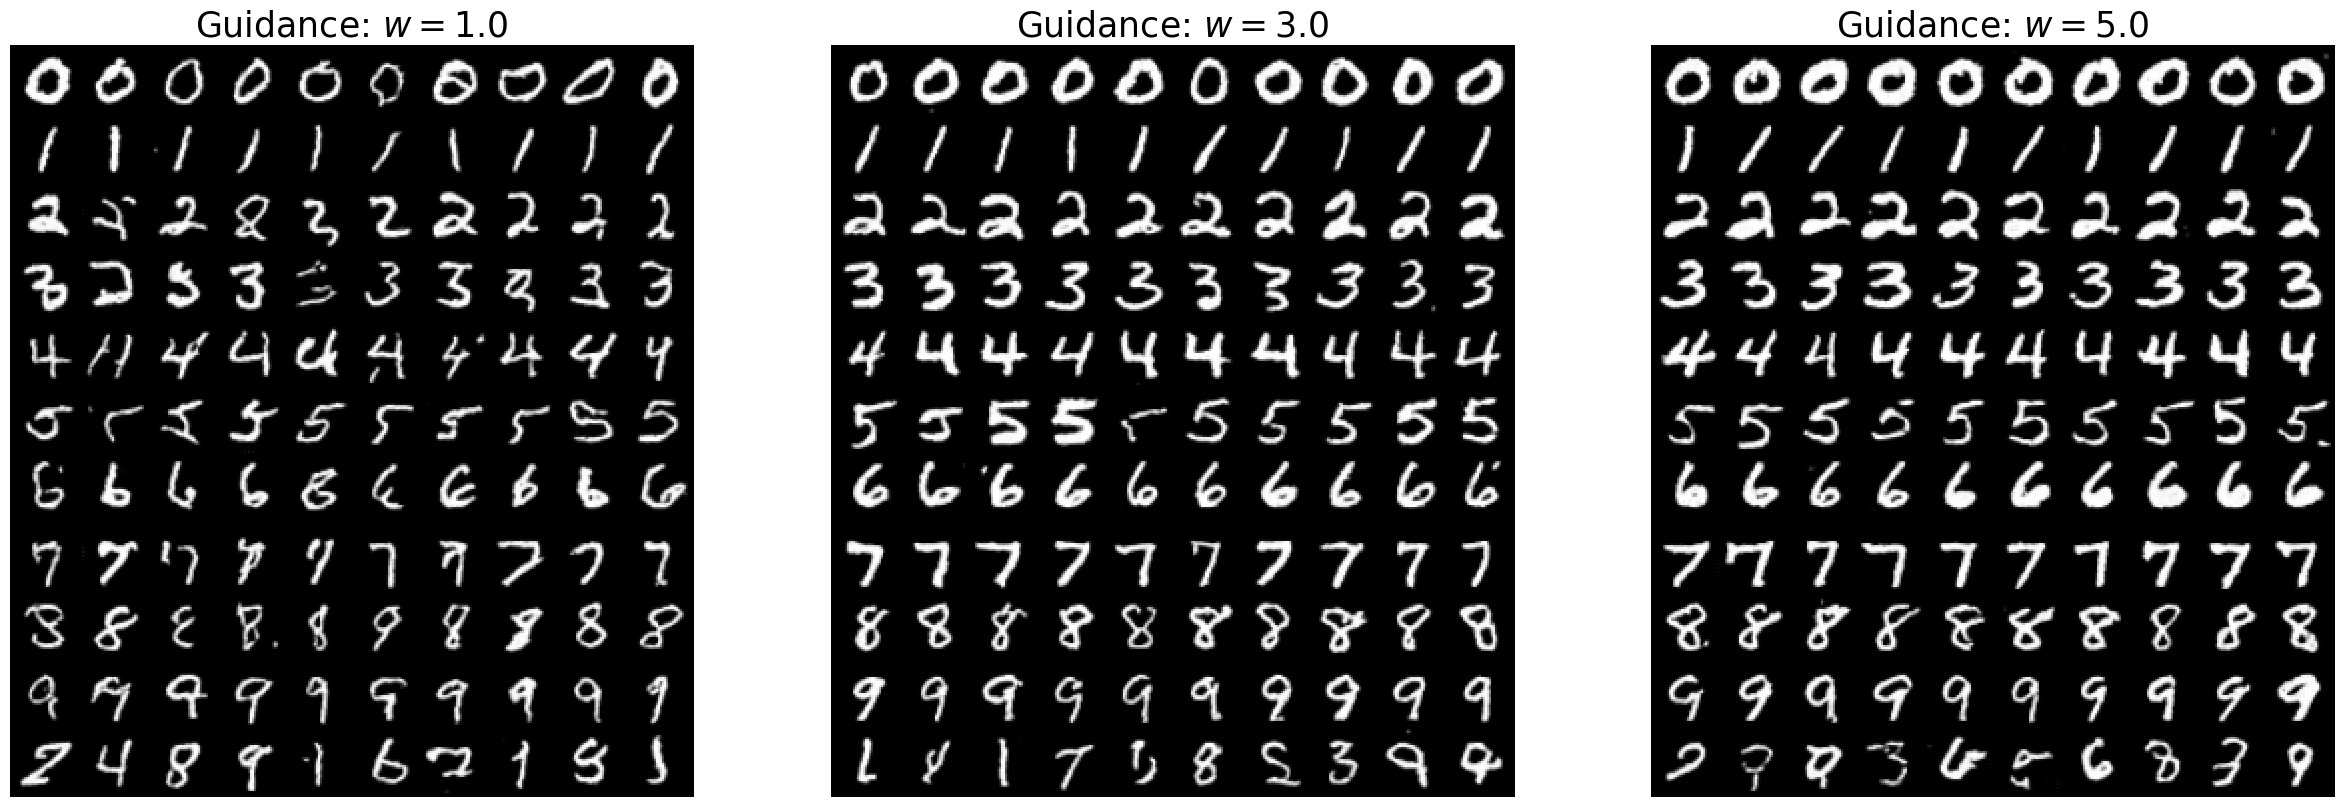

In [ ]:
# Play with these!
samples_per_class = 10
num_timesteps = 100
guidance_scales = [1.0, 3.0, 5.0]

# Graph
fig, axes = plt.subplots(1, len(guidance_scales), figsize=(10 * len(guidance_scales), 10))

for idx, w in enumerate(guidance_scales):
    # Setup ode and simulator
    ode = CFGVectorFieldODE(unet, guidance_scale=w)
    simulator = EulerSimulator(ode)

    # Sample initial conditions
    y = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=torch.int64).repeat_interleave(samples_per_class).to(device)
    num_samples = y.shape[0]
    x0, _ = path.p_simple.sample(num_samples) # (num_samples, 1, 32, 32)

    # Simulate
    ts = torch.linspace(0,1,num_timesteps).view(1, -1, 1, 1, 1).expand(num_samples, -1, 1, 1, 1).to(device)
    x1 = simulator.simulate(x0, ts, y=y)

    # Plot
    grid = make_grid(x1, nrow=samples_per_class, normalize=True, value_range=(-1,1))
    axes[idx].imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
    axes[idx].axis("off")
    axes[idx].set_title(f"Guidance: $w={w:.1f}$", fontsize=25)
plt.show()

**Your job:** What do you notice about our samples as the quality improves? Why might increasing the guidance scale $w$ have this affect? Propose an intuitive explanation in your own words.

**Your answer**:
As the sample quality improves, the generated outputs become more clearly aligned with the conditioning signal. The samples look sharper, more recognizable, and more confident, with fewer ambiguous or mixed features. At the same time, the diversity of the samples often decreases, and at very high guidance scales artifacts or unnatural patterns can appear.

This happens because increasing the guidance scale
𝑤
w strengthens the influence of the conditional signal relative to the unconditional model. Intuitively, the unconditional model encourages samples that look generally realistic, while the conditional model pushes samples toward features that strongly represent the desired class or prompt.